# Assignment 2c Notebook: Competitive Co-Evolution of Pac-Man Controllers and Ghost Controllers
For the final assignment in this course, you will use your cumulative understanding and implementation of genetic programming (GP) to implement the competitive co-evolution of Pac-Man controllers and Ghost controllers! From your previous assignment implementations, copy over the following files:
* `base_evolution.py`
* `fitness.py`
* `genetic_programming.py`
* `selection.py`
* `tree_genotype.py`

**If you implemented your parse trees in a separate file, copy that file over as well.** In addition, you will need to import this file in the following code cell.

As usual, be careful not to overwrite any of the other provided files, as we may have modified them between assignments. Make sure you are in the `EC-env` environment. If you are not, terminate the notebook server, run `conda activate EC-env`, and restart the notebook server.

To begin the assignment, execute the following cell.

In [422]:
# Configure this notebook to automatically reload modules as they're modified
# https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

!pip install snake-eyes-parser

import warnings
warnings.filterwarnings('ignore') # hopefully stop any pedantic warnings

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

import os
import statistics
from scipy import stats
from snake_eyes import read_config
from fitness import *
from tree_genotype import *
from selection import *
from gpac_population_evaluation import *
from genetic_programming import *
from base_evolution import *

print('The first cell has been executed!')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The first cell has been executed!


## Ghost Controllers
Assuming you already have a working implementation of a GP algorithm for Pac-Man controllers, implementing Ghost controllers should be relatively easy. The only real difference is that, for Ghosts, the `G` terminal returns the distance to the nearest *other* Ghost, and there is an additional `M` terminal returning the distance to Pac-Man (or the nearest Pac-Man, if attempting a deliverable with multiple Pac-Man agents in the game). While the algorithms you used to create, reproduce, and evaluate Pac-Man trees should still be applicable here, you need to make sure your code can cleanly handle the different terminal sets. There are many different ways to accomplish that, and it is up to you to choose how.

## Multi-Population Fitness Evaluation
Competitive fitness in GPac has the quirk of only being relative to encountered opponents. Since opponents belong to populations that are evolving, **you must re-calculate fitness for all individuals at each generation**. Additionally, since it is impractical to play against all opponents, it is also necessary to *approximate* fitness in some way. In practice, you would approximate fitness of an individual through competition with a sample of several opponents. In this assignment, however, we allow for each individual to play against as few as a single opponent per generation to manage computational cost.

As a result of the complex nature of competitive fitness for games like GPac, you will typically perform more fitness evaluations per generation than evolution using the same parameters on a problem with an objective/absolute fitness metric. For this assignment, the first generation will require $SampleSize*max(\mu_{PacMan}, \mu_{Ghost})$ fitness evaluations and each subsequent generation will require $SampleSize*max(\mu_{PacMan}+\lambda_{PacMan}, \mu_{Ghost}+\lambda_{Ghost})$ fitness evaluations, where $SampleSize$ represents the number of opponents sampled to approximate the fitness of each controller. Note that we allow $SampleSize=1$ in this assignment, though this is ill-advised in practice.

**Note**: If the sizes of Pac-Man and Ghost populations are not equal, then some controllers will have to play extra games to complete all fitness evaluations for a generation. If you use a controller more than once, simply calculate fitness as the average of all games the controller played that generation.

In the following cell, implement `competitive_population_evaluation`, a new function that accepts multiple populations as inputs, forms competition match-ups of individuals from the input populations, performs fitness evaluations with the match-ups, and assigns appropriate `fitness` and `base_fitness` members to each individual from the input populations. This should broadly resemble the single-population evaluation functions you implemented in several previous assignments. We've added comments that lay out a recommended approach, but you are free to approach implementing this algorithm however you wish.

**Note**: The `play_GPac` function returns the game score, but Ghost `base_fitness` should be calculated as the negation of game score. Recall also that each GP tree receives a parsimony penalty and you should be mindful to log `base_fitness` instead of `fitness` (which includes this parsimony penalty). Note that you do *not* need to store game logs, unless you wish to for your own purposes, as we will be playing exhibition games after evolution concludes for the purposes of visualization.

In [423]:
from statistics import mean
from itertools import cycle
import random
def competitive_population_evaluation(pac_population, ghost_population, 
                                      pac_parsimony_coefficient, 
                                      ghost_parsimony_coefficient, **kwargs):
    # TODO: Perform matchmaking to generate pairs of individuals, one from each population.
    # Make sure to read the above description very carefully; matchmaking is not trivial,
    # and your submitted code MUST be able to handle arbitrary population sizes,
    # including cases where the two populations have different sizes.
    num_evals = max(len(pac_population), len(ghost_population))
    
    for species in (pac_population, ghost_population):
        for individual in species:
            individual.base_fitness = []
            individual.fitness = []
            individual.log = []
            
    random.shuffle(pac_population)
    random.shuffle(ghost_population)               
    
    # TODO: Evaluate the matches with the play_Gpac function.
    # Hint: play_GPac(pac_controller, ghost_controller, **kwargs)
    for _, pacman, ghost in zip(range(num_evals), cycle(pac_population), cycle(ghost_population)):
        
        base_fitness, log = play_GPac(pacman.genes, ghost.genes, **kwargs)
        ghost_fitness = base_fitness*-1
        
        pacman.base_fitness.append(base_fitness)
        pacman.fitness.append(base_fitness - pac_parsimony_coefficient * pacman.genes.node_count())
        pacman.log.append(log)
        
        ghost.base_fitness.append(ghost_fitness)
        ghost.fitness.append(ghost_fitness - ghost_parsimony_coefficient * ghost.genes.node_count())
        ghost.log.append(log)
    
    
    
    # TODO: Calculate and assign fitness and base_fitness members.
    # Don't forget each population may have different parsimony coefficients,
    # and that you need to handle cases where an individual played multiple games.
    for species in (pac_population, ghost_population):
        for individual in species:
            individual.base_fitness = mean(individual.base_fitness)
            individual.fitness = mean(individual.fitness)
            individual.log = individual.log
            
    return num_evals

## Competitive Co-Evolution
Below is a high-level diagram of a 2-population competitive co-evolutionary algorithm. Using your Pac-Man controllers, Ghost controllers, and the `competitive_population_evaluation` function you just implemented, you should have all the necessary components to implement competitive co-evolution!
**Note**: there's a typo in the below figure and both cycles should perform **whole-population** Competitive Fitness Evaluation instead of evaluating only the children.
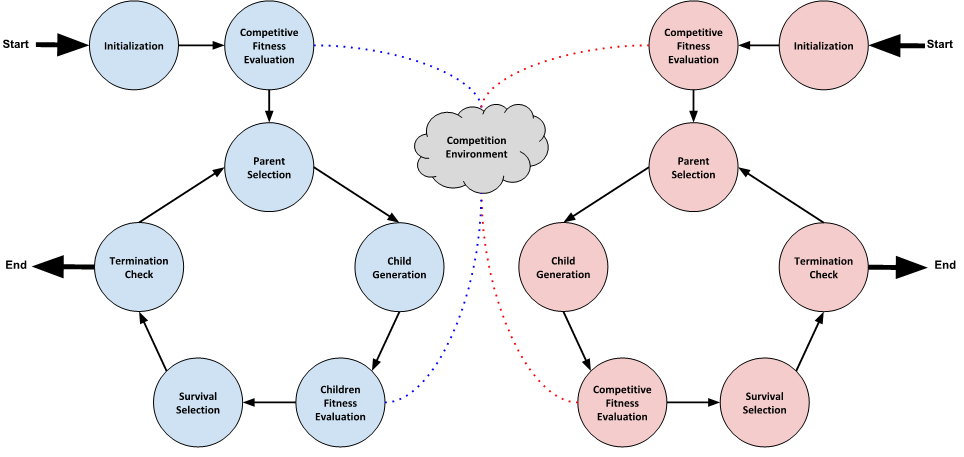

As mentioned previously, the quirks of competitive fitness require that you modify your typical evolution cycles slightly. Namely, you must re-evaluate and recalculate fitness for all individuals each generation. This means that, each generation, each population's children should be added to the adults, and then **all individuals in both populations** should be re-evaluated with your `competitive_population_evaluation` function. Make sure, however, that your `competitive_population_evaluation` function is *not* implemented such that fitness calculations incorporate games played from previous generations (for example, by giving each individual a member variable that stores a list of scores, from which you take an average; you may forget to reset this list each generation, resulting in incorrect fitness calculations).

However, aside from this shared evaluation step, each population should be treated in the code as separate EAs; you should instantiate two different `GeneticProgrammingPopulation` objects. The overall structure of your EA search should be the same as past assignments (there should only be one generational loop), except you need to duplicate all the steps for initialization, child generation, survival, logging, and so on.

### Config Parsing
The config file for co-evolution is a little more complex than previous assignments, so we'll give some code to extract per-species parameters in the following cell. Using the `pac_config` ang `ghost_config` dictonaries returned by this function, you should be able to instantiate GP populations using a similar call signature as previous assignments (e.g., `GeneticProgrammingPopulation(**pac_config['ea'], **pac_config)`)

In [424]:
def split_config(config):
    pac_config = dict()
    ghost_config = dict()

    for key in config:
        if key.startswith('pac_'):
            pac_config[key.partition('_')[-1]] = config[key]

        elif key.startswith('ghost_'):
            ghost_config[key.partition('_')[-1]] = config[key]

        else:
            pac_config[key] = config[key]
            ghost_config[key] = config[key]

    return pac_config, ghost_config

## Single Run Experiment
Now that we've covered the quirks of co-evolution a couple times, it's time for you to apply your understanding! In the following cell, implement the code for a single run of your competitive co-evolutionary algorithm.

In [462]:
from statistics import mean

def competitive_genetic_programming_search(number_evaluations, config_filename):
    config = read_config(config_filename, globals(), locals())
    pac_config, ghost_config = split_config(config)
    
    # Implement your GP search here.
    # Feel free to focus on implementation first and then return for data collection.
    # Hint: competitive_population_evaluation(pac_population, ghost_population,
    #                                         **config['fitness_kwargs'], **config['game'])
    
    pacman_gp = GeneticProgrammingPopulation(**pac_config['ea'], **pac_config)
    ghost_gp = GeneticProgrammingPopulation(**ghost_config['ea'], **ghost_config)
    print('before 1st evals')
    evals = competitive_population_evaluation(pacman_gp.population, ghost_gp.population,**config['fitness_kwargs'], **config['game'])
          
    fittest_pacman = max(pacman_gp.population, key=lambda x: x.base_fitness)
    fittest_ghost = max(ghost_gp.population, key=lambda x: x.base_fitness)
    
    data = {
        'Pacman' : {
            'Best Base Fitness' : fittest_pacman.base_fitness,
            'Best Fitness' : fittest_pacman.fitness,
            'Parse Tree' : fittest_pacman.genes.print(),
            'Game Log' : fittest_pacman.log
        },
        'Ghost' : {
            'Best Base Fitness' : fittest_ghost.base_fitness,
            'Best Fitness' : fittest_ghost.fitness,
            'Parse Tree' : fittest_ghost.genes.print(),
            'Game Log' : fittest_ghost.log
        }
    }
    print('before while')
    print(evals)
    while evals < number_evaluations:

        pacman_children = pacman_gp.generate_children()
        pacman_gp.population += pacman_children
        
        ghost_children = ghost_gp.generate_children()
        ghost_gp.population += ghost_children
        
        evals += competitive_population_evaluation(pacman_gp.population, ghost_gp.population,**config['fitness_kwargs'], **config['game'])
        print(evals)
        pacman_gp.survival()
        fittest_pacman = max(pacman_gp.population, key=lambda x: x.base_fitness)
        
        ghost_gp.survival()
        fittest_ghost = max(ghost_gp.population, key=lambda x: x.base_fitness)
    
        data['Pacman'].update({
            'Best Base Fitness' : fittest_pacman.base_fitness,
            'Best Fitness' : fittest_pacman.fitness,
            'Parse Tree' : fittest_pacman.genes.print(),
            'Game Log' : fittest_pacman.log
        })
        data['Ghost'].update({
            'Best Base Fitness' : fittest_ghost.base_fitness,
            'Best Fitness' : fittest_ghost.fitness,
            'Parse Tree' : fittest_ghost.genes.print(),
            'Game Log' : fittest_ghost.log
        })


    # Return whatever data you wish!
    return data

In [394]:
# Test your implementation
temp = competitive_genetic_programming_search(250, 'configs/2c_green_config.txt')
for entity, attributes in temp.items():
    print(f"{entity}:")
    for key, value in attributes.items():
        if key == 'Game Log':
            print(f"{key}:")
            for log_entry in value:
                # Joining the elements of each sublist in the log entry
                formatted_log_entry = '\n'.join(log_entry)
                print(f"{formatted_log_entry}")
        else:
            print(f"{key}: {value}")
    print()


before 1st evals
before while
400
Pacman:
Best Base Fitness: 74.26356589147287
Best Fitness: 48.86356589147286
Parse Tree: *
|-
||/
|||/
||||RAND
|||||RAND
||||||F
||||||P
|||||/
||||||G
||||||G
||||RAND
|||||-
||||||P
||||||-20.814410640373936
|||||+
||||||27.552445957576275
||||||P
|||RAND
||||-
|||||RAND
||||||-15.09854459389183
||||||-6.215696858744387
|||||*
||||||G
||||||W
||||+
|||||+
||||||P
||||||G
|||||RAND
||||||-17.78756709030386
||||||W
||+
|||/
||||+
|||||RAND
||||||F
||||||P
|||||/
||||||F
||||||P
||||+
|||||+
||||||F
||||||W
|||||/
||||||W
||||||W
|||RAND
||||*
|||||RAND
||||||P
||||||G
|||||/
||||||W
||||||-11.858308922637626
||||*
|||||/
||||||W
||||||W
|||||+
||||||P
||||||F
|+
||RAND
|||+
||||*
|||||-
||||||2.122684470284618
||||||-15.331913837419364
|||||*
||||||G
||||||G
||||-
|||||/
||||||-23.692445510616096
||||||-7.531240390978574
|||||RAND
||||||W
||||||19.08952530309631
|||/
||||RAND
|||||-
||||||13.046494939944381
||||||G
|||||RAND
||||||22.299605852433295
|

## Tuning
You may use the following cell to tune your parameters. While there are no explicit performance requirements for this assignment (partially because performance in competitive co-evolution is difficult to quantify), we remind you that the default config file contains parameters that are deliberately poor or nonsensical, and you will be penalized if your experiment was conducted without changing these parameters to more sensible values. You are required to utilize configurations that demonstrate a thorough understanding of the parameters' impacts.

In [ ]:
# Feel free to change these values and re-run this cell as much as you'd like
number_runs = 1
number_evaluations = 5000
config_filename = 'configs/2c_green_config.txt'

# Tuning runs can be called here


## Multi-Run Experiment
Implement a full 10-run experiment with 5,000 fitness evaluations per run. In the final generation of each run, log the parse tree and game log of the individual with the best base fitness *for each population*. For the run that produced the highest base Pac-Man fitness in the final generation, play an exhibition game between the highest-base-fitness Pac-Man controller and highest-base-fitness Ghost controller from that run's final generation. Save the log from this exhibition game and visualize it for informal analysis in your report. For more detail on report requirements, see the assignment description.

**Note**: Make sure you keep the best Pac-Man controller and the best Ghost controller from the end of each run *in memory*, in addition to logging the parse tree's string representation. You will use them after your experiment is complete for post-hoc analysis.

In [401]:
import multiprocessing
from multiprocessing import Pool
from functools import partial
import os

def run_experiment(run_id, config_filename, number_evaluations):
    result = competitive_genetic_programming_search(number_evaluations, config_filename)
    return (run_id, result)

def collect_results(number_runs, config_filename, number_evaluations):
    pool = Pool(processes=multiprocessing.cpu_count())
    experiment_func = partial(run_experiment, config_filename=config_filename, number_evaluations=number_evaluations)
    results = pool.map(experiment_func, range(number_runs))
    pool.close()
    pool.join()
    return results

number_runs = 10
number_evaluations = 5000
config_filename = 'configs/2c_green_config.txt'

experiment_results = collect_results(number_runs, config_filename, number_evaluations)

highest_base_fitness = -float('inf')
best_pac_run_data = None
for run_id, data in experiment_results:
    if data['Pacman']['Best Base Fitness'] > highest_base_fitness:
        highest_base_fitness = data['Pacman']['Best Base Fitness']
        best_pac_run_data = data['Pacman']
        
highest_base_fitness = -float('inf')
best_ghost_run_data = None
for run_id, data in experiment_results:
    if data['Ghost']['Best Base Fitness'] > highest_base_fitness:
        highest_base_fitness = data['Ghost']['Best Base Fitness']
        best_ghost_run_data = data['Ghost']


before 1st evals
before 1st evalsbefore 1st evalsbefore 1st evalsbefore 1st evals
before 1st evals



before 1st evals
before 1st evalsbefore 1st evalsbefore 1st evals


before while
400
before while
400
before while
400
before while
400
before while
400
before while
400
before while
400
before while
400
before while
400
before while
400
950
950
950
950
950
950
950
950
950
1500
1500
1500
1500
950
1500
1500
1500
1500
1500
2050
2050
2050
2050
2050
1500

2050
2600
2050
2050
2600
2600
2600
3150
2600
2600
2050
3150
2600
3150
3700
2600
3150
2600
3150
3150
4250
3700
2600
3700
4800
3150
5350
3700
4250
3700
3700
4250
3150
3150
4800
3150
4250
3700
4250
5350
4800
3700
4250
3700
4800
5350
3700
4250
4800
4250
4800
4800
5350
4250
4800
5350
5350
4250
5350
5350
4800
5350
4800
5350


MaybeEncodingError: Error sending result: '[(4, {'Pacman': {'Best Base Fitness': 88.37209302325581, 'Best Fitness': 85.37209302325581, 'Parse Tree': '/\n|/\n||RAND\n|||W\n|||G\n||/\n|||G\n|||1.751547459495768\n|-\n||*\n|||F\n|||G\n||+\n|||F\n|||P', 'Game Log': [['35', '20', 'm 0 19', '0 34 0', '1 0 0', '2 34 19', 'w 0 9', 'w 0 10', 'w 1 1', 'w 1 2', 'w 1 4', 'w 1 5', 'w 1 6', 'w 1 7', 'w 1 9', 'w 1 10', 'w 1 12', 'w 1 13', 'w 1 14', 'w 1 16', 'w 1 17', 'w 1 18', 'w 2 1', 'w 2 2', 'w 2 4', 'w 2 5', 'w 2 6', 'w 2 7', 'w 2 9', 'w 2 10', 'w 2 18', 'w 3 1', 'w 3 2', 'w 3 4', 'w 3 5', 'w 3 12', 'w 3 14', 'w 3 16', 'w 3 18', 'w 4 1', 'w 4 2', 'w 4 4', 'w 4 5', 'w 4 7', 'w 4 9', 'w 4 10', 'w 4 12', 'w 4 14', 'w 4 16', 'w 4 18', 'w 5 1', 'w 5 2', 'w 5 7', 'w 5 9', 'w 5 10', 'w 5 12', 'w 5 14', 'w 5 16', 'w 5 18', 'w 6 1', 'w 6 2', 'w 6 4', 'w 6 5', 'w 6 7', 'w 6 12', 'w 6 14', 'w 6 16', 'w 6 18', 'w 7 4', 'w 7 5', 'w 7 7', 'w 7 8', 'w 7 10', 'w 7 12', 'w 7 14', 'w 7 16', 'w 8 1', 'w 8 2', 'w 8 4', 'w 8 5', 'w 8 7', 'w 8 8', 'w 8 10', 'w 8 12', 'w 8 16', 'w 8 18', 'w 9 1', 'w 9 8', 'w 9 10', 'w 9 12', 'w 9 14', 'w 9 16', 'w 9 18', 'w 10 1', 'w 10 3', 'w 10 4', 'w 10 6', 'w 10 8', 'w 10 10', 'w 10 12', 'w 10 14', 'w 10 16', 'w 10 18', 'w 11 1', 'w 11 3', 'w 11 4', 'w 11 6', 'w 11 14', 'w 11 16', 'w 11 18', 'w 12 1', 'w 12 3', 'w 12 4', 'w 12 6', 'w 12 8', 'w 12 9', 'w 12 10', 'w 12 11', 'w 12 12', 'w 12 14', 'w 12 18', 'w 13 1', 'w 13 6', 'w 13 14', 'w 13 16', 'w 13 18', 'w 14 1', 'w 14 3', 'w 14 5', 'w 14 6', 'w 14 8', 'w 14 10', 'w 14 12', 'w 14 14', 'w 14 16', 'w 14 18', 'w 15 1', 'w 15 3', 'w 15 5', 'w 15 6', 'w 15 8', 'w 15 10', 'w 15 12', 'w 15 14', 'w 15 16', 'w 15 18', 'w 16 3', 'w 16 5', 'w 16 6', 'w 16 8', 'w 16 10', 'w 16 12', 'w 17 0', 'w 17 1', 'w 17 2', 'w 17 3', 'w 17 8', 'w 17 12', 'w 17 13', 'w 17 15', 'w 17 16', 'w 17 18', 'w 17 19', 'w 18 3', 'w 18 5', 'w 18 6', 'w 18 8', 'w 18 10', 'w 18 12', 'w 19 1', 'w 19 3', 'w 19 5', 'w 19 6', 'w 19 8', 'w 19 10', 'w 19 12', 'w 19 14', 'w 19 16', 'w 19 18', 'w 20 1', 'w 20 3', 'w 20 5', 'w 20 6', 'w 20 8', 'w 20 10', 'w 20 12', 'w 20 14', 'w 20 16', 'w 20 18', 'w 21 1', 'w 21 6', 'w 21 14', 'w 21 16', 'w 21 18', 'w 22 1', 'w 22 3', 'w 22 4', 'w 22 6', 'w 22 8', 'w 22 9', 'w 22 10', 'w 22 11', 'w 22 12', 'w 22 14', 'w 22 18', 'w 23 1', 'w 23 3', 'w 23 4', 'w 23 6', 'w 23 14', 'w 23 16', 'w 23 18', 'w 24 1', 'w 24 3', 'w 24 4', 'w 24 6', 'w 24 8', 'w 24 10', 'w 24 12', 'w 24 14', 'w 24 16', 'w 24 18', 'w 25 1', 'w 25 8', 'w 25 10', 'w 25 12', 'w 25 14', 'w 25 16', 'w 25 18', 'w 26 1', 'w 26 2', 'w 26 4', 'w 26 5', 'w 26 7', 'w 26 8', 'w 26 10', 'w 26 12', 'w 26 16', 'w 26 18', 'w 27 4', 'w 27 5', 'w 27 7', 'w 27 8', 'w 27 10', 'w 27 12', 'w 27 14', 'w 27 16', 'w 28 1', 'w 28 2', 'w 28 4', 'w 28 5', 'w 28 7', 'w 28 12', 'w 28 14', 'w 28 16', 'w 28 18', 'w 29 1', 'w 29 2', 'w 29 7', 'w 29 9', 'w 29 10', 'w 29 12', 'w 29 14', 'w 29 16', 'w 29 18', 'w 30 1', 'w 30 2', 'w 30 4', 'w 30 5', 'w 30 7', 'w 30 9', 'w 30 10', 'w 30 12', 'w 30 14', 'w 30 16', 'w 30 18', 'w 31 1', 'w 31 2', 'w 31 4', 'w 31 5', 'w 31 12', 'w 31 14', 'w 31 16', 'w 31 18', 'w 32 1', 'w 32 2', 'w 32 4', 'w 32 5', 'w 32 6', 'w 32 7', 'w 32 9', 'w 32 10', 'w 32 18', 'w 33 1', 'w 33 2', 'w 33 4', 'w 33 5', 'w 33 6', 'w 33 7', 'w 33 9', 'w 33 10', 'w 33 12', 'w 33 13', 'w 33 14', 'w 33 16', 'w 33 17', 'w 33 18', 'w 34 9', 'w 34 10', 'p 7 17', 'p 22 17', 'p 30 0', 'p 14 13', 'p 5 19', 'p 13 8', 'p 29 4', 'p 13 17', 'p 21 0', 'p 21 9', 'p 27 6', 'p 3 6', 'p 19 2', 'p 3 15', 'p 19 11', 'p 11 7', 'p 1 8', 'p 34 5', 'p 34 14', 'p 17 7', 'p 9 3', 'p 0 0', 'p 15 0', 'p 32 16', 'p 33 15', 'p 15 9', 'p 6 6', 'p 25 11', 'p 16 17', 'p 32 19', 'p 31 8', 'p 22 5', 'p 31 17', 'p 23 13', 'p 30 6', 'p 14 19', 'p 13 5', 'p 29 13', 'p 3 3', 'p 20 19', 'p 12 15', 'p 28 11', 'p 4 11', 'p 27 15', 'p 10 17', 'p 18 0', 'p 26 13', 'p 2 13', 'p 18 9', 'p 18 18', 'p 34 2', 'p 34 11', 'p 17 4', 'p 9 0', 'p 9 9', 'p 33 3', 'p 24 0', 'p 32 13', 'p 8 13', 'p 24 9', 'p 7 2', 'p 0 18', 'p 25 17', 'p 16 14', 'p 7 11', 'p 22 2', 'p 6 15', 'p 23 10', 'p 14 7', 'p 5 4', 'p 23 19', 'p 5 13', 'p 13 2', 'p 30 15', 'p 13 11', 'p 20 7', 'p 3 0', 'p 29 19', 'p 21 15', 'p 3 9', 'p 4 8', 'p 27 3', 'p 4 17', 'p 10 5', 'p 19 17', 'p 1 11', 'p 11 13', 'p 2 19', 'p 33 0', 'p 0 6', 'p 25 5', 'p 8 19', 'p 16 2', 'p 0 15', 'p 6 3', 'p 15 15', 'p 31 11', 'p 23 7', 'p 14 4', 'p 30 3', 'p 20 4', 'p 21 3', 'p 12 0', 'p 20 13', 'p 21 12', 'p 27 0', 'p 27 9', 'p 28 8', 'p 10 2', 'p 27 18', 'p 28 17', 'p 10 11', 'p 11 10', 'p 11 19', 'p 2 16', 'p 26 19', 'p 18 15', 'p 34 8', 'p 34 17', 'p 17 10', 'p 9 6', 'p 0 3', 'p 25 2', 'p 9 15', 'p 0 12', 'p 6 0', 'p 24 15', 'p 6 9', 'p 16 11', 't 1750 0', 'm 0 18', '0 34 1', '1 1 0', '2 33 19', 't 1749 0.7751937984496124', 'm 0 19', '0 34 0', '1 2 0', '2 32 19', 't 1748 0.7751937984496124', 'm 1 19', '0 33 0', '1 3 0', '2 31 19', 't 1747 0.7751937984496124', 'm 0 19', '0 34 0', '1 2 0', '2 32 19', 't 1746 0.7751937984496124', 'm 0 18', '0 34 1', '1 1 0', '2 33 19', 't 1745 0.7751937984496124', 'm 0 19', '0 34 2', '1 0 0', '2 34 19', 't 1744 0.7751937984496124', 'm 0 18', '0 34 3', '1 1 0', '2 33 19', 't 1743 0.7751937984496124', 'm 0 17', '0 33 3', '1 0 0', '2 34 19', 't 1742 0.7751937984496124', 'm 0 16', '0 32 3', '1 0 1', '2 34 18', 't 1741 0.7751937984496124', 'm 0 17', '0 31 3', '1 0 0', '2 34 19', 't 1740 0.7751937984496124', 'm 0 16', '0 30 3', '1 0 1', '2 33 19', 't 1739 0.7751937984496124', 'm 0 15', '0 31 3', '1 0 2', '2 32 19', 't 1738 1.550387596899225', 'm 1 15', '0 32 3', '1 0 3', '2 33 19', 't 1737 1.550387596899225', 'm 1 15', '0 33 3', '1 0 2', '2 32 19', 't 1736 1.550387596899225', 'm 2 15', '0 32 3', '1 0 3', '2 33 19', 't 1735 1.550387596899225', 'm 2 14', '0 33 3', '1 0 4', '2 34 19', 't 1734 1.550387596899225', 'm 2 13', '0 32 3', '1 0 3', '2 34 18', 't 1733 2.3255813953488373', 'm 2 13', '0 31 3', '1 0 4', '2 34 17', 't 1732 2.3255813953488373', 'm 2 12', '0 30 3', '1 0 3', '2 34 18', 't 1731 2.3255813953488373', 'm 2 12', '0 29 3', '1 1 3', '2 34 17', 't 1730 2.3255813953488373', 'm 2 11', '0 29 4', '1 2 3', '2 34 16', 't 1729 2.3255813953488373', 'm 2 11', '0 29 5', '1 1 3', '2 34 15', 't 1728 2.3255813953488373', 'm 1 11', '0 29 4', '1 0 3', '2 33 15', 't 1727 3.10077519379845', 'm 1 11', '0 29 3', '1 0 2', '2 32 15', 't 1726 3.10077519379845', 'm 1 11', '0 29 4', '1 0 1', '2 33 15', 't 1725 3.10077519379845', 'm 0 11', '0 29 5', '1 0 2', '2 34 15', 't 1724 3.10077519379845', 'm 0 12', '0 29 6', '1 0 3', '2 33 15', 't 1723 3.875968992248062', 'm 0 11', '0 28 6', '1 0 4', '2 32 15', 't 1722 3.875968992248062', 'm 0 11', '0 27 6', '1 0 3', '2 33 15', 't 1721 3.875968992248062', 'm 1 11', '0 26 6', '1 0 4', '2 34 15', 't 1720 3.875968992248062', 'm 2 11', '0 27 6', '1 0 3', '2 34 14', 't 1719 3.875968992248062', 'm 2 11', '0 28 6', '1 0 4', '2 34 15', 't 1718 3.875968992248062', 'm 2 12', '0 27 6', '1 0 3', '2 33 15', 't 1717 3.875968992248062', 'm 2 13', '0 26 6', '1 0 4', '2 34 15', 't 1716 3.875968992248062', 'm 2 12', '0 25 6', '1 0 3', '2 34 16', 't 1715 3.875968992248062', 'm 2 13', '0 26 6', '1 0 2', '2 34 17', 't 1714 3.875968992248062', 'm 2 13', '0 27 6', '1 0 3', '2 34 18', 't 1713 3.875968992248062', 'm 2 12', '0 26 6', '1 0 2', '2 34 19', 't 1712 3.875968992248062', 'm 2 12', '0 27 6', '1 0 3', '2 33 19', 't 1711 3.875968992248062', 'm 2 11', '0 28 6', '1 1 3', '2 32 19', 't 1710 3.875968992248062', 'm 3 11', '0 29 6', '1 2 3', '2 33 19', 't 1709 3.875968992248062', 'm 3 11', '0 28 6', '1 1 3', '2 32 19', 't 1708 3.875968992248062', 'm 3 11', '0 27 6', '1 2 3', '2 31 19', 't 1707 3.875968992248062', 'm 4 11', '0 26 6', '1 3 3', '2 32 19', 't 1706 4.651162790697675', 'm 4 11', '0 27 6', '1 2 3', '2 31 19', 't 1705 4.651162790697675', 'm 4 11', '0 26 6', '1 3 3', '2 32 19', 't 1704 4.651162790697675', 'm 3 11', '0 25 6', '1 2 3', '2 31 19', 't 1703 4.651162790697675', 'm 3 10', '0 26 6', '1 1 3', '2 32 19', 't 1702 4.651162790697675', 'm 3 10', '0 27 6', '1 2 3', '2 33 19', 't 1701 4.651162790697675', 'm 3 9', '0 28 6', '1 3 3', '2 34 19', 't 1700 5.426356589147287', 'm 3 9', '0 29 6', '1 4 3', '2 34 18', 't 1699 5.426356589147287', 'm 3 8', '0 29 5', '1 5 3', '2 34 17', 't 1698 5.426356589147287', 'm 3 8', '0 29 6', '1 6 3', '2 34 16', 't 1697 5.426356589147287', 'm 4 8', '0 29 5', '1 7 3', '2 34 17', 't 1696 6.2015503875969', 'm 3 8', '0 29 4', '1 8 3', '2 34 18', 't 1695 6.2015503875969', 'm 4 8', '0 29 3', '1 9 3', '2 34 17', 't 1694 6.2015503875969', 'm 4 8', '0 30 3', '1 8 3', '2 34 16', 't 1693 6.2015503875969', 'm 5 8', '0 29 3', '1 7 3', '2 34 17', 't 1692 6.2015503875969', 'm 4 8', '0 29 4', '1 7 2', '2 34 16', 't 1691 6.2015503875969', 'm 4 8', '0 29 3', '1 7 1', '2 34 15', 't 1690 6.2015503875969', 'm 5 8', '0 29 4', '1 7 0', '2 34 16', 't 1689 6.2015503875969', 'm 5 8', '0 29 3', '1 7 1', '2 34 15', 't 1688 6.2015503875969', 'm 6 8', '0 28 3', '1 7 2', '2 34 14', 't 1687 6.2015503875969', 'm 5 8', '0 29 3', '1 7 1', '2 34 13', 't 1686 6.2015503875969', 'm 5 8', '0 28 3', '1 7 2', '2 34 12', 't 1685 6.2015503875969', 'm 6 8', '0 27 3', '1 7 1', '2 34 11', 't 1684 6.2015503875969', 'm 6 9', '0 27 2', '1 7 0', '2 33 11', 't 1683 6.976744186046512', 'm 6 10', '0 27 1', '1 8 0', '2 32 11', 't 1682 6.976744186046512', 'm 6 9', '0 27 0', '1 7 0', '2 31 11', 't 1681 6.976744186046512', 'm 7 9', '0 26 0', '1 8 0', '2 30 11', 't 1680 6.976744186046512', 'm 6 9', '0 27 0', '1 7 0', '2 29 11', 't 1679 6.976744186046512', 'm 7 9', '0 27 1', '1 6 0', '2 28 11', 't 1678 6.976744186046512', 'm 7 9', '0 27 0', '1 7 0', '2 29 11', 't 1677 6.976744186046512', 'm 8 9', '0 27 1', '1 6 0', '2 28 11', 'f 34 19', 't 1676 6.976744186046512', 'm 9 9', '0 27 0', '1 5 0', '2 27 11', 't 1675 7.751937984496124', 'm 8 9', '0 27 1', '1 4 0', '2 28 11', 't 1674 7.751937984496124', 'm 7 9', '0 27 0', '1 3 0', '2 29 11', 't 1673 7.751937984496124', 'm 7 9', '0 27 1', '1 2 0', '2 30 11', 't 1672 7.751937984496124', 'm 6 9', '0 27 2', '1 1 0', '2 29 11', 't 1671 7.751937984496124', 'm 6 8', '0 27 3', '1 0 0', '2 28 11', 't 1670 7.751937984496124', 'm 6 8', '0 26 3', '1 0 1', '2 28 10', 't 1669 7.751937984496124', 'm 6 8', '0 25 3', '1 0 0', '2 28 11', 't 1668 7.751937984496124', 'm 5 8', '0 26 3', '1 1 0', '2 27 11', 't 1667 7.751937984496124', 'm 5 8', '0 27 3', '1 0 0', '2 28 11', 't 1666 7.751937984496124', 'm 6 8', '0 27 2', '1 0 1', '2 29 11', 't 1665 7.751937984496124', 'm 6 9', '0 27 3', '1 0 0', '2 30 11', 't 1664 7.751937984496124', 'm 6 8', '0 27 2', '1 0 1', '2 29 11', 't 1663 7.751937984496124', 'm 6 9', '0 27 3', '1 0 0', '2 28 11', 't 1662 7.751937984496124', 'm 6 9', '0 27 2', '1 1 0', '2 28 10', 't 1661 7.751937984496124', 'm 6 9', '0 27 3', '1 0 0', '2 28 11', 't 1660 7.751937984496124', 'm 6 9', '0 28 3', '1 1 0', '2 28 10', 't 1659 7.751937984496124', 'm 6 9', '0 27 3', '1 0 0', '2 28 9', 't 1658 7.751937984496124', 'm 6 8', '0 27 2', '1 0 1', '2 28 8', 't 1657 7.751937984496124', 'm 6 8', '0 27 3', '1 0 0', '2 28 9', 't 1656 7.751937984496124', 'm 6 8', '0 26 3', '1 0 1', '2 28 10', 't 1655 7.751937984496124', 'm 6 9', '0 27 3', '1 0 0', '2 28 11', 't 1654 7.751937984496124', 'm 6 9', '0 27 2', '1 1 0', '2 28 10', 't 1653 7.751937984496124', 'm 6 8', '0 27 3', '1 0 0', '2 28 11', 't 1652 7.751937984496124', 'm 5 8', '0 27 2', '1 1 0', '2 28 10', 't 1651 7.751937984496124', 'm 4 8', '0 27 3', '1 0 0', '2 28 9', 't 1650 7.751937984496124', 'm 5 8', '0 28 3', '1 1 0', '2 27 9', 't 1649 7.751937984496124', 'm 5 8', '0 27 3', '1 0 0', '2 28 9', 't 1648 7.751937984496124', 'm 5 8', '0 27 2', '1 1 0', '2 27 9', 't 1647 7.751937984496124', 'm 5 8', '0 27 3', '1 0 0', '2 26 9', 't 1646 7.751937984496124', 'm 6 8', '0 28 3', '1 0 1', '2 27 9', 't 1645 7.751937984496124', 'm 6 8', '0 27 3', '1 0 0', '2 26 9', 't 1644 7.751937984496124', 'm 5 8', '0 27 2', '1 0 1', '2 25 9', 't 1643 7.751937984496124', 'm 4 8', '0 27 3', '1 0 0', '2 24 9', 't 1642 7.751937984496124', 'm 4 8', '0 26 3', '1 1 0', '2 23 9', 't 1641 7.751937984496124', 'm 5 8', '0 25 3', '1 0 0', '2 24 9', 't 1640 7.751937984496124', 'm 4 8', '0 26 3', '1 0 1', '2 25 9', 't 1639 7.751937984496124', 'm 4 8', '0 27 3', '1 0 0', '2 24 9', 't 1638 7.751937984496124', 'm 3 8', '0 27 2', '1 0 1', '2 25 9', 't 1637 7.751937984496124', 'm 4 8', '0 27 3', '1 0 0', '2 24 9', 't 1636 7.751937984496124', 'm 5 8', '0 26 3', '1 0 1', '2 23 9', 't 1635 7.751937984496124', 'm 4 8', '0 25 3', '1 0 0', '2 24 9', 't 1634 7.751937984496124', 'm 4 8', '0 25 4', '1 0 1', '2 25 9', 't 1633 7.751937984496124', 'm 3 8', '0 25 3', '1 0 0', '2 24 9', 't 1632 7.751937984496124', 'm 4 8', '0 25 2', '1 1 0', '2 23 9', 't 1631 7.751937984496124', 'm 3 8', '0 25 3', '1 0 0', '2 24 9', 't 1630 7.751937984496124', 'm 3 9', '0 25 4', '1 0 1', '2 25 9', 't 1629 7.751937984496124', 'm 3 9', '0 25 5', '1 0 0', '2 24 9', 't 1628 7.751937984496124', 'm 3 8', '0 24 5', '1 0 1', '2 23 9', 't 1627 7.751937984496124', 'm 2 8', '0 23 5', '1 0 0', '2 24 9', 't 1626 7.751937984496124', 'm 3 8', '0 24 5', '1 0 1', '2 25 9', 't 1625 7.751937984496124', 'm 4 8', '0 23 5', '1 0 0', '2 26 9', 't 1624 7.751937984496124', 'm 5 8', '0 22 5', '1 1 0', '2 25 9', 't 1623 7.751937984496124', 'm 5 8', '0 23 5', '1 0 0', '2 26 9', 't 1622 7.751937984496124', 'm 5 8', '0 22 5', '1 1 0', '2 27 9', 't 1621 7.751937984496124', 'm 6 8', '0 21 5', '1 0 0', '2 28 9', 't 1620 7.751937984496124', 'm 6 8', '0 22 5', '1 1 0', '2 27 9', 't 1619 7.751937984496124', 'm 6 9', '0 23 5', '1 0 0', '2 28 9', 't 1618 7.751937984496124', 'm 6 8', '0 22 5', '1 1 0', '2 27 9', 't 1617 7.751937984496124', 'm 5 8', '0 21 5', '1 0 0', '2 28 9', 't 1616 7.751937984496124', 'm 4 8', '0 22 5', '1 0 1', '2 27 9', 't 1615 7.751937984496124', 'm 3 8', '0 21 5', '1 0 0', '2 28 9', 't 1614 7.751937984496124', 'm 3 7', '0 22 5', '1 1 0', '2 28 10', 't 1613 7.751937984496124', 'm 3 6', '0 23 5', '1 0 0', '2 28 11', 't 1612 8.527131782945736', 'm 3 6', '0 24 5', '1 0 1', '2 27 11', 't 1611 8.527131782945736', 'm 3 6', '0 25 5', '1 0 0', '2 28 11', 't 1610 8.527131782945736', 'm 3 6', '0 25 4', '1 1 0', '2 29 11', 't 1609 8.527131782945736', 'm 3 6', '0 25 5', '1 0 0', '2 30 11', 't 1608 8.527131782945736', 'm 3 7', '0 24 5', '1 0 1', '2 31 11', 't 1607 8.527131782945736', 'm 3 8', '0 25 5', '1 0 0', '2 30 11', 't 1606 8.527131782945736', 'm 3 7', '0 25 4', '1 0 1', '2 31 11', 't 1605 8.527131782945736', 'm 3 8', '0 25 3', '1 0 0', '2 32 11', 't 1604 8.527131782945736', 'm 2 8', '0 25 4', '1 0 1', '2 33 11', 't 1603 8.527131782945736', 'm 1 8', '0 25 5', '1 0 0', '2 32 11', 't 1602 9.30232558139535', 'm 0 8', '0 25 4', '1 1 0', '2 32 12', 't 1601 9.30232558139535', 'm 0 7', '0 25 5', '1 2 0', '2 32 13', 't 1600 9.30232558139535', 'm 0 6', '0 25 6', '1 3 0', '2 32 12', 't 1599 10.077519379844961', 'm 0 6', '0 25 7', '1 4 0', '2 32 11', 't 1598 10.077519379844961', 'm 0 5', '0 24 7', '1 3 0', '2 31 11', 't 1597 10.077519379844961', 'm 0 4', '0 23 7', '1 2 0', '2 31 10', 't 1596 10.077519379844961', 'm 0 3', '0 22 7', '1 3 0', '2 31 11', 't 1595 10.852713178294573', 'm 1 3', '0 21 7', '1 4 0', '2 31 10', 't 1594 10.852713178294573', 'm 2 3', '0 21 8', '1 5 0', '2 31 11', 't 1593 10.852713178294573', 'm 3 3', '0 21 9', '1 6 0', '2 31 10', 't 1592 11.627906976744185', 'm 4 3', '0 20 9', '1 7 0', '2 31 11', 't 1591 11.627906976744185', 'm 4 3', '0 21 9', '1 8 0', '2 32 11', 't 1590 11.627906976744185', 'm 5 3', '0 21 10', '1 9 0', '2 32 12', 't 1589 11.627906976744185', 'm 6 3', '0 21 9', '1 10 0', '2 32 11', 't 1588 12.4031007751938', 'm 6 3', '0 21 8', '1 11 0', '2 33 11', 't 1587 12.4031007751938', 'm 7 3', '0 21 7', '1 12 0', '2 32 11', 't 1586 12.4031007751938', 'm 8 3', '0 22 7', '1 13 0', '2 31 11', 't 1585 12.4031007751938', 'm 8 3', '0 23 7', '1 14 0', '2 32 11', 't 1584 12.4031007751938', 'm 8 3', '0 22 7', '1 15 0', '2 32 12', 't 1583 12.4031007751938', 'm 9 3', '0 23 7', '1 16 0', '2 32 13', 't 1582 13.178294573643411', 'm 9 3', '0 23 8', '1 15 0', '2 32 12', 't 1581 13.178294573643411', 'm 9 2', '0 23 7', '1 16 0', '2 32 11', 't 1580 13.178294573643411', 'm 9 3', '0 23 8', '1 16 1', '2 31 11', 't 1579 13.178294573643411', 'm 9 2', '0 23 9', '1 16 0', '2 31 10', 't 1578 13.178294573643411', 'm 9 3', '0 24 9', '1 16 1', '2 31 11', 't 1577 13.178294573643411', 'm 9 2', '0 25 9', '1 16 0', '2 32 11', 't 1576 13.178294573643411', 'm 9 2', '0 24 9', '1 15 0', '2 32 12', 't 1575 13.178294573643411', 'm 9 2', '0 25 9', '1 16 0', '2 32 11', 't 1574 13.178294573643411', 'm 10 2', '0 24 9', '1 15 0', '2 31 11', 't 1573 13.953488372093023', 'm 11 2', '0 23 9', '1 16 0', '2 30 11', 't 1572 13.953488372093023', 'm 12 2', '0 24 9', '1 16 1', '2 31 11', 't 1571 13.953488372093023', 'm 13 2', '0 23 9', '1 16 0', '2 30 11', 't 1570 14.728682170542635', 'm 14 2', '0 23 10', '1 15 0', '2 31 11', 't 1569 14.728682170542635', 'm 15 2', '0 23 11', '1 16 0', '2 32 11', 't 1568 14.728682170542635', 'm 16 2', '0 23 10', '1 15 0', '2 31 11', 't 1567 15.503875968992247', 'm 16 1', '0 23 11', '1 14 0', '2 30 11', 't 1566 15.503875968992247', 'm 16 0', '0 23 10', '1 13 0', '2 31 11', 't 1565 15.503875968992247', 'm 15 0', '0 23 11', '1 12 0', '2 30 11', 't 1564 16.27906976744186', 'm 14 0', '0 24 11', '1 11 0', '2 31 11', 't 1563 16.27906976744186', 'm 13 0', '0 25 11', '1 10 0', '2 30 11', 't 1562 16.27906976744186', 'm 12 0', '0 26 11', '1 9 0', '2 31 11', 't 1561 17.05426356589147', 'm 11 0', '0 25 11', '1 8 0', '2 30 11', 't 1560 17.05426356589147', 'm 10 0', '0 24 11', '1 7 0', '2 31 11', 't 1559 17.05426356589147', 'm 9 0', '0 23 11', '1 6 0', '2 32 11', 't 1558 17.829457364341085', 'm 8 0', '0 24 11', '1 5 0', '2 31 11', 't 1557 17.829457364341085', 'm 7 0', '0 25 11', '1 4 0', '2 31 10', 't 1556 17.829457364341085', 'm 6 0', '0 26 11', '1 3 0', '2 31 11', 't 1555 18.6046511627907', 'm 5 0', '0 25 11', '1 2 0', '2 31 10', 't 1554 18.6046511627907', 'm 4 0', '0 24 11', '1 1 0', '2 31 11', 't 1553 18.6046511627907', 'm 3 0', '0 25 11', '1 0 0', '2 32 11', 't 1552 19.37984496124031', 'm 2 0', '0 26 11', '1 0 1', '2 32 12', 't 1551 19.37984496124031', 'm 1 0', '0 25 11', '1 0 2', '2 32 13', 't 1550 19.37984496124031', 'm 0 0', '0 24 11', '1 0 3', '2 31 13', 't 1549 20.155038759689923', 'm 0 1', '0 23 11', '1 1 3', '2 30 13', 't 1548 20.155038759689923', 'm 0 2', '0 24 11', '1 2 3', '2 29 13', 't 1547 20.155038759689923', 'm 0 3', '0 25 11', '1 3 3', '2 30 13', 't 1546 20.155038759689923', 'm 1 3', '0 26 11', '1 4 3', '2 29 13', 't 1545 20.155038759689923', 'm 2 3', '0 25 11', '1 5 3', '2 28 13', 't 1544 20.155038759689923', 'm 3 3', '0 26 11', '1 5 4', '2 27 13', 't 1543 20.155038759689923', 'm 4 3', '0 25 11', '1 5 5', '2 28 13', 't 1542 20.155038759689923', 'm 5 3', '0 26 11', '1 5 6', '2 29 13', 't 1541 20.155038759689923', 'm 5 4', '0 25 11', '1 6 6', '2 30 13', 't 1540 20.930232558139537', 'm 5 5', '0 26 11', '1 7 6', '2 31 13', 't 1539 20.930232558139537', 'm 5 6', '0 25 11', '1 8 6', '2 32 13', 't 1538 20.930232558139537', 'm 6 6', '0 24 11', '1 9 6', '2 31 13', 't 1537 21.705426356589147', 'm 7 6', '0 25 11', '1 9 5', '2 30 13', 't 1536 21.705426356589147', 'm 8 6', '0 24 11', '1 9 4', '2 29 13', 't 1535 21.705426356589147', 'm 9 6', '0 23 11', '1 9 3', '2 28 13', 't 1534 22.48062015503876', 'm 9 5', '0 23 12', '1 9 2', '2 27 13', 't 1533 22.48062015503876', 'm 9 4', '0 23 11', '1 10 2', '2 26 13', 't 1532 22.48062015503876', 'm 9 3', '0 23 10', '1 11 2', '2 27 13', 't 1531 22.48062015503876', 'm 9 2', '0 23 9', '1 12 2', '2 28 13', 't 1530 22.48062015503876', 'm 10 2', '0 23 10', '1 13 2', '2 27 13', 't 1529 22.48062015503876', 'm 11 2', '0 23 11', '1 13 3', '2 28 13', 't 1528 22.48062015503876', 'm 12 2', '0 24 11', '1 13 4', '2 29 13', 't 1527 22.48062015503876', 'm 13 2', '0 23 11', '1 13 5', '2 28 13', 't 1526 22.48062015503876', 'm 13 3', '0 23 10', '1 12 5', '2 29 13', 't 1525 22.48062015503876', 'm 13 4', '0 23 11', '1 11 5', '2 30 13', 't 1524 22.48062015503876', 'm 13 5', '0 23 12', '1 10 5', '2 29 13', 't 1523 23.25581395348837', 'm 12 5', '0 23 13', '1 9 5', '2 28 13', 't 1522 23.25581395348837', 'm 11 5', '0 24 13', '1 9 4', '2 27 13', 't 1521 23.25581395348837', 'm 10 5', '0 23 13', '1 9 3', '2 26 13', 't 1520 24.031007751937985', 'm 9 5', '0 23 12', '1 8 3', '2 26 14', 't 1519 24.031007751937985', 'm 9 4', '0 23 13', '1 7 3', '2 26 15', 't 1518 24.031007751937985', 'm 9 3', '0 23 12', '1 7 2', '2 27 15', 't 1517 24.031007751937985', 'm 9 2', '0 23 13', '1 7 1', '2 28 15', 't 1516 24.031007751937985', 'm 9 2', '0 23 12', '1 7 0', '2 27 15', 't 1515 24.031007751937985', 'm 9 2', '0 23 13', '1 6 0', '2 26 15', 't 1514 24.031007751937985', 'm 9 2', '0 24 13', '1 5 0', '2 27 15', 't 1513 24.031007751937985', 'm 9 2', '0 23 13', '1 4 0', '2 26 15', 't 1512 24.031007751937985', 'm 9 2', '0 24 13', '1 3 0', '2 26 14', 't 1511 24.031007751937985', 'm 10 2', '0 23 13', '1 2 0', '2 26 15', 't 1510 24.031007751937985', 'm 10 2', '0 24 13', '1 1 0', '2 26 14', 't 1509 24.031007751937985', 'm 9 2', '0 25 13', '1 0 0', '2 26 13', 't 1508 24.031007751937985', 'm 10 2', '0 24 13', '1 1 0', '2 25 13', 't 1507 24.031007751937985', 'm 9 2', '0 25 13', '1 0 0', '2 24 13', 't 1506 24.031007751937985', 'm 10 2', '0 24 13', '1 1 0', '2 23 13', 't 1505 24.031007751937985', 'm 9 2', '0 23 13', '1 0 0', '2 23 12', 't 1504 24.031007751937985', 'm 9 2', '0 24 13', '1 0 1', '2 23 11', 't 1503 24.031007751937985', 'm 9 2', '0 25 13', '1 0 0', '2 23 12', 't 1502 24.031007751937985', 'm 9 2', '0 24 13', '1 1 0', '2 23 13', 't 1501 24.031007751937985', 'm 9 3', '0 23 13', '1 0 0', '2 23 12', 't 1500 24.031007751937985', 'm 8 3', '0 23 12', '1 1 0', '2 23 13', 't 1499 24.031007751937985', 'm 7 3', '0 23 11', '1 0 0', '2 24 13', 't 1498 24.031007751937985', 'm 8 3', '0 23 12', '1 0 1', '2 23 13', 't 1497 24.031007751937985', 'm 7 3', '0 23 13', '1 0 0', '2 22 13', 't 1496 24.031007751937985', 'm 7 3', '0 23 12', '1 0 1', '2 23 13', 't 1495 24.031007751937985', 'm 6 3', '0 23 13', '1 0 0', '2 22 13', 't 1494 24.031007751937985', 'm 7 3', '0 23 12', '1 1 0', '2 21 13', 't 1493 24.031007751937985', 'm 7 2', '0 23 11', '1 0 0', '2 22 13', 't 1492 24.8062015503876', 'm 7 1', '0 23 10', '1 0 1', '2 21 13', 't 1491 24.8062015503876', 'm 7 1', '0 23 11', '1 0 0', '2 21 12', 't 1490 24.8062015503876', 'm 7 1', '0 23 10', '1 0 1', '2 21 11', 't 1489 24.8062015503876', 'm 7 2', '0 23 11', '1 0 2', '2 21 10', 't 1488 24.8062015503876', 'm 7 3', '0 23 12', '1 0 3', '2 21 11', 't 1487 24.8062015503876', 'm 7 3', '0 23 13', '1 0 4', '2 21 10', 't 1486 24.8062015503876', 'm 7 3', '0 24 13', '1 0 5', '2 21 11', 't 1485 24.8062015503876', 'm 6 3', '0 25 13', '1 0 6', '2 21 12', 't 1484 24.8062015503876', 'm 6 3', '0 26 13', '1 0 7', '2 21 11', 't 1483 24.8062015503876', 'm 6 3', '0 25 13', '1 0 8', '2 21 12', 't 1482 24.8062015503876', 'm 5 3', '0 24 13', '1 1 8', '2 21 11', 't 1481 24.8062015503876', 'm 5 4', '0 23 13', '1 0 8', '2 21 10', 't 1480 24.8062015503876', 'm 5 5', '0 22 13', '1 1 8', '2 21 9', 't 1479 24.8062015503876', 'm 5 6', '0 23 13', '1 0 8', '2 20 9', 't 1478 24.8062015503876', 'm 4 6', '0 24 13', '1 1 8', '2 21 9', 't 1477 24.8062015503876', 'm 3 6', '0 23 13', '1 0 8', '2 21 10', 't 1476 24.8062015503876', 'm 3 7', '0 22 13', '1 1 8', '2 21 9', 't 1475 24.8062015503876', 'm 3 8', '0 21 13', '1 0 8', '2 20 9', 't 1474 24.8062015503876', 'm 2 8', '0 20 13', '1 0 7', '2 21 9', 't 1473 24.8062015503876', 'm 1 8', '0 21 13', '1 0 6', '2 21 8', 't 1472 24.8062015503876', 'm 0 8', '0 22 13', '1 0 5', '2 21 7', 't 1471 24.8062015503876', 'm 0 7', '0 23 13', '1 0 4', '2 21 8', 't 1470 24.8062015503876', 'm 0 6', '0 23 12', '1 0 3', '2 21 7', 't 1469 24.8062015503876', 'm 0 5', '0 23 11', '1 1 3', '2 20 7', 't 1468 24.8062015503876', 'm 0 4', '0 24 11', '1 2 3', '2 21 7', 't 1467 24.8062015503876', 'm 0 3', '0 25 11', '1 3 3', '2 22 7', 't 1466 24.8062015503876', 'm 1 3', '0 26 11', '1 4 3', '2 21 7', 't 1465 24.8062015503876', 'm 2 3', '0 25 11', '1 5 3', '2 20 7', 't 1464 24.8062015503876', 'm 3 3', '0 26 11', '1 5 4', '2 19 7', 't 1463 24.8062015503876', 'm 4 3', '0 25 11', '1 5 5', '2 18 7', 't 1462 24.8062015503876', 'm 5 3', '0 24 11', '1 5 6', '2 19 7', 't 1461 24.8062015503876', 'm 5 4', '0 25 11', '1 6 6', '2 20 7', 't 1460 24.8062015503876', 'm 5 5', '0 24 11', '1 7 6', '2 21 7', 't 1459 24.8062015503876', 'm 5 6', '0 25 11', '1 8 6', '2 20 7', 't 1458 24.8062015503876', 'm 6 6', '0 26 11', '1 9 6', '2 21 7', 't 1457 24.8062015503876', 'm 7 6', '0 27 11', '1 9 7', '2 21 8', 't 1456 24.8062015503876', 'm 8 6', '0 28 11', '1 10 7', '2 21 9', 't 1455 24.8062015503876', 'm 9 6', '0 28 10', '1 11 7', '2 20 9', 't 1454 24.8062015503876', 'm 9 7', '0 28 11', '1 11 8', '2 21 9', 't 1453 24.8062015503876', 'm 10 7', '0 27 11', '1 11 9', '2 20 9', 't 1452 24.8062015503876', 'm 11 7', '0 26 11', '1 11 10', '2 19 9', 't 1451 25.58139534883721', 'm 11 8', '0 25 11', '1 11 11', '2 18 9', 't 1450 25.58139534883721', 'm 11 9', '0 24 11', '1 10 11', '2 19 9', 't 1449 25.58139534883721', 'm 11 10', '0 25 11', '1 9 11', '2 18 9', 't 1448 26.356589147286822', 'm 11 11', '0 26 11', '1 8 11', '2 17 9', 't 1447 26.356589147286822', 'm 10 11', '0 25 11', '1 7 11', '2 17 10', 't 1446 27.131782945736433', 'm 9 11', '0 26 11', '1 6 11', '2 17 11', 't 1445 27.131782945736433', 'm 8 11', '0 25 11', '1 6 10', '2 17 10', 't 1444 27.131782945736433', 'm 7 11', '0 24 11', '1 6 9', '2 17 9', 't 1443 27.906976744186046', 'm 6 11', '0 25 11', '1 6 8', '2 17 10', 't 1442 27.906976744186046', 'm 6 10', '0 26 11', '1 5 8', '2 17 9', 't 1441 27.906976744186046', 'm 6 9', '0 25 11', '1 4 8', '2 18 9', 't 1440 27.906976744186046', 'm 6 8', '0 26 11', '1 3 8', '2 19 9', 't 1439 27.906976744186046', 'm 5 8', '0 27 11', '1 3 7', '2 20 9', 't 1438 27.906976744186046', 'm 4 8', '0 28 11', '1 3 6', '2 21 9', 't 1437 27.906976744186046', 'm 3 8', '0 27 11', '1 3 7', '2 20 9', 't 1436 27.906976744186046', 'm 3 9', '0 28 11', '1 3 6', '2 19 9', 't 1435 27.906976744186046', 'm 3 8', '0 28 10', '1 4 6', '2 18 9', 't 1434 27.906976744186046', 'm 4 8', '0 28 11', '1 5 6', '2 17 9', 't 1433 27.906976744186046', 'm 5 8', '0 27 11', '1 6 6', '2 18 9', 't 1432 27.906976744186046', 'm 6 8', '0 26 11', '1 7 6', '2 19 9', 't 1431 27.906976744186046', 'm 6 8', '0 25 11', '1 8 6', '2 20 9', 't 1430 27.906976744186046', 'm 6 8', '0 24 11', '1 9 6', '2 21 9', 't 1429 27.906976744186046', 'm 6 8', '0 25 11', '1 9 5', '2 21 8', 't 1428 27.906976744186046', 'm 6 8', '0 24 11', '1 10 5', '2 21 7', 't 1427 27.906976744186046', 'm 6 8', '0 25 11', '1 11 5', '2 22 7', 't 1426 27.906976744186046', 'm 6 8', '0 26 11', '1 12 5', '2 23 7', 't 1425 27.906976744186046', 'm 6 8', '0 25 11', '1 13 5', '2 24 7', 't 1424 27.906976744186046', 'm 6 9', '0 26 11', '1 13 4', '2 23 7', 't 1423 27.906976744186046', 'm 7 9', '0 25 11', '1 13 3', '2 23 8', 't 1422 27.906976744186046', 'm 7 9', '0 26 11', '1 13 2', '2 23 7', 't 1421 27.906976744186046', 'm 6 9', '0 25 11', '1 14 2', '2 22 7', 't 1420 27.906976744186046', 'm 6 9', '0 26 11', '1 15 2', '2 23 7', 't 1419 27.906976744186046', 'm 7 9', '0 25 11', '1 16 2', '2 24 7', 't 1418 27.906976744186046', 'm 7 9', '0 26 11', '1 16 1', '2 23 7', 't 1417 27.906976744186046', 'm 7 9', '0 27 11', '1 16 0', '2 24 7', 't 1416 27.906976744186046', 'm 7 9', '0 28 11', '1 16 1', '2 23 7', 't 1415 27.906976744186046', 'm 7 9', '0 28 10', '1 16 0', '2 23 8', 't 1414 27.906976744186046', 'm 8 9', '0 28 11', '1 16 1', '2 23 7', 't 1413 27.906976744186046', 'm 9 9', '0 28 10', '1 16 0', '2 24 7', 't 1412 27.906976744186046', 'm 8 9', '0 28 11', '1 15 0', '2 23 7', 't 1411 27.906976744186046', 'm 9 9', '0 27 11', '1 16 0', '2 22 7', 't 1410 27.906976744186046', 'm 9 9', '0 28 11', '1 15 0', '2 23 7', 't 1409 27.906976744186046', 'm 10 9', '0 28 10', '1 16 0', '2 24 7', 't 1408 27.906976744186046', 'm 11 9', '0 28 11', '1 16 1', '2 23 7', 't 1407 27.906976744186046', 'm 11 10', '0 29 11', '1 16 0', '2 23 8', 't 1406 27.906976744186046', 'm 11 10', '0 28 11', '1 16 1', '2 23 7', 't 1405 27.906976744186046', 'm 11 9', '0 28 10', '1 16 0', '2 23 8', 't 1404 27.906976744186046', 'm 11 8', '0 28 11', '1 16 1', '2 23 7', 't 1403 27.906976744186046', 'm 11 7', '0 27 11', '1 16 0', '2 24 7', 't 1402 27.906976744186046', 'm 11 7', '0 26 11', '1 16 1', '2 23 7', 't 1401 27.906976744186046', 'm 12 7', '0 25 11', '1 16 0', '2 24 7', 't 1400 27.906976744186046', 'm 12 7', '0 26 11', '1 15 0', '2 23 7', 't 1399 27.906976744186046', 'm 11 7', '0 25 11', '1 16 0', '2 23 8', 't 1398 27.906976744186046', 'm 11 7', '0 26 11', '1 15 0', '2 23 7', 't 1397 27.906976744186046', 'm 12 7', '0 25 11', '1 16 0', '2 24 7', 't 1396 27.906976744186046', 'm 13 7', '0 24 11', '1 16 1', '2 23 7', 't 1395 27.906976744186046', 'm 14 7', '0 25 11', '1 16 0', '2 24 7', 't 1394 28.68217054263566', 'm 14 7', '0 24 11', '1 16 1', '2 23 7', 't 1393 28.68217054263566', 'm 14 7', '0 23 11', '1 16 0', '2 23 8', 't 1392 28.68217054263566', 'm 15 7', '0 23 10', '1 15 0', '2 23 7', 't 1391 28.68217054263566', 'm 15 7', '0 23 9', '1 16 0', '2 22 7', 't 1390 28.68217054263566', 'm 16 7', '0 23 10', '1 16 1', '2 23 7', 't 1389 28.68217054263566', 'm 16 7', '0 23 9', '1 16 0', '2 24 7', 't 1388 28.68217054263566', 'm 17 7', '0 24 9', '1 15 0', '2 23 7', 't 1387 29.45736434108527', 'm 18 7', '0 25 9', '1 16 0', '2 23 8', 't 1386 29.45736434108527', 'm 19 7', '0 26 9', '1 16 1', '2 23 9', 't 1385 29.45736434108527', 'm 20 7', '0 25 9', '1 16 0', '2 24 9', 't 1384 30.232558139534884', 'm 21 7', '0 24 9', '1 16 1', '2 25 9', 't 1383 30.232558139534884', 'm 22 7', '0 25 9', '1 16 2', '2 24 9', 't 1382 30.232558139534884', 'm 23 7', '0 24 9', '1 15 2', '2 25 9', 't 1381 31.007751937984494', 'm 23 8', '0 25 9', '1 14 2', '2 24 9', 't 1380 31.007751937984494', 'm 23 8', '0 24 9', '1 15 2', '2 25 9', 't 1379 31.007751937984494', 'm 23 8', '0 25 9', '1 14 2', '2 24 9', 't 1378 31.007751937984494', 'm 23 8', '0 24 9', '1 15 2', '2 25 9', 't 1377 31.007751937984494', 'm 23 8', '0 25 9', '1 16 2', '2 26 9', 't 1376 31.007751937984494', 'm 23 9', '0 26 9', '1 15 2', '2 27 9', 't 1375 31.007751937984494', 'm 24 9', '0 27 9', '1 16 2', '2 26 9', 't 1374 31.782945736434108', 'm 24 9', '0 26 9', '1 16 1', '2 27 9', 't 1373 31.782945736434108', 'm 24 9', '0 27 9', '1 16 0', '2 28 9', 't 1372 31.782945736434108', 'm 25 9', '0 28 9', '1 15 0', '2 27 9', 't 1371 31.782945736434108', 'm 25 9', '0 27 9', '1 14 0', '2 28 9', 't 1370 31.782945736434108', 'm 25 9', '0 28 9', '1 13 0', '2 28 8', 't 1369 31.782945736434108', 'm 26 9', '0 28 8', '1 12 0', '2 29 8', 't 1368 31.782945736434108', 'm 27 9', '0 29 8', '1 11 0', '2 28 8', 't 1367 32.55813953488372', 'm 27 9', '0 28 8', '1 12 0', '2 29 8', 't 1366 32.55813953488372', 'm 27 9', '0 29 8', '1 11 0', '2 28 8', 't 1365 32.55813953488372', 'm 27 9', '0 30 8', '1 12 0', '2 29 8', 't 1364 32.55813953488372', 'm 28 9', '0 31 8', '1 13 0', '2 30 8', 't 1363 32.55813953488372', 'm 28 8', '0 30 8', '1 12 0', '2 31 8', 't 1362 33.333333333333336', 'm 28 8', '0 31 8', '1 13 0', '2 32 8', 't 1361 33.333333333333336', 'm 29 8', '0 32 8', '1 12 0', '2 31 8', 't 1360 33.333333333333336', 'm 29 8', '0 33 8', '1 13 0', '2 31 7', 't 1359 33.333333333333336', 'm 30 8', '0 34 8', '1 12 0', '2 31 6', 't 1358 33.333333333333336', 'm 30 8', '0 34 7', '1 13 0', '2 31 7', 't 1357 33.333333333333336', 'm 31 8', '0 34 6', '1 12 0', '2 31 6', 't 1356 34.10852713178294', 'm 31 9', '0 34 7', '1 13 0', '2 30 6', 't 1355 34.10852713178294', 'm 31 8', '0 34 8', '1 12 0', '2 29 6', 't 1354 34.10852713178294', 'm 32 8', '0 34 7', '1 11 0', '2 30 6', 't 1353 34.10852713178294', 'm 33 8', '0 34 6', '1 12 0', '2 29 6', 't 1352 34.10852713178294', 'm 34 8', '0 34 5', '1 13 0', '2 30 6', 't 1351 34.883720930232556', 'm 34 7', '0 34 4', '1 14 0', '2 29 6', 't 1350 34.883720930232556', 'm 34 6', '0 34 3', '1 15 0', '2 28 6', 't 1349 34.883720930232556', 'm 34 5', '0 34 2', '1 16 0', '2 27 6', 't 1348 35.65891472868217', 'm 34 4', '0 34 1', '1 16 1', '2 28 6', 't 1347 35.65891472868217', 'm 34 3', '0 34 0', '1 16 2', '2 29 6', 't 1346 35.65891472868217', 'm 34 2', '0 33 0', '1 15 2', '2 28 6', 't 1345 36.434108527131784', 'm 34 1', '0 32 0', '1 16 2', '2 27 6', 't 1344 36.434108527131784', 'm 34 0', '0 31 0', '1 15 2', '2 26 6', 't 1343 36.434108527131784', 'm 33 0', '0 30 0', '1 16 2', '2 27 6', 't 1342 37.2093023255814', 'm 32 0', '0 29 0', '1 16 1', '2 26 6', 't 1341 37.2093023255814', 'm 31 0', '0 28 0', '1 16 2', '2 25 6', 't 1340 37.2093023255814', 'm 30 0', '0 27 0', '1 15 2', '2 25 7', 't 1339 37.98449612403101', 'm 29 0', '0 26 0', '1 14 2', '2 25 6', 't 1338 37.98449612403101', 'm 28 0', '0 25 0', '1 13 2', '2 25 5', 't 1337 37.98449612403101', 'm 27 0', '0 24 0', '1 12 2', '2 25 6', 't 1336 38.75968992248062', 'm 26 0', '0 23 0', '1 13 2', '2 25 5', 't 1335 38.75968992248062', 'm 25 0', '0 22 0', '1 12 2', '2 25 4', 't 1334 38.75968992248062', 'm 24 0', '0 21 0', '1 13 2', '2 25 5', 't 1333 39.53488372093023', 'm 23 0', '0 20 0', '1 12 2', '2 25 4', 't 1332 39.53488372093023', 'm 22 0', '0 19 0', '1 13 2', '2 25 5', 't 1331 39.53488372093023', 'm 21 0', '0 18 0', '1 12 2', '2 25 6', 't 1330 40.310077519379846', 'm 20 0', '0 18 1', '1 11 2', '2 26 6', 't 1329 40.310077519379846', 'm 19 0', '0 18 2', '1 10 2', '2 27 6', 't 1328 40.310077519379846', 'm 18 0', '0 19 2', '1 9 2', '2 28 6', 't 1327 41.08527131782946', 'm 18 1', '0 20 2', '1 9 3', '2 27 6', 't 1326 41.08527131782946', 'm 18 2', '0 21 2', '1 8 3', '2 26 6', 't 1325 41.08527131782946', 'm 19 2', '0 21 3', '1 7 3', '2 27 6', 't 1324 41.86046511627907', 'm 20 2', '0 21 4', '1 7 2', '2 28 6', 't 1323 41.86046511627907', 'm 21 2', '0 21 5', '1 7 3', '2 27 6', 't 1322 41.86046511627907', 'm 21 3', '0 22 5', '1 8 3', '2 28 6', 't 1321 42.63565891472868', 'm 21 4', '0 23 5', '1 7 3', '2 27 6', 't 1320 42.63565891472868', 'm 21 5', '0 24 5', '1 7 2', '2 26 6', 't 1319 42.63565891472868', 'm 22 5', '0 25 5', '1 7 1', '2 27 6', 't 1318 43.41085271317829', 'm 23 5', '0 25 6', '1 7 0', '2 28 6', 't 1317 43.41085271317829', 'm 24 5', '0 26 6', '1 7 1', '2 27 6', 't 1316 43.41085271317829', 'm 25 5', '0 27 6', '1 7 2', '2 26 6', 't 1315 44.18604651162791', 'm 25 5', '0 28 6', '1 7 3', '2 27 6', 't 1314 44.18604651162791', 'm 25 6', '0 27 6', '1 6 3', '2 28 6', 't 1313 44.18604651162791', 'm 25 6', '0 28 6', '1 7 3', '2 27 6', 't 1312 44.18604651162791', 'm 25 6', '0 29 6', '1 8 3', '2 28 6', 't 1311 44.18604651162791', 'm 26 6', '0 28 6', '1 7 3', '2 29 6', 't 1310 44.18604651162791', 'm 27 6', '0 29 6', '1 6 3', '2 30 6', 't 1309 44.96124031007752', 'm 27 6', '0 30 6', '1 7 3', '2 31 6', 't 1308 44.96124031007752', 'm 28 6', '0 31 6', '1 8 3', '2 30 6', 't 1307 44.96124031007752', 'm 28 6', '0 30 6', '1 9 3', '2 31 6', 't 1306 44.96124031007752', 'm 28 6', '0 31 6', '1 9 2', '2 30 6', 't 1305 44.96124031007752', 'm 28 6', '0 31 7', '1 10 2', '2 31 6', 't 1304 44.96124031007752', 'm 29 6', '0 31 6', '1 11 2', '2 31 7', 't 1303 44.96124031007752', 'm 30 6', '0 31 7', '1 10 2', '2 31 8', 't 1302 45.736434108527135', 'm 30 6', '0 31 8', '1 11 2', '2 30 8', 't 1301 45.736434108527135', 'm 31 6', '0 30 8', '1 12 2', '2 29 8', 't 1300 45.736434108527135', 'm 31 7', '0 29 8', '1 11 2', '2 30 8', 't 1299 45.736434108527135', 'm 31 7', '0 30 8', '1 12 2', '2 29 8', 't 1298 45.736434108527135', 'm 31 7', '0 29 8', '1 13 2', '2 30 8', 't 1297 45.736434108527135', 'm 31 7', '0 30 8', '1 12 2', '2 29 8', 't 1296 45.736434108527135', 'm 31 7', '0 29 8', '1 13 2', '2 30 8', 't 1295 45.736434108527135', 'm 31 7', '0 30 8', '1 12 2', '2 29 8', 't 1294 45.736434108527135', 'm 31 7', '0 29 8', '1 13 2', '2 28 8', 't 1293 45.736434108527135', 'm 31 8', '0 28 8', '1 13 3', '2 29 8', 't 1292 45.736434108527135', 'm 31 9', '0 29 8', '1 13 2', '2 28 8', 't 1291 45.736434108527135', 'm 31 8', '0 28 8', '1 14 2', '2 29 8', 't 1290 45.736434108527135', 'm 32 8', '0 29 8', '1 15 2', '2 28 8', 't 1289 45.736434108527135', 'm 32 8', '0 28 8', '1 14 2', '2 29 8', 't 1288 45.736434108527135', 'm 32 8', '0 28 9', '1 13 2', '2 28 8', 't 1287 45.736434108527135', 'm 32 8', '0 28 8', '1 13 3', '2 28 9', 't 1286 45.736434108527135', 'm 33 8', '0 28 9', '1 13 4', '2 28 8', 't 1285 45.736434108527135', 'm 32 8', '0 28 8', '1 13 5', '2 28 9', 't 1284 45.736434108527135', 'm 32 8', '0 29 8', '1 13 4', '2 28 8', 't 1283 45.736434108527135', 'm 31 8', '0 28 8', '1 14 4', '2 28 9', 't 1282 45.736434108527135', 'm 30 8', '0 28 9', '1 13 4', '2 28 10', 't 1281 45.736434108527135', 'm 29 8', '0 27 9', '1 13 3', '2 28 9', 't 1280 45.736434108527135', 'm 29 8', '0 26 9', '1 13 4', '2 27 9', 't 1279 45.736434108527135', 'm 28 8', '0 27 9', '1 13 3', '2 26 9', 't 1278 45.736434108527135', 'm 28 8', '0 26 9', '1 13 2', '2 25 9', 't 1277 45.736434108527135', 'm 28 9', '0 25 9', '1 14 2', '2 26 9', 't 1276 45.736434108527135', 'm 28 9', '0 24 9', '1 15 2', '2 25 9', 't 1275 45.736434108527135', 'm 27 9', '0 25 9', '1 14 2', '2 24 9', 't 1274 45.736434108527135', 'm 27 9', '0 24 9', '1 13 2', '2 25 9', 't 1273 45.736434108527135', 'm 27 9', '0 23 9', '1 14 2', '2 24 9', 't 1272 45.736434108527135', 'm 26 9', '0 24 9', '1 13 2', '2 23 9', 't 1271 45.736434108527135', 'm 26 9', '0 23 9', '1 14 2', '2 24 9', 't 1270 45.736434108527135', 'm 26 9', '0 23 8', '1 15 2', '2 23 9', 't 1269 45.736434108527135', 'm 25 9', '0 23 7', '1 14 2', '2 23 10', 't 1268 45.736434108527135', 'm 24 9', '0 22 7', '1 15 2', '2 23 11', 't 1267 45.736434108527135', 'm 23 9', '0 23 7', '1 14 2', '2 23 12', 't 1266 45.736434108527135', 'm 23 10', '0 22 7', '1 13 2', '2 23 11', 't 1265 46.51162790697674', 'm 23 9', '0 21 7', '1 13 3', '2 23 12', 't 1264 46.51162790697674', 'm 23 10', '0 20 7', '1 13 4', '2 23 13', 't 1263 46.51162790697674', 'm 23 11', '0 21 7', '1 13 5', '2 22 13', 't 1262 46.51162790697674', 'm 23 12', '0 21 8', '1 13 4', '2 21 13', 't 1261 46.51162790697674', 'm 23 13', '0 21 9', '1 13 5', '2 20 13', 't 1260 47.286821705426355', 'm 22 13', '0 21 8', '1 13 4', '2 19 13', 't 1259 47.286821705426355', 'm 21 13', '0 21 7', '1 13 5', '2 18 13', 't 1258 47.286821705426355', 'm 20 13', '0 22 7', '1 12 5', '2 18 14', 't 1257 48.06201550387597', 'm 19 13', '0 21 7', '1 13 5', '2 17 14', 't 1256 48.06201550387597', 'm 18 13', '0 21 8', '1 13 4', '2 16 14', 't 1255 48.06201550387597', 'm 18 14', '0 21 9', '1 13 5', '2 16 15', 't 1254 48.06201550387597', 'm 17 14', '0 20 9', '1 12 5', '2 15 15', 't 1253 48.06201550387597', 'm 16 14', '0 19 9', '1 11 5', '2 14 15', 't 1252 48.83720930232558', 'm 16 15', '0 20 9', '1 12 5', '2 13 15', 't 1251 48.83720930232558', 'm 15 15', '0 21 9', '1 13 5', '2 12 15', 't 1250 49.6124031007752', 'm 14 15', '0 20 9', '1 13 4', '2 12 16', 't 1249 49.6124031007752', 'm 13 15', '0 19 9', '1 13 3', '2 12 17', 't 1248 49.6124031007752', 'm 12 15', '0 18 9', '1 13 4', '2 11 17', 't 1247 50.3875968992248', 'm 12 16', '0 19 9', '1 13 3', '2 10 17', 't 1246 50.3875968992248', 'm 12 17', '0 20 9', '1 13 4', '2 9 17', 't 1245 50.3875968992248', 'm 11 17', '0 21 9', '1 13 5', '2 8 17', 't 1244 50.3875968992248', 'm 10 17', '0 21 8', '1 12 5', '2 7 17', 't 1243 51.16279069767442', 'm 9 17', '0 21 7', '1 11 5', '2 7 18', 't 1242 51.16279069767442', 'm 8 17', '0 21 8', '1 10 5', '2 7 19', 't 1241 51.16279069767442', 'm 7 17', '0 21 7', '1 11 5', '2 6 19', 't 1240 51.93798449612403', 'm 7 18', '0 22 7', '1 12 5', '2 5 19', 't 1239 51.93798449612403', 'm 7 19', '0 21 7', '1 13 5', '2 4 19', 't 1238 51.93798449612403', 'm 6 19', '0 20 7', '1 13 4', '2 3 19', 't 1237 51.93798449612403', 'm 5 19', '0 19 7', '1 14 4', '2 2 19', 't 1236 52.713178294573645', 'm 4 19', '0 20 7', '1 15 4', '2 1 19', 't 1235 52.713178294573645', 'm 3 19', '0 19 7', '1 16 4', '2 0 19', 't 1234 52.713178294573645', 'm 2 19', '0 18 7', '1 17 4', '2 0 18', 't 1233 53.48837209302326', 'm 1 19', '0 17 7', '1 16 4', '2 0 17', 't 1232 53.48837209302326', 'm 0 19', '0 17 6', '1 15 4', '2 0 16', 't 1231 53.48837209302326', 'm 0 18', '0 17 5', '1 14 4', '2 0 15', 't 1230 53.48837209302326', 'm 0 17', '0 17 4', '1 15 4', '2 1 15', 't 1229 53.48837209302326', 'm 0 16', '0 17 5', '1 14 4', '2 2 15', 't 1228 53.48837209302326', 'm 0 15', '0 17 4', '1 15 4', '2 3 15', 't 1227 53.48837209302326', 'm 1 15', '0 16 4', '1 14 4', '2 4 15', 't 1226 53.48837209302326', 'm 2 15', '0 17 4', '1 13 4', '2 5 15', 't 1225 53.48837209302326', 'm 3 15', '0 16 4', '1 14 4', '2 6 15', 't 1224 54.263565891472865', 'm 4 15', '0 17 4', '1 15 4', '2 7 15', 't 1223 54.263565891472865', 'm 5 15', '0 18 4', '1 14 4', '2 8 15', 't 1222 54.263565891472865', 'm 6 15', '0 17 4', '1 15 4', '2 9 15', 't 1221 55.03875968992248', 'm 7 15', '0 16 4', '1 14 4', '2 10 15', 't 1220 55.03875968992248', 'm 8 15', '0 15 4', '1 15 4', '2 11 15', 't 1219 55.03875968992248', 'm 9 15', '0 16 4', '1 14 4', '2 12 15', 't 1218 55.81395348837209', 'm 10 15', '0 15 4', '1 15 4', '2 12 16', 't 1217 55.81395348837209', 'm 11 15', '0 14 4', '1 14 4', '2 12 17', 't 1216 55.81395348837209', 'm 12 15', '0 15 4', '1 15 4', '2 13 17', 't 1215 55.81395348837209', 'm 12 16', '0 14 4', '1 16 4', '2 14 17', 't 1214 55.81395348837209', 'm 12 17', '0 13 4', '1 17 4', '2 15 17', 't 1213 55.81395348837209', 'm 13 17', '0 14 4', '1 18 4', '2 16 17', 't 1212 56.58914728682171', 'm 14 17', '0 15 4', '1 17 4', '2 16 18', 't 1211 56.58914728682171', 'm 15 17', '0 14 4', '1 17 5', '2 16 19', 't 1210 56.58914728682171', 'm 16 17', '0 15 4', '1 17 4', '2 16 18', 't 1209 57.36434108527132', 'm 17 17', '0 14 4', '1 17 5', '2 16 19', 't 1208 57.36434108527132', 'm 16 17', '0 13 4', '1 17 4', '2 15 19', 't 1207 57.36434108527132', 'm 16 18', '0 14 4', '1 18 4', '2 14 19', 't 1206 57.36434108527132', 'm 16 19', '0 13 4', '1 19 4', '2 13 19', 't 1205 57.36434108527132', 'm 15 19', '0 13 3', '1 20 4', '2 12 19', 't 1204 57.36434108527132', 'm 14 19', '0 13 4', '1 21 4', '2 11 19', 't 1203 58.13953488372093', 'm 13 19', '0 14 4', '1 20 4', '2 10 19', 't 1202 58.13953488372093', 'm 12 19', '0 15 4', '1 19 4', '2 9 19', 't 1201 58.13953488372093', 'm 11 19', '0 16 4', '1 18 4', '2 8 19', 't 1200 58.91472868217054', 'm 10 19', '0 17 4', '1 17 4', '2 7 19', 't 1199 58.91472868217054', 'm 9 19', '0 16 4', '1 16 4', '2 7 18', 't 1198 58.91472868217054', 'm 8 19', '0 15 4', '1 15 4', '2 7 17', 't 1197 59.689922480620154', 'm 7 19', '0 16 4', '1 14 4', '2 6 17', 't 1196 59.689922480620154', 'm 7 18', '0 15 4', '1 15 4', '2 5 17', 't 1195 59.689922480620154', 'm 7 17', '0 14 4', '1 14 4', '2 4 17', 't 1194 59.689922480620154', 'm 6 17', '0 13 4', '1 13 4', '2 3 17', 't 1193 59.689922480620154', 'm 5 17', '0 14 4', '1 13 5', '2 2 17', 't 1192 59.689922480620154', 'm 4 17', '0 15 4', '1 13 4', '2 2 16', 't 1191 60.46511627906977', 'm 3 17', '0 14 4', '1 14 4', '2 2 15', 't 1190 60.46511627906977', 'm 2 17', '0 13 4', '1 15 4', '2 2 14', 't 1189 60.46511627906977', 'm 2 16', '0 14 4', '1 14 4', '2 2 13', 't 1188 61.24031007751938', 'm 2 16', '0 15 4', '1 13 4', '2 3 13', 't 1187 61.24031007751938', 'm 2 15', '0 14 4', '1 14 4', '2 4 13', 't 1186 61.24031007751938', 'm 3 15', '0 15 4', '1 15 4', '2 5 13', 't 1185 61.24031007751938', 'm 4 15', '0 14 4', '1 16 4', '2 6 13', 't 1184 61.24031007751938', 'm 5 15', '0 13 4', '1 17 4', '2 7 13', 't 1183 61.24031007751938', 'm 6 15', '0 14 4', '1 16 4', '2 8 13', 't 1182 61.24031007751938', 'm 7 15', '0 13 4', '1 17 4', '2 9 13', 't 1181 61.24031007751938', 'm 8 15', '0 13 3', '1 16 4', '2 10 13', 't 1180 61.24031007751938', 'm 9 15', '0 13 2', '1 17 4', '2 11 13', 't 1179 61.24031007751938', 'm 10 15', '0 12 2', '1 18 4', '2 12 13', 't 1178 61.24031007751938', 'm 11 15', '0 13 2', '1 17 4', '2 13 13', 't 1177 61.24031007751938', 'm 12 15', '0 13 3', '1 17 5', '2 14 13', 't 1176 61.24031007751938', 'm 13 15', '0 13 4', '1 17 4', '2 15 13', 't 1175 61.24031007751938', 'm 14 15', '0 13 3', '1 16 4', '2 16 13', 't 1174 61.24031007751938', 'm 15 15', '0 13 4', '1 15 4', '2 15 13', 't 1173 61.24031007751938', 'm 15 15', '0 13 3', '1 16 4', '2 16 13', 't 1172 61.24031007751938', 'm 16 15', '0 13 2', '1 17 4', '2 15 13', 't 1171 61.24031007751938', 'm 15 15', '0 14 2', '1 18 4', '2 14 13', 't 1170 61.24031007751938', 'm 14 15', '0 15 2', '1 17 4', '2 13 13', 't 1169 61.24031007751938', 'm 13 15', '0 16 2', '1 18 4', '2 12 13', 't 1168 61.24031007751938', 'm 12 15', '0 16 1', '1 17 4', '2 11 13', 't 1167 61.24031007751938', 'm 11 15', '0 16 2', '1 17 5', '2 11 12', 't 1166 61.24031007751938', 'm 11 15', '0 15 2', '1 17 4', '2 11 11', 't 1165 61.24031007751938', 'm 12 15', '0 16 2', '1 17 5', '2 10 11', 't 1164 61.24031007751938', 'm 11 15', '0 15 2', '1 17 6', '2 9 11', 't 1163 61.24031007751938', 'm 10 15', '0 14 2', '1 17 7', '2 8 11', 't 1162 61.24031007751938', 'm 11 15', '0 15 2', '1 18 7', '2 7 11', 't 1161 61.24031007751938', 'm 10 15', '0 14 2', '1 17 7', '2 6 11', 't 1160 61.24031007751938', 'm 10 15', '0 13 2', '1 16 7', '2 5 11', 't 1159 61.24031007751938', 'm 10 15', '0 14 2', '1 17 7', '2 4 11', 't 1158 61.24031007751938', 'm 9 15', '0 13 2', '1 18 7', '2 3 11', 't 1157 61.24031007751938', 'm 9 15', '0 13 3', '1 17 7', '2 2 11', 't 1156 61.24031007751938', 'm 9 15', '0 13 4', '1 16 7', '2 1 11', 't 1155 61.24031007751938', 'm 8 15', '0 13 3', '1 15 7', '2 0 11', 't 1154 61.24031007751938', 'm 7 15', '0 13 4', '1 16 7', '2 1 11', 't 1153 61.24031007751938', 'm 7 15', '0 13 5', '1 15 7', '2 0 11', 't 1152 61.24031007751938', 'm 6 15', '0 13 4', '1 14 7', '2 1 11', 't 1151 61.24031007751938', 'm 5 15', '0 14 4', '1 13 7', '2 0 11', 't 1150 61.24031007751938', 'm 4 15', '0 13 4', '1 13 8', '2 1 11', 't 1149 61.24031007751938', 'm 3 15', '0 14 4', '1 13 9', '2 0 11', 't 1148 61.24031007751938', 'm 2 15', '0 15 4', '1 13 8', '2 0 12', 't 1147 61.24031007751938', 'm 1 15', '0 14 4', '1 13 7', '2 0 11', 't 1146 61.24031007751938', 'm 1 15', '0 15 4', '1 13 8', '2 0 12', 't 1145 61.24031007751938', 'm 1 15', '0 14 4', '1 13 7', '2 0 11', 't 1144 61.24031007751938', 'm 1 15', '0 13 4', '1 13 8', '2 1 11', 't 1143 61.24031007751938', 'm 1 15', '0 14 4', '1 13 7', '2 2 11', 't 1142 61.24031007751938', 'm 2 15', '0 15 4', '1 13 8', '2 3 11', 't 1141 61.24031007751938', 'm 2 14', '0 14 4', '1 13 7', '2 4 11', 't 1140 61.24031007751938', 'm 2 13', '0 15 4', '1 14 7', '2 5 11', 't 1139 61.24031007751938', 'm 2 12', '0 16 4', '1 15 7', '2 6 11', 't 1138 61.24031007751938', 'm 2 11', '0 15 4', '1 16 7', '2 7 11', 't 1137 61.24031007751938', 'm 2 11', '0 14 4', '1 15 7', '2 8 11', 't 1136 61.24031007751938', 'm 2 12', '0 13 4', '1 14 7', '2 9 11', 't 1135 61.24031007751938', 'm 2 11', '0 14 4', '1 13 7', '2 10 11', 't 1134 61.24031007751938', 'm 2 12', '0 13 4', '1 13 8', '2 11 11', 't 1133 61.24031007751938', 'm 2 13', '0 13 5', '1 13 9', '2 11 10', 't 1132 61.24031007751938', 'm 3 13', '0 13 4', '1 13 10', '2 11 9', 't 1131 61.24031007751938', 'm 4 13', '0 13 3', '1 13 9', '2 11 8', 't 1130 61.24031007751938', 'm 4 13', '0 13 4', '1 13 8', '2 11 7', 't 1129 61.24031007751938', 'm 3 13', '0 14 4', '1 13 9', '2 12 7', 't 1128 61.24031007751938', 'm 2 13', '0 13 4', '1 13 8', '2 13 7', 't 1127 61.24031007751938', 'm 2 13', '0 13 3', '1 13 7', '2 13 8', 't 1126 61.24031007751938', 'm 2 12', '0 13 4', '1 13 8', '2 13 7', 't 1125 61.24031007751938', 'm 2 11', '0 14 4', '1 13 7', '2 14 7', 't 1124 61.24031007751938', 'm 2 11', '0 13 4', '1 14 7', '2 15 7', 't 1123 61.24031007751938', 'm 3 11', '0 13 5', '1 15 7', '2 14 7', 't 1122 61.24031007751938', 'm 3 11', '0 13 4', '1 16 7', '2 15 7', 't 1121 61.24031007751938', 'm 3 11', '0 14 4', '1 15 7', '2 16 7', 't 1120 61.24031007751938', 'm 2 11', '0 15 4', '1 16 7', '2 15 7', 't 1119 61.24031007751938', 'm 3 11', '0 16 4', '1 17 7', '2 16 7', 't 1118 61.24031007751938', 'm 3 10', '0 17 4', '1 18 7', '2 17 7', 't 1117 61.24031007751938', 'm 3 11', '0 16 4', '1 19 7', '2 17 6', 't 1116 61.24031007751938', 'm 2 11', '0 17 4', '1 18 7', '2 17 5', 't 1115 61.24031007751938', 'm 2 12', '0 17 5', '1 19 7', '2 17 4', 't 1114 61.24031007751938', 'm 2 11', '0 17 4', '1 20 7', '2 17 5', 't 1113 61.24031007751938', 'm 2 11', '0 16 4', '1 19 7', '2 17 4', 't 1112 61.24031007751938', 'm 3 11', '0 17 4', '1 20 7', '2 16 4', 't 1111 61.24031007751938', 'm 3 10', '0 17 5', '1 21 7', '2 17 4', 't 1110 61.24031007751938', 'm 3 11', '0 17 4', '1 22 7', '2 16 4', 't 1109 61.24031007751938', 'm 3 11', '0 16 4', '1 21 7', '2 17 4', 't 1108 61.24031007751938', 'm 4 11', '0 17 4', '1 21 8', '2 16 4', 't 1107 61.24031007751938', 'm 4 11', '0 16 4', '1 21 7', '2 17 4', 't 1106 61.24031007751938', 'm 3 11', '0 17 4', '1 21 8', '2 18 4', 't 1105 61.24031007751938', 'm 4 11', '0 18 4', '1 21 7', '2 17 4', 't 1104 61.24031007751938', 'm 4 11', '0 17 4', '1 22 7', '2 18 4', 't 1103 61.24031007751938', 'm 5 11', '0 18 4', '1 21 7', '2 17 4', 't 1102 61.24031007751938', 'm 4 11', '0 19 4', '1 21 8', '2 18 4', 't 1101 61.24031007751938', 'm 5 11', '0 20 4', '1 21 7', '2 17 4', 't 1100 61.24031007751938', 'm 6 11', '0 19 4', '1 21 8', '2 18 4', 't 1099 61.24031007751938', 'm 7 11', '0 20 4', '1 21 7', '2 17 4', 't 1098 61.24031007751938', 'm 8 11', '0 19 4', '1 21 8', '2 18 4', 't 1097 61.24031007751938', 'm 7 11', '0 20 4', '1 21 7', '2 17 4', 't 1096 61.24031007751938', 'm 7 11', '0 21 4', '1 21 8', '2 18 4', 't 1095 61.24031007751938', 'm 8 11', '0 20 4', '1 21 7', '2 17 4', 't 1094 61.24031007751938', 'm 9 11', '0 19 4', '1 20 7', '2 18 4', 't 1093 61.24031007751938', 'm 10 11', '0 20 4', '1 21 7', '2 17 4', 't 1092 61.24031007751938', 'm 10 11', '0 21 4', '1 22 7', '2 18 4', 't 1091 61.24031007751938', 'm 11 11', '0 20 4', '1 21 7', '2 19 4', 't 1090 61.24031007751938', 'm 11 11', '0 21 4', '1 22 7', '2 18 4', 't 1089 61.24031007751938', 'm 11 12', '0 20 4', '1 23 7', '2 19 4', 't 1088 61.24031007751938', 'm 11 11', '0 19 4', '1 23 8', '2 20 4', 't 1087 61.24031007751938', 'm 11 10', '0 20 4', '1 23 9', '2 19 4', 't 1086 61.24031007751938', 'm 11 9', '0 19 4', '1 23 8', '2 18 4', 't 1085 61.24031007751938', 'm 11 10', '0 20 4', '1 23 9', '2 19 4', 't 1084 61.24031007751938', 'm 11 9', '0 19 4', '1 24 9', '2 20 4', 't 1083 61.24031007751938', 'm 11 9', '0 20 4', '1 25 9', '2 19 4', 't 1082 61.24031007751938', 'm 11 9', '0 19 4', '1 24 9', '2 20 4', 't 1081 61.24031007751938', 'm 11 9', '0 20 4', '1 25 9', '2 19 4', 't 1080 61.24031007751938', 'm 10 9', '0 19 4', '1 26 9', '2 20 4', 't 1079 61.24031007751938', 'm 10 9', '0 20 4', '1 25 9', '2 19 4', 't 1078 61.24031007751938', 'm 10 9', '0 21 4', '1 24 9', '2 20 4', 't 1077 61.24031007751938', 'm 9 9', '0 20 4', '1 25 9', '2 19 4', 't 1076 61.24031007751938', 'm 10 9', '0 21 4', '1 26 9', '2 20 4', 't 1075 61.24031007751938', 'm 11 9', '0 20 4', '1 25 9', '2 21 4', 't 1074 61.24031007751938', 'm 11 8', '0 21 4', '1 26 9', '2 20 4', 't 1073 61.24031007751938', 'm 11 8', '0 20 4', '1 27 9', '2 21 4', 't 1072 61.24031007751938', 'm 11 7', '0 21 4', '1 26 9', '2 20 4', 't 1071 61.24031007751938', 'm 11 7', '0 20 4', '1 27 9', '2 21 4', 't 1070 61.24031007751938', 'm 11 7', '0 21 4', '1 26 9', '2 20 4', 't 1069 61.24031007751938', 'm 12 7', '0 20 4', '1 25 9', '2 21 4', 't 1068 61.24031007751938', 'm 12 7', '0 21 4', '1 24 9', '2 20 4', 't 1067 61.24031007751938', 'm 13 7', '0 20 4', '1 23 9', '2 21 4', 't 1066 61.24031007751938', 'm 12 7', '0 21 4', '1 23 10', '2 20 4', 't 1065 61.24031007751938', 'm 11 7', '0 20 4', '1 23 9', '2 21 4', 't 1064 61.24031007751938', 'm 12 7', '0 21 4', '1 24 9', '2 20 4', 't 1063 61.24031007751938', 'm 13 7', '0 20 4', '1 23 9', '2 21 4', 't 1062 61.24031007751938', 'm 13 8', '0 21 4', '1 23 10', '2 20 4', 't 1061 62.01550387596899', 'm 13 8', '0 20 4', '1 23 9', '2 21 4', 't 1060 62.01550387596899', 'm 13 9', '0 21 4', '1 23 10', '2 20 4', 't 1059 62.01550387596899', 'm 13 8', '0 21 5', '1 23 11', '2 19 4', 't 1058 62.01550387596899', 'm 13 9', '0 21 4', '1 23 10', '2 20 4', 't 1057 62.01550387596899', 'm 13 8', '0 21 3', '1 23 11', '2 21 4', 't 1056 62.01550387596899', 'm 13 9', '0 21 4', '1 23 10', '2 21 3', 't 1055 62.01550387596899', 'm 13 10', '0 21 5', '1 23 11', '2 21 4', 't 1054 62.01550387596899', 'm 13 9', '0 22 5', '1 24 11', '2 21 5', 't 1053 62.01550387596899', 'm 14 9', '0 23 5', '1 25 11', '2 21 4', 't 1052 62.01550387596899', 'm 13 9', '0 22 5', '1 24 11', '2 21 3', 't 1051 62.01550387596899', 'm 13 8', '0 23 5', '1 25 11', '2 21 4', 't 1050 62.01550387596899', 'm 13 9', '0 22 5', '1 26 11', '2 21 3', 't 1049 62.01550387596899', 'm 14 9', '0 23 5', '1 25 11', '2 21 4', 't 1048 62.01550387596899', 'm 15 9', '0 24 5', '1 26 11', '2 21 3', 't 1047 62.7906976744186', 'm 16 9', '0 23 5', '1 27 11', '2 21 2', 't 1046 62.7906976744186', 'm 17 9', '0 24 5', '1 28 11', '2 22 2', 't 1045 62.7906976744186', 'm 17 9', '0 25 5', '1 27 11', '2 23 2', 't 1044 62.7906976744186', 'm 17 10', '0 25 4', '1 28 11', '2 22 2', 't 1043 63.565891472868216', 'm 17 11', '0 25 3', '1 28 10', '2 21 2', 't 1042 63.565891472868216', 'm 17 11', '0 25 4', '1 28 9', '2 22 2', 't 1041 63.565891472868216', 'm 18 11', '0 25 5', '1 28 8', '2 23 2', 't 1040 63.565891472868216', 'm 18 11', '0 25 6', '1 29 8', '2 22 2', 't 1039 63.565891472868216', 'm 19 11', '0 26 6', '1 30 8', '2 23 2', 't 1038 64.34108527131782', 'm 20 11', '0 27 6', '1 29 8', '2 22 2', 't 1037 64.34108527131782', 'm 21 11', '0 28 6', '1 28 8', '2 23 2', 't 1036 64.34108527131782', 'm 21 11', '0 29 6', '1 28 9', '2 22 2', 't 1035 64.34108527131782', 'm 20 11', '0 28 6', '1 27 9', '2 21 2', 't 1034 64.34108527131782', 'm 21 11', '0 29 6', '1 28 9', '2 20 2', 't 1033 64.34108527131782', 'm 21 12', '0 30 6', '1 28 10', '2 21 2', 't 1032 65.11627906976744', 'm 21 11', '0 31 6', '1 28 9', '2 21 3', 't 1031 65.11627906976744', 'm 21 10', '0 31 7', '1 28 8', '2 21 4', 't 1030 65.11627906976744', 'm 21 9', '0 31 8', '1 28 9', '2 20 4', 't 1029 65.89147286821705', 'm 20 9', '0 31 9', '1 28 8', '2 19 4', 't 1028 65.89147286821705', 'm 19 9', '0 31 8', '1 28 9', '2 18 4', 't 1027 65.89147286821705', 'm 18 9', '0 32 8', '1 28 10', '2 17 4', 't 1026 66.66666666666667', 'm 18 9', '0 33 8', '1 28 11', '2 16 4', 't 1025 66.66666666666667', 'm 18 9', '0 34 8', '1 27 11', '2 15 4', 't 1024 66.66666666666667', 'm 18 9', '0 34 7', '1 28 11', '2 14 4', 't 1023 66.66666666666667', 'm 17 9', '0 34 8', '1 29 11', '2 13 4', 't 1022 66.66666666666667', 'm 17 9', '0 33 8', '1 28 11', '2 13 3', 't 1021 66.66666666666667', 'm 16 9', '0 32 8', '1 28 10', '2 13 2', 't 1020 66.66666666666667', 'm 15 9', '0 33 8', '1 28 11', '2 12 2', 't 1019 66.66666666666667', 'm 15 9', '0 34 8', '1 27 11', '2 11 2', 't 1018 66.66666666666667', 'm 14 9', '0 34 7', '1 28 11', '2 10 2', 't 1017 66.66666666666667', 'm 13 9', '0 34 6', '1 29 11', '2 11 2', 't 1016 66.66666666666667', 'm 13 9', '0 34 5', '1 28 11', '2 10 2', 't 1015 66.66666666666667', 'm 13 8', '0 34 4', '1 29 11', '2 9 2', 't 1014 66.66666666666667', 'm 13 8', '0 34 5', '1 30 11', '2 10 2', 't 1013 66.66666666666667', 'm 13 9', '0 34 4', '1 29 11', '2 9 2', 't 1012 66.66666666666667', 'm 13 9', '0 34 3', '1 30 11', '2 10 2', 't 1011 66.66666666666667', 'm 13 9', '0 34 2', '1 31 11', '2 9 2', 't 1010 66.66666666666667', 'm 13 9', '0 34 1', '1 32 11', '2 10 2', 't 1009 66.66666666666667', 'm 13 8', '0 34 2', '1 33 11', '2 9 2', 't 1008 66.66666666666667', 'm 13 8', '0 34 1', '1 32 11', '2 10 2', 't 1007 66.66666666666667', 'm 13 7', '0 34 0', '1 31 11', '2 9 2', 't 1006 66.66666666666667', 'm 12 7', '0 33 0', '1 31 10', '2 9 3', 't 1005 66.66666666666667', 'm 11 7', '0 34 0', '1 31 11', '2 8 3', 't 1004 66.66666666666667', 'm 11 8', '0 33 0', '1 31 10', '2 7 3', 't 1003 66.66666666666667', 'm 11 7', '0 32 0', '1 31 11', '2 7 2', 't 1002 66.66666666666667', 'm 11 7', '0 33 0', '1 31 10', '2 7 1', 't 1001 66.66666666666667', 'm 12 7', '0 34 0', '1 31 11', '2 7 0', 't 1000 66.66666666666667', 'm 12 7', '0 33 0', '1 32 11', '2 6 0', 't 999 66.66666666666667', 'm 12 7', '0 32 0', '1 31 11', '2 5 0', 't 998 66.66666666666667', 'm 12 7', '0 33 0', '1 30 11', '2 4 0', 't 997 66.66666666666667', 'm 12 7', '0 32 0', '1 31 11', '2 3 0', 't 996 66.66666666666667', 'm 12 7', '0 31 0', '1 32 11', '2 4 0', 't 995 66.66666666666667', 'm 11 7', '0 30 0', '1 31 11', '2 3 0', 't 994 66.66666666666667', 'm 11 7', '0 31 0', '1 30 11', '2 2 0', 't 993 66.66666666666667', 'm 11 7', '0 32 0', '1 31 11', '2 1 0', 't 992 66.66666666666667', 'm 11 7', '0 33 0', '1 32 11', '2 2 0', 't 991 66.66666666666667', 'm 11 7', '0 32 0', '1 31 11', '2 1 0', 't 990 66.66666666666667', 'm 10 7', '0 33 0', '1 32 11', '2 0 0', 't 989 66.66666666666667', 'm 11 7', '0 34 0', '1 31 11', '2 1 0', 't 988 66.66666666666667', 'm 11 7', '0 33 0', '1 31 10', '2 0 0', 't 987 66.66666666666667', 'm 10 7', '0 34 0', '1 31 11', '2 1 0', 't 986 66.66666666666667', 'm 10 7', '0 34 1', '1 32 11', '2 2 0', 't 985 66.66666666666667', 'm 10 7', '0 34 2', '1 31 11', '2 1 0', 't 984 66.66666666666667', 'm 10 7', '0 34 3', '1 30 11', '2 0 0', 't 983 66.66666666666667', 'm 9 7', '0 33 3', '1 29 11', '2 1 0', 't 982 66.66666666666667', 'm 9 7', '0 34 3', '1 28 11', '2 0 0', 't 981 66.66666666666667', 'm 10 7', '0 34 2', '1 28 10', '2 0 1', 't 980 66.66666666666667', 'm 10 7', '0 34 3', '1 28 9', '2 0 0', 't 979 66.66666666666667', 'm 9 7', '0 34 2', '1 28 10', '2 1 0', 't 978 66.66666666666667', 'm 9 7', '0 34 3', '1 28 11', '2 0 0', 't 977 66.66666666666667', 'm 9 6', '0 34 4', '1 28 10', '2 0 1', 't 976 66.66666666666667', 'm 9 5', '0 34 3', '1 28 11', '2 0 0', 't 975 66.66666666666667', 'm 9 4', '0 34 4', '1 27 11', '2 1 0', 't 974 66.66666666666667', 'm 9 3', '0 34 5', '1 26 11', '2 0 0', 't 973 66.66666666666667', 'm 9 3', '0 34 6', '1 25 11', '2 0 1', 't 972 66.66666666666667', 'm 9 3', '0 34 7', '1 24 11', '2 0 0', 't 971 66.66666666666667', 'm 9 3', '0 34 6', '1 23 11', '2 1 0', 't 970 66.66666666666667', 'm 9 2', '0 34 7', '1 24 11', '2 0 0', 't 969 66.66666666666667', 'm 9 2', '0 34 8', '1 23 11', '2 1 0', 't 968 66.66666666666667', 'm 9 2', '0 34 7', '1 24 11', '2 0 0', 't 967 66.66666666666667', 'm 10 2', '0 34 6', '1 25 11', '2 0 1', 't 966 66.66666666666667', 'm 11 2', '0 34 5', '1 26 11', '2 0 0', 't 965 66.66666666666667', 'm 10 2', '0 34 4', '1 27 11', '2 0 1', 't 964 66.66666666666667', 'm 9 2', '0 34 3', '1 26 11', '2 0 0', 't 963 66.66666666666667', 'm 9 3', '0 33 3', '1 25 11', '2 0 1', 't 962 66.66666666666667', 'm 9 3', '0 34 3', '1 24 11', '2 0 0', 't 961 66.66666666666667', 'm 9 3', '0 34 4', '1 23 11', '2 0 1', 't 960 66.66666666666667', 'm 8 3', '0 34 3', '1 24 11', '2 0 0', 't 959 66.66666666666667', 'm 8 3', '0 33 3', '1 25 11', '2 1 0', 't 958 66.66666666666667', 'm 7 3', '0 32 3', '1 24 11', '2 0 0', 't 957 66.66666666666667', 'm 8 3', '0 31 3', '1 25 11', '2 0 1', 't 956 66.66666666666667', 'm 8 3', '0 30 3', '1 26 11', '2 0 0', 't 955 66.66666666666667', 'm 8 3', '0 29 3', '1 27 11', '2 0 1', 't 954 66.66666666666667', 'm 8 3', '0 30 3', '1 28 11', '2 0 0', 't 953 66.66666666666667', 'm 9 3', '0 29 3', '1 29 11', '2 1 0', 't 952 66.66666666666667', 'm 9 3', '0 30 3', '1 28 11', '2 0 0', 't 951 66.66666666666667', 'm 9 2', '0 29 3', '1 28 10', '2 1 0', 't 950 66.66666666666667', 'm 9 2', '0 29 4', '1 28 11', '2 0 0', 't 949 66.66666666666667', 'm 9 2', '0 29 3', '1 29 11', '2 1 0', 't 948 66.66666666666667', 'm 9 3', '0 30 3', '1 28 11', '2 0 0', 't 947 66.66666666666667', 'm 9 3', '0 29 3', '1 28 10', '2 0 1', 't 946 66.66666666666667', 'm 9 3', '0 29 4', '1 28 11', '2 0 0', 't 945 66.66666666666667', 'm 9 2', '0 29 5', '1 28 10', '2 1 0', 't 944 66.66666666666667', 'm 9 2', '0 29 4', '1 28 11', '2 0 0', 't 943 66.66666666666667', 'm 10 2', '0 29 5', '1 29 11', '2 0 1', 't 942 66.66666666666667', 'm 9 2', '0 29 6', '1 28 11', '2 0 0', 't 941 66.66666666666667', 'm 10 2', '0 28 6', '1 28 10', '2 1 0', 't 940 66.66666666666667', 'm 11 2', '0 27 6', '1 28 11', '2 0 0', 't 939 66.66666666666667', 'm 10 2', '0 26 6', '1 29 11', '2 1 0', 't 938 66.66666666666667', 'm 11 2', '0 25 6', '1 28 11', '2 0 0', 't 937 66.66666666666667', 'm 10 2', '0 25 5', '1 29 11', '2 1 0', 't 936 66.66666666666667', 'm 10 2', '0 25 4', '1 30 11', '2 0 0', 't 935 66.66666666666667', 'm 10 2', '0 25 3', '1 31 11', '2 0 1', 't 934 66.66666666666667', 'm 9 2', '0 25 2', '1 31 10', '2 0 0', 't 933 66.66666666666667', 'm 9 2', '0 24 2', '1 31 11', '2 1 0', 't 932 66.66666666666667', 'm 9 3', '0 25 2', '1 32 11', '2 0 0', 't 931 66.66666666666667', 'm 8 3', '0 24 2', '1 31 11', '2 0 1', 't 930 66.66666666666667', 'm 9 3', '0 25 2', '1 31 10', '2 0 0', 't 929 66.66666666666667', 'm 8 3', '0 24 2', '1 31 9', '2 0 1', 't 928 66.66666666666667', 'm 8 3', '0 23 2', '1 31 8', '2 0 0', 't 927 66.66666666666667', 'm 7 3', '0 24 2', '1 31 7', '2 1 0', 't 926 66.66666666666667', 'm 7 2', '0 25 2', '1 31 8', '2 0 0', 't 925 66.66666666666667', 'm 7 3', '0 25 3', '1 31 7', '2 0 1', 't 924 66.66666666666667', 'm 7 2', '0 25 2', '1 31 8', '2 0 0', 't 923 66.66666666666667', 'm 7 1', '0 25 3', '1 31 9', '2 0 1', 't 922 66.66666666666667', 'm 7 1', '0 26 3', '1 31 8', '2 0 0', 't 921 66.66666666666667', 'm 7 0', '0 27 3', '1 31 9', '2 1 0', 't 920 66.66666666666667', 'm 7 1', '0 27 2', '1 31 10', '2 0 0', 't 919 66.66666666666667', 'm 7 0', '0 27 1', '1 31 9', '2 0 1', 't 918 66.66666666666667', 'm 8 0', '0 27 2', '1 31 8', '2 0 2', 't 917 66.66666666666667', 'm 8 0', '0 27 3', '1 31 9', '2 0 3', 't 916 66.66666666666667', 'm 7 0', '0 28 3', '1 31 10', '2 0 4', 't 915 66.66666666666667', 'm 6 0', '0 29 3', '1 31 11', '2 0 5', 't 914 66.66666666666667', 'm 6 0', '0 30 3', '1 30 11', '2 0 6', 't 913 66.66666666666667', 'm 5 0', '0 31 3', '1 29 11', '2 0 7', 't 912 66.66666666666667', 'm 5 0', '0 30 3', '1 30 11', '2 0 8', 't 911 66.66666666666667', 'm 4 0', '0 31 3', '1 31 11', '2 1 8', 't 910 66.66666666666667', 'm 4 0', '0 30 3', '1 31 10', '2 0 8', 't 909 66.66666666666667', 'm 3 0', '0 31 3', '1 31 11', '2 1 8', 't 908 66.66666666666667', 'm 2 0', '0 32 3', '1 31 10', '2 0 8', 't 907 66.66666666666667', 'm 1 0', '0 33 3', '1 31 9', '2 0 7', 't 906 66.66666666666667', 'm 2 0', '0 34 3', '1 31 10', '2 0 8', 't 905 66.66666666666667', 'm 2 0', '0 34 4', '1 31 9', '2 1 8', 't 904 66.66666666666667', 'm 1 0', '0 34 3', '1 31 10', '2 0 8', 't 903 66.66666666666667', 'm 1 0', '0 34 2', '1 31 9', '2 0 7', 't 902 66.66666666666667', 'm 1 0', '0 34 3', '1 31 8', '2 0 8', 't 901 66.66666666666667', 'm 0 0', '0 33 3', '1 31 9', '2 1 8', 't 900 66.66666666666667', 'm 0 1', '0 32 3', '1 31 10', '2 2 8', 't 899 66.66666666666667', 'm 0 2', '0 31 3', '1 31 9', '2 3 8', 't 898 66.66666666666667', 'm 0 1', '0 30 3', '1 31 8', '2 4 8', 't 897 66.66666666666667', 'm 0 1', '0 29 3', '1 31 9', '2 5 8', 't 896 66.66666666666667', 'm 0 2', '0 28 3', '1 31 8', '2 6 8', 't 895 66.66666666666667', 'm 0 2', '0 27 3', '1 31 7', '2 6 9', 't 894 66.66666666666667', 'm 0 3', '0 27 2', '1 31 8', '2 7 9', 't 893 66.66666666666667', 'm 0 4', '0 27 3', '1 30 8', '2 8 9', 't 892 66.66666666666667', 'm 0 5', '0 28 3', '1 29 8', '2 9 9', 't 891 66.66666666666667', 'm 0 6', '0 29 3', '1 28 8', '2 10 9', 't 890 66.66666666666667', 'm 0 5', '0 30 3', '1 28 9', '2 11 9', 't 889 66.66666666666667', 'm 0 6', '0 29 3', '1 28 8', '2 11 10', 't 888 66.66666666666667', 'm 0 5', '0 30 3', '1 29 8', '2 11 11', 't 887 66.66666666666667', 'm 0 6', '0 31 3', '1 30 8', '2 11 12', 't 886 66.66666666666667', 'm 0 6', '0 32 3', '1 29 8', '2 11 13', 't 885 66.66666666666667', 'm 0 7', '0 31 3', '1 30 8', '2 12 13', 't 884 66.66666666666667', 'm 0 7', '0 32 3', '1 29 8', '2 13 13', 't 883 66.66666666666667', 'm 0 6', '0 31 3', '1 30 8', '2 14 13', 't 882 66.66666666666667', 'm 0 6', '0 30 3', '1 31 8', '2 13 13', 't 881 66.66666666666667', 'm 0 6', '0 31 3', '1 31 7', '2 14 13', 't 880 66.66666666666667', 'm 0 7', '0 32 3', '1 31 6', '2 15 13', 't 879 66.66666666666667', 'm 0 7', '0 33 3', '1 31 7', '2 16 13', 't 878 66.66666666666667', 'm 0 8', '0 34 3', '1 31 8', '2 16 14', 't 877 66.66666666666667', 'm 0 8', '0 34 2', '1 31 9', '2 16 15', 't 876 66.66666666666667', 'm 1 8', '0 34 3', '1 31 10', '2 16 14', 't 875 66.66666666666667', 'm 2 8', '0 34 2', '1 31 9', '2 17 14', 't 874 66.66666666666667', 'm 2 8', '0 34 1', '1 31 10', '2 16 14', 't 873 66.66666666666667', 'm 3 8', '0 34 2', '1 31 11', '2 16 15', 't 872 66.66666666666667', 'm 3 9', '0 34 1', '1 30 11', '2 16 16', 't 871 66.66666666666667', 'm 3 10', '0 34 0', '1 29 11', '2 16 17', 't 870 66.66666666666667', 'm 3 11', '0 33 0', '1 30 11', '2 17 17', 't 869 66.66666666666667', 'm 3 10', '0 32 0', '1 29 11', '2 18 17', 't 868 66.66666666666667', 'm 3 11', '0 33 0', '1 30 11', '2 19 17', 't 867 66.66666666666667', 'm 2 11', '0 34 0', '1 31 11', '2 20 17', 't 866 66.66666666666667', 'm 3 11', '0 33 0', '1 30 11', '2 21 17', 't 865 66.66666666666667', 'm 3 10', '0 34 0', '1 31 11', '2 22 17', 't 864 66.66666666666667', 'm 3 10', '0 34 1', '1 31 10', '2 23 17', 't 863 66.66666666666667', 'm 3 10', '0 34 2', '1 31 9', '2 24 17', 't 862 66.66666666666667', 'm 3 11', '0 34 3', '1 31 10', '2 25 17', 't 861 66.66666666666667', 'm 4 11', '0 34 4', '1 31 11', '2 26 17', 't 860 66.66666666666667', 'm 4 11', '0 34 3', '1 32 11', '2 27 17', 't 859 66.66666666666667', 'm 5 11', '0 33 3', '1 33 11', '2 28 17', 't 858 66.66666666666667', 'm 5 11', '0 32 3', '1 34 11', '2 29 17', 't 857 66.66666666666667', 'm 5 11', '0 33 3', '1 34 12', '2 28 17', 't 856 66.66666666666667', 'm 6 11', '0 34 3', '1 34 11', '2 29 17', 't 855 66.66666666666667', 'm 7 11', '0 33 3', '1 34 12', '2 28 17', 't 854 66.66666666666667', 'm 8 11', '0 34 3', '1 34 11', '2 29 17', 't 853 66.66666666666667', 'm 8 11', '0 33 3', '1 34 12', '2 28 17', 't 852 66.66666666666667', 'm 9 11', '0 34 3', '1 34 11', '2 29 17', 't 851 66.66666666666667', 'm 10 11', '0 33 3', '1 34 12', '2 28 17', 't 850 66.66666666666667', 'm 9 11', '0 34 3', '1 34 13', '2 29 17', 't 849 66.66666666666667', 'm 9 11', '0 33 3', '1 34 14', '2 30 17', 't 848 66.66666666666667', 'm 10 11', '0 34 3', '1 34 15', '2 31 17', 't 847 66.66666666666667', 'm 10 11', '0 34 4', '1 34 14', '2 32 17', 't 846 66.66666666666667', 'm 11 11', '0 34 3', '1 34 15', '2 31 17', 't 845 66.66666666666667', 'm 11 12', '0 33 3', '1 34 16', '2 32 17', 't 844 66.66666666666667', 'm 11 11', '0 34 3', '1 34 15', '2 31 17', 't 843 66.66666666666667', 'm 10 11', '0 33 3', '1 34 16', '2 32 17', 't 842 66.66666666666667', 'm 11 11', '0 34 3', '1 34 17', '2 31 17', 't 841 66.66666666666667', 'm 11 10', '0 33 3', '1 34 18', '2 32 17', 't 840 66.66666666666667', 'm 11 9', '0 34 3', '1 34 17', '2 31 17', 't 839 66.66666666666667', 'm 11 9', '0 34 2', '1 34 16', '2 32 17', 't 838 66.66666666666667', 'm 10 9', '0 34 3', '1 34 17', '2 31 17', 't 837 66.66666666666667', 'm 9 9', '0 33 3', '1 34 18', '2 32 17', 't 836 66.66666666666667', 'm 10 9', '0 34 3', '1 34 17', '2 32 16', 't 835 66.66666666666667', 'm 11 9', '0 33 3', '1 34 18', '2 32 17', 't 834 66.66666666666667', 'm 11 10', '0 34 3', '1 34 17', '2 32 16', 't 833 66.66666666666667', 'm 11 10', '0 34 4', '1 34 18', '2 32 17', 't 832 66.66666666666667', 'm 11 9', '0 34 5', '1 34 17', '2 32 16', 't 831 66.66666666666667', 'm 11 8', '0 34 4', '1 34 18', '2 32 17', 't 830 66.66666666666667', 'm 11 8', '0 34 3', '1 34 17', '2 32 16', 't 829 66.66666666666667', 'm 11 7', '0 34 2', '1 34 16', '2 32 15', 't 828 66.66666666666667', 'm 11 8', '0 34 1', '1 34 17', '2 33 15', 't 827 66.66666666666667', 'm 11 9', '0 34 2', '1 34 18', '2 34 15', 't 826 66.66666666666667', 'm 11 10', '0 34 3', '1 34 17', '2 34 16', 't 825 66.66666666666667', 'm 11 9', '0 33 3', '1 34 18', '2 34 17', 't 824 66.66666666666667', 'm 11 8', '0 34 3', '1 34 19', '2 34 16', 't 823 66.66666666666667', 'm 11 7', '0 34 2', '1 33 19', '2 34 17', 't 822 66.66666666666667', 'm 11 7', '0 34 1', '1 32 19', '2 34 18', 't 821 66.66666666666667', 'm 11 8', '0 34 0', '1 33 19', '2 34 17', 't 820 66.66666666666667', 'm 11 7', '0 33 0', '1 32 19', '2 34 16', 't 819 66.66666666666667', 'm 11 8', '0 34 0', '1 31 19', '2 34 17', 't 818 66.66666666666667', 'm 11 9', '0 34 1', '1 32 19', '2 34 18', 't 817 66.66666666666667', 'm 11 10', '0 34 2', '1 33 19', '2 34 17', 't 816 66.66666666666667', 'm 11 9', '0 34 3', '1 34 19', '2 34 18', 't 815 66.66666666666667', 'm 11 10', '0 34 2', '1 34 18', '2 34 19', 't 814 66.66666666666667', 'm 11 11', '0 34 3', '1 34 19', '2 33 19', 't 813 66.66666666666667', 'm 11 11', '0 33 3', '1 33 19', '2 34 19', 't 812 66.66666666666667', 'm 11 12', '0 34 3', '1 32 19', '2 33 19', 't 811 66.66666666666667', 'm 11 13', '0 34 2', '1 33 19', '2 32 19', 't 810 67.44186046511628', 'm 12 13', '0 34 1', '1 32 19', '2 33 19', 't 809 67.44186046511628', 'm 11 13', '0 34 0', '1 33 19', '2 34 19', 't 808 67.44186046511628', 'm 10 13', '0 33 0', '1 34 19', '2 33 19', 't 807 67.44186046511628', 'm 11 13', '0 32 0', '1 33 19', '2 34 19', 't 806 67.44186046511628', 'm 12 13', '0 33 0', '1 34 19', '2 34 18', 't 805 67.44186046511628', 'm 11 13', '0 32 0', '1 33 19', '2 34 19', 't 804 67.44186046511628', 'm 12 13', '0 31 0', '1 34 19', '2 33 19', 't 803 67.44186046511628', 'm 12 13', '0 30 0', '1 33 19', '2 32 19', 't 802 67.44186046511628', 'm 12 13', '0 31 0', '1 34 19', '2 33 19', 't 801 67.44186046511628', 'm 12 13', '0 32 0', '1 33 19', '2 34 19', 't 800 67.44186046511628', 'm 13 13', '0 31 0', '1 34 19', '2 34 18', 't 799 67.44186046511628', 'm 14 13', '0 30 0', '1 34 18', '2 34 19', 't 798 68.21705426356588', 'm 15 13', '0 31 0', '1 34 19', '2 34 18', 't 797 68.21705426356588', 'm 14 13', '0 30 0', '1 34 18', '2 34 19', 't 796 68.21705426356588', 'm 14 13', '0 29 0', '1 34 19', '2 34 18', 't 795 68.21705426356588', 'm 14 13', '0 28 0', '1 34 18', '2 34 19', 't 794 68.21705426356588', 'm 13 13', '0 29 0', '1 34 19', '2 34 18', 't 793 68.21705426356588', 'm 13 12', '0 30 0', '1 34 18', '2 34 17', 't 792 68.21705426356588', 'm 13 11', '0 31 0', '1 34 19', '2 34 18', 't 791 68.9922480620155', 'm 13 12', '0 32 0', '1 33 19', '2 34 19', 't 790 68.9922480620155', 'm 13 13', '0 31 0', '1 34 19', '2 34 18', 't 789 68.9922480620155', 'm 13 13', '0 30 0', '1 34 18', '2 34 19', 't 788 68.9922480620155', 'm 14 13', '0 31 0', '1 34 17', '2 33 19', 't 787 68.9922480620155', 'm 13 13', '0 32 0', '1 34 18', '2 32 19', 't 786 68.9922480620155', 'm 13 12', '0 31 0', '1 34 17', '2 33 19', 't 785 68.9922480620155', 'm 13 11', '0 30 0', '1 34 18', '2 32 19', 't 784 68.9922480620155', 'm 13 10', '0 31 0', '1 34 19', '2 33 19', 't 783 68.9922480620155', 'm 13 9', '0 32 0', '1 33 19', '2 32 19', 't 782 68.9922480620155', 'm 14 9', '0 33 0', '1 32 19', '2 33 19', 't 781 68.9922480620155', 'm 15 9', '0 34 0', '1 31 19', '2 32 19', 't 780 68.9922480620155', 'm 14 9', '0 33 0', '1 32 19', '2 33 19', 't 779 68.9922480620155', 'm 15 9', '0 32 0', '1 33 19', '2 34 19', 't 778 68.9922480620155', 'm 15 9', '0 33 0', '1 32 19', '2 33 19', 't 777 68.9922480620155', 'm 15 9', '0 34 0', '1 33 19', '2 32 19', 't 776 68.9922480620155', 'm 14 9', '0 34 1', '1 32 19', '2 33 19', 't 775 68.9922480620155', 'm 14 9', '0 34 2', '1 33 19', '2 32 19', 't 774 68.9922480620155', 'm 14 9', '0 34 3', '1 32 19', '2 33 19', 't 773 68.9922480620155', 'm 15 9', '0 34 2', '1 33 19', '2 32 19', 't 772 68.9922480620155', 'm 15 9', '0 34 1', '1 34 19', '2 31 19', 't 771 68.9922480620155', 'm 15 9', '0 34 2', '1 33 19', '2 32 19', 't 770 68.9922480620155', 'm 14 9', '0 34 1', '1 32 19', '2 31 19', 't 769 68.9922480620155', 'm 15 9', '0 34 2', '1 33 19', '2 32 19', 't 768 68.9922480620155', 'm 14 9', '0 34 1', '1 34 19', '2 33 19', 't 767 68.9922480620155', 'm 15 9', '0 34 2', '1 33 19', '2 32 19', 't 766 68.9922480620155', 'm 15 9', '0 34 1', '1 32 19', '2 31 19', 't 765 68.9922480620155', 'm 14 9', '0 34 2', '1 31 19', '2 32 19', 't 764 68.9922480620155', 'm 15 9', '0 34 3', '1 32 19', '2 33 19', 't 763 68.9922480620155', 'm 14 9', '0 33 3', '1 33 19', '2 34 19', 't 762 68.9922480620155', 'm 13 9', '0 32 3', '1 32 19', '2 33 19', 't 761 68.9922480620155', 'm 14 9', '0 33 3', '1 31 19', '2 34 19', 't 760 68.9922480620155', 'm 15 9', '0 34 3', '1 32 19', '2 33 19', 't 759 68.9922480620155', 'm 16 9', '0 34 2', '1 31 19', '2 32 19', 't 758 68.9922480620155', 'm 15 9', '0 34 1', '1 30 19', '2 33 19', 't 757 68.9922480620155', 'm 16 9', '0 34 0', '1 29 19', '2 32 19', 't 756 68.9922480620155', 'm 16 9', '0 33 0', '1 28 19', '2 33 19', 't 755 68.9922480620155', 'm 15 9', '0 32 0', '1 27 19', '2 34 19', 't 754 68.9922480620155', 'm 16 9', '0 33 0', '1 28 19', '2 33 19', 't 753 68.9922480620155', 'm 16 9', '0 34 0', '1 29 19', '2 34 19', 't 752 68.9922480620155', 'm 17 9', '0 34 1', '1 30 19', '2 34 18', 't 751 68.9922480620155', 'm 18 9', '0 34 0', '1 31 19', '2 34 17', 't 750 68.9922480620155', 'm 17 9', '0 33 0', '1 32 19', '2 34 16', 't 749 68.9922480620155', 'm 18 9', '0 32 0', '1 31 19', '2 34 17', 't 748 68.9922480620155', 'm 19 9', '0 33 0', '1 30 19', '2 34 18', 't 747 68.9922480620155', 'm 20 9', '0 34 0', '1 31 19', '2 34 19', 't 746 68.9922480620155', 'm 20 9', '0 33 0', '1 32 19', '2 34 18', 't 745 68.9922480620155', 'm 19 9', '0 34 0', '1 33 19', '2 34 19', 't 744 68.9922480620155', 'm 19 9', '0 33 0', '1 32 19', '2 34 18', 't 743 68.9922480620155', 'm 20 9', '0 32 0', '1 33 19', '2 34 17', 't 742 68.9922480620155', 'm 19 9', '0 33 0', '1 32 19', '2 34 18', 't 741 68.9922480620155', 'm 19 9', '0 32 0', '1 33 19', '2 34 19', 't 740 68.9922480620155', 'm 20 9', '0 33 0', '1 32 19', '2 34 18', 't 739 68.9922480620155', 'm 19 9', '0 32 0', '1 31 19', '2 34 17', 't 738 68.9922480620155', 'm 19 9', '0 31 0', '1 30 19', '2 34 18', 't 737 68.9922480620155', 'm 18 9', '0 32 0', '1 29 19', '2 34 17', 't 736 68.9922480620155', 'm 17 9', '0 31 0', '1 30 19', '2 34 16', 't 735 68.9922480620155', 'm 16 9', '0 30 0', '1 29 19', '2 34 15', 't 734 68.9922480620155', 'm 16 9', '0 31 0', '1 30 19', '2 34 16', 't 733 68.9922480620155', 'm 16 9', '0 32 0', '1 29 19', '2 34 17', 't 732 68.9922480620155', 'm 17 9', '0 33 0', '1 28 19', '2 34 18', 't 731 68.9922480620155', 'm 18 9', '0 32 0', '1 29 19', '2 34 17', 't 730 68.9922480620155', 'm 18 9', '0 33 0', '1 28 19', '2 34 18', 't 729 68.9922480620155', 'm 18 9', '0 34 0', '1 27 19', '2 34 17', 't 728 68.9922480620155', 'm 18 9', '0 33 0', '1 27 18', '2 34 18', 't 727 68.9922480620155', 'm 17 9', '0 32 0', '1 27 19', '2 34 19', 't 726 68.9922480620155', 'm 18 9', '0 31 0', '1 28 19', '2 34 18', 't 725 68.9922480620155', 'm 19 9', '0 32 0', '1 29 19', '2 34 19', 't 724 68.9922480620155', 'm 19 9', '0 33 0', '1 30 19', '2 33 19', 't 723 68.9922480620155', 'm 20 9', '0 32 0', '1 29 19', '2 32 19', 't 722 68.9922480620155', 'm 20 9', '0 33 0', '1 30 19', '2 33 19', 't 721 68.9922480620155', 'm 20 9', '0 32 0', '1 31 19', '2 34 19', 't 720 68.9922480620155', 'm 20 9', '0 33 0', '1 32 19', '2 34 18', 't 719 68.9922480620155', 'm 19 9', '0 34 0', '1 33 19', '2 34 17', 't 718 68.9922480620155', 'm 20 9', '0 34 1', '1 32 19', '2 34 18', 't 717 68.9922480620155', 'm 19 9', '0 34 0', '1 33 19', '2 34 19', 't 716 68.9922480620155', 'm 19 9', '0 33 0', '1 32 19', '2 33 19', 't 715 68.9922480620155', 'm 20 9', '0 34 0', '1 31 19', '2 32 19', 't 714 68.9922480620155', 'm 20 9', '0 34 1', '1 30 19', '2 33 19', 't 713 68.9922480620155', 'm 21 9', '0 34 0', '1 29 19', '2 34 19', 't 712 68.9922480620155', 'm 21 10', '0 34 1', '1 30 19', '2 33 19', 't 711 68.9922480620155', 'm 21 10', '0 34 2', '1 29 19', '2 32 19', 't 710 68.9922480620155', 'm 21 10', '0 34 1', '1 30 19', '2 33 19', 't 709 68.9922480620155', 'm 21 10', '0 34 0', '1 29 19', '2 32 19', 't 708 68.9922480620155', 'm 21 9', '0 34 1', '1 28 19', '2 33 19', 't 707 68.9922480620155', 'm 21 8', '0 34 2', '1 29 19', '2 32 19', 't 706 68.9922480620155', 'm 21 8', '0 34 3', '1 28 19', '2 33 19', 't 705 68.9922480620155', 'm 21 9', '0 34 4', '1 27 19', '2 34 19', 't 704 68.9922480620155', 'm 21 10', '0 34 5', '1 28 19', '2 34 18', 't 703 68.9922480620155', 'm 21 11', '0 34 4', '1 29 19', '2 34 19', 't 702 68.9922480620155', 'm 21 10', '0 34 3', '1 30 19', '2 33 19', 't 701 68.9922480620155', 'm 21 11', '0 33 3', '1 31 19', '2 32 19', 't 700 68.9922480620155', 'm 21 12', '0 32 3', '1 32 19', '2 31 19', 't 699 68.9922480620155', 'm 21 11', '0 31 3', '1 33 19', '2 30 19', 't 698 68.9922480620155', 'm 21 11', '0 30 3', '1 34 19', '2 31 19', 't 697 68.9922480620155', 'm 21 11', '0 31 3', '1 33 19', '2 30 19', 't 696 68.9922480620155', 'm 20 11', '0 30 3', '1 32 19', '2 31 19', 't 695 68.9922480620155', 'm 20 11', '0 31 3', '1 33 19', '2 32 19', 't 694 68.9922480620155', 'm 21 11', '0 30 3', '1 32 19', '2 33 19', 't 693 68.9922480620155', 'm 21 12', '0 31 3', '1 33 19', '2 32 19', 't 692 68.9922480620155', 'm 21 11', '0 32 3', '1 34 19', '2 33 19', 't 691 68.9922480620155', 'm 21 11', '0 31 3', '1 33 19', '2 34 19', 't 690 68.9922480620155', 'm 21 10', '0 32 3', '1 34 19', '2 34 18', 't 689 68.9922480620155', 'm 21 10', '0 31 3', '1 34 18', '2 34 19', 't 688 68.9922480620155', 'm 21 10', '0 32 3', '1 34 17', '2 34 18', 't 687 68.9922480620155', 'm 21 10', '0 33 3', '1 34 18', '2 34 19', 't 686 68.9922480620155', 'm 21 9', '0 34 3', '1 34 19', '2 33 19', 't 685 68.9922480620155', 'm 21 10', '0 34 4', '1 33 19', '2 32 19', 't 684 68.9922480620155', 'm 21 11', '0 34 3', '1 32 19', '2 31 19', 't 683 68.9922480620155', 'm 21 11', '0 34 4', '1 33 19', '2 32 19', 't 682 68.9922480620155', 'm 21 12', '0 34 5', '1 32 19', '2 33 19', 't 681 68.9922480620155', 'm 21 13', '0 34 6', '1 33 19', '2 34 19', 't 680 68.9922480620155', 'm 21 12', '0 34 5', '1 34 19', '2 34 18', 't 679 68.9922480620155', 'm 21 13', '0 34 6', '1 34 18', '2 34 19', 't 678 68.9922480620155', 'm 22 13', '0 34 7', '1 34 17', '2 34 18', 't 677 68.9922480620155', 'm 23 13', '0 34 6', '1 34 16', '2 34 17', 't 676 68.9922480620155', 'm 24 13', '0 34 5', '1 34 17', '2 34 16', 't 675 68.9922480620155', 'm 24 13', '0 34 6', '1 34 16', '2 34 17', 't 674 68.9922480620155', 'm 25 13', '0 34 5', '1 34 17', '2 34 18', 't 673 68.9922480620155', 'm 25 13', '0 34 4', '1 34 16', '2 34 17', 't 672 68.9922480620155', 'm 26 13', '0 34 3', '1 34 17', '2 34 18', 't 671 69.76744186046511', 'm 27 13', '0 33 3', '1 34 18', '2 34 19', 't 670 69.76744186046511', 'm 28 13', '0 34 3', '1 34 17', '2 34 18', 't 669 69.76744186046511', 'm 29 13', '0 34 2', '1 34 16', '2 34 19', 't 668 70.54263565891473', 'm 30 13', '0 34 1', '1 34 15', '2 34 18', 't 667 70.54263565891473', 'm 31 13', '0 34 2', '1 34 14', '2 34 19', 't 666 70.54263565891473', 'm 31 13', '0 34 3', '1 34 15', '2 34 18', 't 665 70.54263565891473', 'm 31 13', '0 33 3', '1 34 16', '2 34 17', 't 664 70.54263565891473', 'm 31 13', '0 32 3', '1 34 17', '2 34 16', 't 663 70.54263565891473', 'm 32 13', '0 33 3', '1 34 18', '2 34 17', 't 662 71.31782945736434', 'm 32 14', '0 34 3', '1 34 17', '2 34 16', 't 661 71.31782945736434', 'm 32 14', '0 34 2', '1 34 16', '2 34 15', 't 660 71.31782945736434', 'm 32 14', '0 34 1', '1 34 15', '2 33 15', 't 659 71.31782945736434', 'm 32 14', '0 34 2', '1 34 14', '2 34 15', 't 658 71.31782945736434', 'm 32 14', '0 34 1', '1 34 13', '2 34 14', 't 657 71.31782945736434', 'm 32 14', '0 34 2', '1 34 12', '2 34 13', 't 656 71.31782945736434', 'm 32 13', '0 34 3', '1 34 13', '2 34 12', 't 655 71.31782945736434', 'm 32 13', '0 34 4', '1 34 14', '2 34 11', 't 654 71.31782945736434', 'm 32 14', '0 34 3', '1 34 15', '2 33 11', 't 653 71.31782945736434', 'm 32 15', '0 33 3', '1 34 16', '2 32 11', 't 652 71.31782945736434', 'm 32 16', '0 34 3', '1 34 17', '2 33 11', 't 651 72.09302325581395', 'm 32 17', '0 33 3', '1 34 18', '2 34 11', 't 650 72.09302325581395', 'm 32 17', '0 34 3', '1 34 17', '2 33 11', 't 649 72.09302325581395', 'm 32 17', '0 34 4', '1 34 18', '2 32 11', 't 648 72.09302325581395', 'm 32 17', '0 34 3', '1 34 19', '2 32 12', 't 647 72.09302325581395', 'm 32 17', '0 34 4', '1 34 18', '2 32 11', 't 646 72.09302325581395', 'm 32 17', '0 34 5', '1 34 19', '2 31 11', 't 645 72.09302325581395', 'm 32 17', '0 34 4', '1 34 18', '2 32 11', 't 644 72.09302325581395', 'm 32 17', '0 34 5', '1 34 19', '2 32 12', 't 643 72.09302325581395', 'm 32 17', '0 34 4', '1 33 19', '2 32 13', 't 642 72.09302325581395', 'm 32 17', '0 34 3', '1 34 19', '2 32 14', 't 641 72.09302325581395', 'm 32 16', '0 34 2', '1 34 18', '2 32 13', 't 640 72.09302325581395', 'm 32 17', '0 34 3', '1 34 17', '2 31 13', 't 639 72.09302325581395', 'm 32 17', '0 34 2', '1 34 16', '2 30 13', 't 638 72.09302325581395', 'm 32 16', '0 34 3', '1 34 15', '2 29 13', 't 637 72.09302325581395', 'm 32 16', '0 33 3', '1 34 14', '2 30 13', 't 636 72.09302325581395', 'm 32 15', '0 32 3', '1 34 13', '2 31 13', 't 635 72.09302325581395', 'm 32 14', '0 33 3', '1 34 12', '2 32 13', 't 634 72.09302325581395', 'm 32 15', '0 32 3', '1 34 13', '2 31 13', 't 633 72.09302325581395', 'm 32 14', '0 31 3', '1 34 12', '2 30 13', 't 632 72.09302325581395', 'm 32 13', '0 32 3', '1 34 11', '2 29 13', 't 631 72.09302325581395', 'm 31 13', '0 33 3', '1 33 11', '2 30 13', 't 630 72.09302325581395', 'm 32 13', '0 34 3', '1 34 11', '2 29 13', 't 629 72.09302325581395', 'm 31 13', '0 33 3', '1 33 11', '2 28 13', 't 628 72.09302325581395', 'm 30 13', '0 34 3', '1 34 11', '2 27 13', 't 627 72.09302325581395', 'm 29 13', '0 34 2', '1 34 12', '2 26 13', 't 626 72.09302325581395', 'm 28 13', '0 34 1', '1 34 11', '2 25 13', 't 625 72.09302325581395', 'm 27 13', '0 34 2', '1 33 11', '2 24 13', 't 624 72.09302325581395', 'm 26 13', '0 34 1', '1 32 11', '2 23 13', 't 623 72.09302325581395', 'm 25 13', '0 34 0', '1 31 11', '2 22 13', 't 622 72.09302325581395', 'm 24 13', '0 33 0', '1 30 11', '2 21 13', 't 621 72.09302325581395', 'm 23 13', '0 34 0', '1 29 11', '2 21 12', 't 620 72.09302325581395', 'm 23 12', '0 34 1', '1 30 11', '2 21 11', 't 619 72.09302325581395', 'm 23 11', '0 34 0', '1 31 11', '2 20 11', 't 618 72.09302325581395', 'm 23 11', '0 34 1', '1 31 10', '2 19 11', 't 617 72.09302325581395', 'm 23 11', '0 34 0', '1 31 11', '2 18 11', 't 616 72.09302325581395', 'm 24 11', '0 33 0', '1 30 11', '2 17 11', 't 615 72.09302325581395', 'm 25 11', '0 32 0', '1 31 11', '2 17 10', 't 614 72.86821705426357', 'm 26 11', '0 31 0', '1 30 11', '2 17 9', 't 613 72.86821705426357', 'm 27 11', '0 30 0', '1 29 11', '2 18 9', 't 612 72.86821705426357', 'm 28 11', '0 29 0', '1 30 11', '2 17 9', 't 611 73.64341085271317', 'm 28 11', '0 30 0', '1 31 11', '2 17 10', 't 610 73.64341085271317', 'm 29 11', '0 29 0', '1 32 11', '2 17 9', 't 609 73.64341085271317', 'm 30 11', '0 28 0', '1 33 11', '2 18 9', 't 608 73.64341085271317', 'm 31 11', '0 29 0', '1 34 11', '2 19 9', 't 607 74.4186046511628', 'm 32 11', '0 30 0', '1 34 12', '2 20 9', 't 606 74.4186046511628', 'm 32 12', '0 31 0', '1 34 13', '2 21 9', 't 605 74.4186046511628', 'm 32 13', '0 30 0', '1 34 14', '2 21 10', 't 604 74.4186046511628', 'm 32 14', '0 31 0', '1 34 15', '2 21 11', 't 603 74.4186046511628', 'm 32 14', '0 30 0', '1 34 16', '2 21 12', 't 602 74.4186046511628', 'm 32 15', '0 31 0', '1 34 17', '2 21 11', 't 601 74.4186046511628', 'm 32 16', '0 30 0', '1 34 18', '2 21 12', 't 600 74.4186046511628', 'm 32 17', '0 29 0', '1 34 17', '2 21 11', 't 599 74.4186046511628', 'm 32 17', '0 28 0', '1 34 18', '2 21 12', 't 598 74.4186046511628', 'm 32 17', '0 29 0', '1 34 19', '2 21 11', 't 597 74.4186046511628', 'm 32 16', '0 28 0', '1 34 18', '2 21 12', 't 596 74.4186046511628', 'm 32 17', '0 27 0', '1 34 19', '2 21 13', 't 595 74.4186046511628', 'm 32 17', '0 27 1', '1 34 18', '2 21 12', 't 594 74.4186046511628', 'm 32 17', '0 27 0', '1 34 17', '2 21 13', 't 593 74.4186046511628', 'm 32 17', '0 28 0', '1 34 16', '2 22 13', 't 592 74.4186046511628', 'm 32 16', '0 29 0', '1 34 15', '2 23 13', 't 591 74.4186046511628', 'm 32 15', '0 30 0', '1 34 14', '2 23 12', 't 590 74.4186046511628', 'm 33 15', '0 31 0', '1 34 13', '2 23 13', 't 589 75.1937984496124', 'm 34 15', '0 30 0', '1 34 14', '2 23 12', 't 588 75.1937984496124', 'm 34 16', '0 29 0', '1 34 13', '2 23 11', 't 587 75.1937984496124', 'm 34 15', '0 30 0', '1 34 12', '2 24 11', 't 586 75.1937984496124', 'm 34 14', '0 31 0', '1 34 11', '2 23 11', 't 585 75.96899224806202', 'm 34 13', '0 30 0', '1 33 11', '2 23 12', 't 584 75.96899224806202', 'm 34 12', '0 29 0', '1 32 11', '2 23 11', 't 583 75.96899224806202', 'm 34 11', '0 28 0', '1 31 11', '2 24 11', 't 582 76.74418604651163', 'm 33 11', '0 27 0', '1 32 11', '2 25 11', 't 581 76.74418604651163', 'm 34 11', '0 28 0', '1 31 11', '2 24 11', 't 580 76.74418604651163', 'm 33 11', '0 27 0', '1 32 11', '2 23 11', 't 579 76.74418604651163', 'm 34 11', '0 28 0', '1 31 11', '2 23 12', 't 578 76.74418604651163', 'm 33 11', '0 29 0', '1 30 11', '2 23 13', 't 577 76.74418604651163', 'm 32 11', '0 28 0', '1 31 11', '2 22 13', 't 576 76.74418604651163', 'm 33 11', '0 27 0', '1 30 11', '2 23 13', 't 575 76.74418604651163', 'm 32 11', '0 27 1', '1 29 11', '2 24 13', 't 574 76.74418604651163', 'm 31 11', '0 27 0', '1 28 11', '2 25 13', 't 573 76.74418604651163', 'm 30 11', '0 27 1', '1 28 10', '2 26 13', 't 572 76.74418604651163', 'm 29 11', '0 27 2', '1 28 9', '2 26 14', 't 571 76.74418604651163', 'm 28 11', '0 27 1', '1 28 8', '2 26 13', 't 570 76.74418604651163', 'm 28 10', '0 27 2', '1 29 8', '2 27 13', 't 569 76.74418604651163', 'm 28 9', '0 27 1', '1 30 8', '2 28 13', 't 568 76.74418604651163', 'm 28 8', '0 27 0', '1 31 8', '2 27 13', 't 567 76.74418604651163', 'm 29 8', '0 27 1', '1 31 7', '2 28 13', 't 566 76.74418604651163', 'm 30 8', '0 27 2', '1 31 6', '2 29 13', 't 565 76.74418604651163', 'm 31 8', '0 27 1', '1 31 7', '2 28 13', 't 564 76.74418604651163', 'm 31 9', '0 27 2', '1 31 6', '2 29 13', 't 563 76.74418604651163', 'm 31 8', '0 27 1', '1 30 6', '2 28 13', 't 562 76.74418604651163', 'm 31 7', '0 27 0', '1 29 6', '2 29 13', 't 561 76.74418604651163', 'm 31 6', '0 28 0', '1 28 6', '2 28 13', 't 560 76.74418604651163', 'm 30 6', '0 27 0', '1 27 6', '2 29 13', 't 559 76.74418604651163', 'm 29 6', '0 28 0', '1 26 6', '2 30 13', 't 558 76.74418604651163', 'm 28 6', '0 27 0', '1 25 6', '2 31 13', 't 557 76.74418604651163', 'm 27 6', '0 28 0', '1 25 7', '2 32 13', 't 556 76.74418604651163', 'm 26 6', '0 27 0', '1 24 7', '2 32 14', 't 555 76.74418604651163', 'm 25 6', '0 27 1', '1 23 7', '2 32 13', 't 554 76.74418604651163', 'm 25 7', '0 27 2', '1 22 7', '2 32 12', 't 553 76.74418604651163', 'm 24 7', '0 27 3', '1 21 7', '2 32 13', 't 552 76.74418604651163', 'm 23 7', '0 28 3', '1 20 7', '2 32 12', 't 551 76.74418604651163', 'm 22 7', '0 29 3', '1 19 7', '2 32 11', 't 550 76.74418604651163', 'm 21 7', '0 29 4', '1 18 7', '2 31 11', 't 549 76.74418604651163', 'm 20 7', '0 29 5', '1 17 7', '2 31 10', 't 548 76.74418604651163', 'm 19 7', '0 29 4', '1 17 6', '2 31 11', 't 547 76.74418604651163', 'm 18 7', '0 29 5', '1 17 5', '2 31 10', 't 546 76.74418604651163', 'm 17 7', '0 29 4', '1 17 4', '2 31 11', 't 545 76.74418604651163', 'm 17 6', '0 29 5', '1 18 4', '2 32 11', 't 544 76.74418604651163', 'm 17 5', '0 29 4', '1 19 4', '2 32 12', 't 543 76.74418604651163', 'm 17 4', '0 29 3', '1 20 4', '2 32 13', 't 542 77.51937984496124', 'm 18 4', '0 29 4', '1 21 4', '2 32 14', 't 541 77.51937984496124', 'm 19 4', '0 29 5', '1 21 5', '2 32 13', 't 540 77.51937984496124', 'm 20 4', '0 29 4', '1 22 5', '2 32 12', 't 539 78.29457364341086', 'm 21 4', '0 29 5', '1 23 5', '2 32 11', 't 538 78.29457364341086', 'm 21 5', '0 29 4', '1 24 5', '2 31 11', 't 537 78.29457364341086', 'm 22 5', '0 29 3', '1 25 5', '2 31 10', 't 536 78.29457364341086', 'm 23 5', '0 30 3', '1 25 4', '2 31 11', 't 535 78.29457364341086', 'm 24 5', '0 29 3', '1 25 3', '2 30 11', 't 534 78.29457364341086', 'm 25 5', '0 30 3', '1 25 2', '2 31 11', 't 533 78.29457364341086', 'm 25 4', '0 29 3', '1 24 2', '2 30 11', 't 532 78.29457364341086', 'm 25 3', '0 28 3', '1 23 2', '2 31 11', 't 531 78.29457364341086', 'm 26 3', '0 29 3', '1 22 2', '2 30 11', 't 530 78.29457364341086', 'm 27 3', '0 29 4', '1 23 2', '2 29 11', 't 529 79.06976744186046', 'm 28 3', '0 29 5', '1 24 2', '2 28 11', 't 528 79.06976744186046', 'm 29 3', '0 29 6', '1 23 2', '2 29 11', 't 527 79.06976744186046', 'm 29 4', '0 30 6', '1 24 2', '2 28 11', 't 526 79.84496124031008', 'm 29 5', '0 31 6', '1 25 2', '2 28 10', 't 525 79.84496124031008', 'm 29 6', '0 31 7', '1 25 3', '2 28 9', 't 524 79.84496124031008', 'm 30 6', '0 31 8', '1 26 3', '2 28 8', 't 523 79.84496124031008', 'm 31 6', '0 31 9', '1 27 3', '2 29 8', 't 522 79.84496124031008', 'm 31 7', '0 31 10', '1 27 2', '2 30 8', 't 521 79.84496124031008', 'm 31 7', '0 31 9', '1 27 3', '2 29 8', 't 520 79.84496124031008', 'm 31 7', '0 31 10', '1 26 3', '2 30 8', 't 519 79.84496124031008', 'm 31 7', '0 31 9', '1 25 3', '2 29 8', 't 518 79.84496124031008', 'm 31 7', '0 31 10', '1 25 4', '2 30 8', 't 517 79.84496124031008', 'm 31 7', '0 31 11', '1 25 3', '2 29 8', 't 516 79.84496124031008', 'm 31 7', '0 31 10', '1 25 4', '2 28 8', 't 515 79.84496124031008', 'm 31 7', '0 31 11', '1 25 5', '2 28 9', 't 514 79.84496124031008', 'm 31 7', '0 32 11', '1 25 6', '2 28 8', 't 513 79.84496124031008', 'm 31 8', '0 32 12', '1 25 7', '2 28 9', 't 512 79.84496124031008', 'm 31 9', '0 32 13', '1 24 7', '2 28 10', 't 511 79.84496124031008', 'm 31 10', '0 32 14', '1 25 7', '2 28 9', 't 510 79.84496124031008', 'm 31 9', '0 32 15', '1 25 6', '2 27 9', 't 509 79.84496124031008', 'm 31 9', '0 32 16', '1 25 7', '2 26 9', 't 508 79.84496124031008', 'm 31 9', '0 32 17', '1 24 7', '2 25 9', 't 507 79.84496124031008', 'm 31 9', '0 32 16', '1 25 7', '2 24 9', 't 506 79.84496124031008', 'm 31 9', '0 32 17', '1 24 7', '2 23 9', 't 505 79.84496124031008', 'm 31 9', '0 31 17', '1 23 7', '2 24 9', 't 504 79.84496124031008', 'm 31 10', '0 30 17', '1 24 7', '2 25 9', 't 503 79.84496124031008', 'm 31 11', '0 31 17', '1 25 7', '2 24 9', 't 502 79.84496124031008', 'm 32 11', '0 30 17', '1 25 6', '2 23 9', 't 501 79.84496124031008', 'm 31 11', '0 29 17', '1 25 5', '2 23 10', 't 500 79.84496124031008', 'm 31 10', '0 28 17', '1 25 6', '2 23 11', 't 499 79.84496124031008', 'm 31 10', '0 27 17', '1 26 6', '2 24 11', 't 498 79.84496124031008', 'm 31 9', '0 26 17', '1 27 6', '2 23 11', 't 497 79.84496124031008', 'm 31 10', '0 25 17', '1 26 6', '2 23 10', 't 496 79.84496124031008', 'm 31 9', '0 24 17', '1 25 6', '2 23 11', 't 495 79.84496124031008', 'm 31 10', '0 25 17', '1 25 7', '2 23 12', 't 494 79.84496124031008', 'm 31 9', '0 26 17', '1 25 6', '2 23 13', 't 493 79.84496124031008', 'm 31 9', '0 27 17', '1 25 5', '2 24 13', 't 492 79.84496124031008', 'm 31 8', '0 26 17', '1 24 5', '2 23 13', 't 491 79.84496124031008', 'm 30 8', '0 27 17', '1 25 5', '2 24 13', 't 490 79.84496124031008', 'm 29 8', '0 28 17', '1 25 6', '2 25 13', 't 489 79.84496124031008', 'm 29 8', '0 27 17', '1 26 6', '2 26 13', 't 488 79.84496124031008', 'm 28 8', '0 28 17', '1 25 6', '2 27 13', 't 487 79.84496124031008', 'm 28 8', '0 27 17', '1 25 5', '2 28 13', 't 486 79.84496124031008', 'm 28 8', '0 28 17', '1 25 4', '2 27 13', 't 485 79.84496124031008', 'm 28 9', '0 29 17', '1 25 3', '2 26 13', 't 484 79.84496124031008', 'm 28 10', '0 28 17', '1 26 3', '2 25 13', 't 483 79.84496124031008', 'm 28 10', '0 27 17', '1 25 3', '2 24 13', 't 482 79.84496124031008', 'm 28 11', '0 26 17', '1 25 4', '2 25 13', 't 481 79.84496124031008', 'm 29 11', '0 25 17', '1 25 3', '2 24 13', 't 480 79.84496124031008', 'm 30 11', '0 24 17', '1 25 2', '2 23 13', 't 479 79.84496124031008', 'm 29 11', '0 23 17', '1 24 2', '2 22 13', 't 478 79.84496124031008', 'm 28 11', '0 24 17', '1 23 2', '2 23 13', 't 477 79.84496124031008', 'm 27 11', '0 25 17', '1 22 2', '2 22 13', 't 476 79.84496124031008', 'm 26 11', '0 24 17', '1 21 2', '2 23 13', 't 475 79.84496124031008', 'm 25 11', '0 25 17', '1 21 3', '2 23 12', 't 474 79.84496124031008', 'm 24 11', '0 26 17', '1 21 4', '2 23 13', 't 473 79.84496124031008', 'm 23 11', '0 27 17', '1 21 3', '2 22 13', 't 472 79.84496124031008', 'm 23 12', '0 27 18', '1 21 4', '2 21 13', 't 471 79.84496124031008', 'm 23 13', '0 27 19', '1 21 5', '2 20 13', 't 470 79.84496124031008', 'm 22 13', '0 26 19', '1 22 5', '2 19 13', 't 469 79.84496124031008', 'm 21 13', '0 27 19', '1 23 5', '2 18 13', 't 468 79.84496124031008', 'm 20 13', '0 27 18', '1 22 5', '2 18 14', 't 467 79.84496124031008', 'm 19 13', '0 27 19', '1 21 5', '2 18 15', 't 466 79.84496124031008', 'm 18 13', '0 26 19', '1 21 4', '2 18 16', 't 465 79.84496124031008', 'm 18 14', '0 25 19', '1 20 4', '2 18 17', 't 464 79.84496124031008', 'm 18 15', '0 24 19', '1 19 4', '2 19 17', 't 463 80.62015503875969', 'm 18 16', '0 25 19', '1 20 4', '2 20 17', 't 462 80.62015503875969', 'm 18 17', '0 26 19', '1 21 4', '2 21 17', 't 461 80.62015503875969', 'm 19 17', '0 25 19', '1 21 3', '2 22 17', 't 460 81.3953488372093', 'm 20 17', '0 24 19', '1 21 4', '2 23 17', 't 459 81.3953488372093', 'm 21 17', '0 23 19', '1 21 5', '2 24 17', 't 458 81.3953488372093', 'm 22 17', '0 22 19', '1 21 4', '2 25 17', 't 457 82.17054263565892', 'm 23 17', '0 21 19', '1 21 5', '2 24 17', 't 456 82.17054263565892', 'm 22 17', '0 20 19', '1 21 4', '2 25 17', 't 455 82.17054263565892', 'm 23 17', '0 21 19', '1 21 5', '2 26 17', 't 454 82.17054263565892', 'm 24 17', '0 20 19', '1 21 4', '2 27 17', 't 453 82.17054263565892', 'm 25 17', '0 19 19', '1 21 3', '2 28 17', 't 452 82.94573643410853', 'm 26 17', '0 18 19', '1 21 4', '2 29 17', 't 451 82.94573643410853', 'm 27 17', '0 18 18', '1 21 5', '2 30 17', 't 450 82.94573643410853', 'm 28 17', '0 18 17', '1 21 4', '2 31 17', 't 449 83.72093023255815', 'm 29 17', '0 17 17', '1 20 4', '2 32 17', 't 448 83.72093023255815', 'm 30 17', '0 18 17', '1 19 4', '2 32 16', 't 447 83.72093023255815', 'm 31 17', '0 18 16', '1 18 4', '2 32 17', 't 446 84.49612403100775', 'm 30 17', '0 18 15', '1 17 4', '2 32 16', 't 445 84.49612403100775', 'm 31 17', '0 18 14', '1 18 4', '2 32 15', 't 444 84.49612403100775', 'm 32 17', '0 18 15', '1 17 4', '2 33 15', 't 443 84.49612403100775', 'm 32 16', '0 19 15', '1 17 5', '2 34 15', 't 442 84.49612403100775', 'm 32 16', '0 20 15', '1 17 6', '2 34 16', 't 441 84.49612403100775', 'm 32 16', '0 21 15', '1 17 7', '2 34 17', 't 440 84.49612403100775', 'm 32 17', '0 22 15', '1 18 7', '2 34 18', 't 439 84.49612403100775', 'm 32 17', '0 23 15', '1 19 7', '2 34 19', 't 438 84.49612403100775', 'm 32 17', '0 22 15', '1 20 7', '2 34 18', 't 437 84.49612403100775', 'm 32 17', '0 23 15', '1 21 7', '2 34 19', 't 436 84.49612403100775', 'm 32 17', '0 24 15', '1 20 7', '2 34 18', 't 435 84.49612403100775', 'm 32 17', '0 23 15', '1 21 7', '2 34 17', 't 434 84.49612403100775', 'm 32 17', '0 22 15', '1 21 8', '2 34 18', 't 433 84.49612403100775', 'm 32 17', '0 21 15', '1 21 7', '2 34 19', 't 432 84.49612403100775', 'm 32 17', '0 22 15', '1 21 8', '2 34 18', 't 431 84.49612403100775', 'm 32 17', '0 23 15', '1 21 7', '2 34 19', 't 430 84.49612403100775', 'm 32 17', '0 22 15', '1 21 8', '2 34 18', 't 429 84.49612403100775', 'm 32 17', '0 21 15', '1 21 7', '2 34 19', 't 428 84.49612403100775', 'm 32 17', '0 22 15', '1 21 8', '2 33 19', 't 427 84.49612403100775', 'm 32 17', '0 23 15', '1 21 7', '2 34 19', 't 426 84.49612403100775', 'm 32 17', '0 24 15', '1 21 8', '2 34 18', 't 425 84.49612403100775', 'm 32 17', '0 23 15', '1 21 7', '2 34 19', 't 424 84.49612403100775', 'm 32 17', '0 22 15', '1 22 7', '2 33 19', 't 423 84.49612403100775', 'm 32 17', '0 23 15', '1 21 7', '2 34 19', 't 422 84.49612403100775', 'm 32 17', '0 24 15', '1 21 8', '2 33 19', 't 421 84.49612403100775', 'm 32 17', '0 23 15', '1 21 9', '2 34 19', 't 420 84.49612403100775', 'm 32 17', '0 24 15', '1 21 8', '2 34 18', 't 419 84.49612403100775', 'm 32 17', '0 23 15', '1 21 7', '2 34 19', 't 418 84.49612403100775', 'm 32 17', '0 24 15', '1 22 7', '2 33 19', 't 417 84.49612403100775', 'm 32 17', '0 25 15', '1 23 7', '2 34 19', 't 416 84.49612403100775', 'm 32 17', '0 24 15', '1 22 7', '2 34 18', 't 415 84.49612403100775', 'm 32 17', '0 25 15', '1 23 7', '2 34 19', 't 414 84.49612403100775', 'm 32 17', '0 26 15', '1 24 7', '2 34 18', 't 413 84.49612403100775', 'm 32 17', '0 27 15', '1 23 7', '2 34 17', 't 412 84.49612403100775', 'm 32 17', '0 28 15', '1 23 8', '2 34 16', 't 411 84.49612403100775', 'm 32 16', '0 27 15', '1 23 9', '2 34 15', 't 410 84.49612403100775', 'm 32 15', '0 28 15', '1 23 10', '2 34 16', 't 409 84.49612403100775', 'm 32 16', '0 27 15', '1 23 9', '2 34 17', 't 408 84.49612403100775', 'm 32 17', '0 28 15', '1 23 10', '2 34 18', 't 407 84.49612403100775', 'm 32 17', '0 27 15', '1 23 11', '2 34 19', 't 406 84.49612403100775', 'm 32 17', '0 26 15', '1 23 12', '2 33 19', 't 405 84.49612403100775', 'm 32 17', '0 25 15', '1 23 11', '2 34 19', 't 404 84.49612403100775', 'm 32 17', '0 26 15', '1 23 12', '2 33 19', 't 403 84.49612403100775', 'm 32 17', '0 26 14', '1 23 11', '2 34 19', 't 402 84.49612403100775', 'm 32 17', '0 26 13', '1 24 11', '2 33 19', 't 401 84.49612403100775', 'm 32 17', '0 27 13', '1 25 11', '2 34 19', 't 400 84.49612403100775', 'm 32 17', '0 28 13', '1 26 11', '2 34 18', 't 399 84.49612403100775', 'm 32 17', '0 27 13', '1 25 11', '2 34 19', 't 398 84.49612403100775', 'm 32 17', '0 26 13', '1 26 11', '2 33 19', 't 397 84.49612403100775', 'm 32 17', '0 25 13', '1 25 11', '2 34 19', 't 396 84.49612403100775', 'm 32 17', '0 24 13', '1 24 11', '2 33 19', 't 395 84.49612403100775', 'm 32 17', '0 23 13', '1 25 11', '2 34 19', 't 394 84.49612403100775', 'm 32 17', '0 23 12', '1 26 11', '2 33 19', 't 393 84.49612403100775', 'm 32 17', '0 23 13', '1 25 11', '2 34 19', 't 392 84.49612403100775', 'm 32 17', '0 24 13', '1 24 11', '2 34 18', 't 391 84.49612403100775', 'm 32 17', '0 23 13', '1 23 11', '2 34 17', 't 390 84.49612403100775', 'm 32 17', '0 22 13', '1 23 10', '2 34 16', 't 389 84.49612403100775', 'm 32 16', '0 21 13', '1 23 9', '2 34 17', 't 388 84.49612403100775', 'm 32 17', '0 20 13', '1 24 9', '2 34 18', 't 387 84.49612403100775', 'm 32 17', '0 21 13', '1 23 9', '2 34 17', 't 386 84.49612403100775', 'm 32 17', '0 21 12', '1 23 10', '2 34 16', 't 385 84.49612403100775', 'm 32 16', '0 21 11', '1 23 9', '2 34 15', 't 384 84.49612403100775', 'm 32 15', '0 21 10', '1 23 10', '2 33 15', 't 383 84.49612403100775', 'm 32 16', '0 21 11', '1 23 9', '2 34 15', 't 382 84.49612403100775', 'm 32 16', '0 20 11', '1 23 8', '2 33 15', 't 381 84.49612403100775', 'm 32 16', '0 19 11', '1 23 9', '2 34 15', 't 380 84.49612403100775', 'm 32 15', '0 18 11', '1 23 8', '2 34 14', 't 379 84.49612403100775', 'm 33 15', '0 19 11', '1 23 7', '2 34 13', 't 378 84.49612403100775', 'm 34 15', '0 18 11', '1 23 8', '2 34 12', 't 377 84.49612403100775', 'm 34 14', '0 17 11', '1 23 7', '2 34 11', 't 376 84.49612403100775', 'm 34 13', '0 16 11', '1 24 7', '2 33 11', 't 375 84.49612403100775', 'm 34 12', '0 15 11', '1 25 7', '2 32 11', 't 374 84.49612403100775', 'm 34 11', '0 14 11', '1 24 7', '2 33 11', 't 373 84.49612403100775', 'm 34 12', '0 15 11', '1 23 7', '2 32 11', 't 372 84.49612403100775', 'm 34 11', '0 16 11', '1 22 7', '2 31 11', 't 371 84.49612403100775', 'm 33 11', '0 15 11', '1 23 7', '2 30 11', 't 370 84.49612403100775', 'm 32 11', '0 16 11', '1 24 7', '2 29 11', 't 369 84.49612403100775', 'm 31 11', '0 15 11', '1 25 7', '2 28 11', 't 368 84.49612403100775', 'm 30 11', '0 16 11', '1 24 7', '2 27 11', 't 367 84.49612403100775', 'm 29 11', '0 17 11', '1 23 7', '2 26 11', 't 366 84.49612403100775', 'm 28 11', '0 16 11', '1 24 7', '2 25 11', 't 365 84.49612403100775', 'm 27 11', '0 15 11', '1 25 7', '2 24 11', 't 364 84.49612403100775', 'm 26 11', '0 14 11', '1 25 6', '2 23 11', 't 363 84.49612403100775', 'm 25 11', '0 13 11', '1 26 6', '2 23 10', 't 362 84.49612403100775', 'm 24 11', '0 14 11', '1 25 6', '2 23 9', 't 361 84.49612403100775', 'm 23 11', '0 15 11', '1 26 6', '2 23 8', 't 360 84.49612403100775', 'm 23 10', '0 14 11', '1 27 6', '2 23 7', 't 359 84.49612403100775', 'm 23 9', '0 13 11', '1 28 6', '2 24 7', 't 358 84.49612403100775', 'm 24 9', '0 13 12', '1 27 6', '2 25 7', 't 357 84.49612403100775', 'm 25 9', '0 13 11', '1 28 6', '2 25 6', 't 356 84.49612403100775', 'm 25 9', '0 14 11', '1 27 6', '2 25 5', 't 355 84.49612403100775', 'm 26 9', '0 13 11', '1 26 6', '2 25 4', 't 354 84.49612403100775', 'm 26 9', '0 13 10', '1 25 6', '2 25 3', 't 353 84.49612403100775', 'm 25 9', '0 13 9', '1 25 5', '2 25 4', 't 352 84.49612403100775', 'm 25 9', '0 14 9', '1 25 4', '2 25 5', 't 351 84.49612403100775', 'm 25 9', '0 15 9', '1 25 5', '2 24 5', 't 350 84.49612403100775', 'm 24 9', '0 16 9', '1 24 5', '2 23 5', 't 349 84.49612403100775', 'm 24 9', '0 15 9', '1 25 5', '2 22 5', 't 348 84.49612403100775', 'm 25 9', '0 14 9', '1 25 4', '2 23 5', 't 347 84.49612403100775', 'm 25 9', '0 13 9', '1 25 3', '2 24 5', 't 346 84.49612403100775', 'm 26 9', '0 14 9', '1 25 2', '2 23 5', 't 345 84.49612403100775', 'm 25 9', '0 15 9', '1 25 3', '2 22 5', 't 344 84.49612403100775', 'm 24 9', '0 16 9', '1 26 3', '2 23 5', 't 343 84.49612403100775', 'm 23 9', '0 17 9', '1 27 3', '2 22 5', 't 342 84.49612403100775', 'm 23 8', '0 16 9', '1 28 3', '2 21 5', 't 341 84.49612403100775', 'm 23 9', '0 17 9', '1 29 3', '2 21 4', 't 340 84.49612403100775', 'm 24 9', '0 18 9', '1 30 3', '2 21 3', 't 339 84.49612403100775', 'm 23 9', '0 17 9', '1 31 3', '2 21 4', 't 338 84.49612403100775', 'm 24 9', '0 16 9', '1 32 3', '2 21 5', 't 337 84.49612403100775', 'm 23 9', '0 17 9', '1 31 3', '2 21 4', 't 336 84.49612403100775', 'm 23 10', '0 17 10', '1 30 3', '2 21 3', 't 335 84.49612403100775', 'm 23 10', '0 17 11', '1 29 3', '2 21 4', 't 334 84.49612403100775', 'm 23 11', '0 17 10', '1 30 3', '2 20 4', 't 333 84.49612403100775', 'm 23 11', '0 17 9', '1 29 3', '2 21 4', 't 332 84.49612403100775', 'm 23 11', '0 16 9', '1 29 4', '2 20 4', 't 331 84.49612403100775', 'm 23 12', '0 15 9', '1 29 3', '2 21 4', 't 330 84.49612403100775', 'm 23 13', '0 14 9', '1 28 3', '2 21 3', 't 329 84.49612403100775', 'm 23 13', '0 15 9', '1 27 3', '2 21 2', 't 328 84.49612403100775', 'm 24 13', '0 16 9', '1 27 2', '2 21 3', 't 327 84.49612403100775', 'm 23 13', '0 15 9', '1 27 3', '2 21 2', 't 326 84.49612403100775', 'm 23 12', '0 14 9', '1 27 2', '2 22 2', 't 325 84.49612403100775', 'm 23 12', '0 15 9', '1 27 3', '2 21 2', 't 324 84.49612403100775', 'm 23 13', '0 14 9', '1 27 2', '2 22 2', 't 323 84.49612403100775', 'm 22 13', '0 15 9', '1 27 1', '2 21 2', 't 322 84.49612403100775', 'm 22 13', '0 14 9', '1 27 0', '2 21 3', 't 321 84.49612403100775', 'm 22 13', '0 13 9', '1 26 0', '2 21 2', 't 320 84.49612403100775', 'm 22 13', '0 14 9', '1 25 0', '2 22 2', 't 319 84.49612403100775', 'm 22 13', '0 15 9', '1 24 0', '2 23 2', 't 318 84.49612403100775', 'm 21 13', '0 14 9', '1 23 0', '2 24 2', 't 317 84.49612403100775', 'm 20 13', '0 13 9', '1 22 0', '2 23 2', 't 316 84.49612403100775', 'm 19 13', '0 13 8', '1 23 0', '2 24 2', 't 315 84.49612403100775', 'm 18 13', '0 13 7', '1 22 0', '2 23 2', 't 314 84.49612403100775', 'm 18 13', '0 12 7', '1 23 0', '2 22 2', 't 313 84.49612403100775', 'm 19 13', '0 11 7', '1 24 0', '2 23 2', 't 312 84.49612403100775', 'm 20 13', '0 11 8', '1 23 0', '2 24 2', 't 311 84.49612403100775', 'm 21 13', '0 11 7', '1 24 0', '2 25 2', 't 310 84.49612403100775', 'm 22 13', '0 12 7', '1 23 0', '2 25 3', 't 309 84.49612403100775', 'm 23 13', '0 13 7', '1 24 0', '2 25 2', 't 308 84.49612403100775', 'm 24 13', '0 14 7', '1 23 0', '2 25 3', 't 307 84.49612403100775', 'm 23 13', '0 15 7', '1 24 0', '2 25 4', 't 306 84.49612403100775', 'm 24 13', '0 14 7', '1 25 0', '2 25 3', 't 305 84.49612403100775', 'm 23 13', '0 15 7', '1 24 0', '2 25 2', 't 304 84.49612403100775', 'm 22 13', '0 14 7', '1 25 0', '2 24 2', 't 303 84.49612403100775', 'm 23 13', '0 13 7', '1 24 0', '2 25 2', 't 302 84.49612403100775', 'm 24 13', '0 14 7', '1 25 0', '2 25 3', 't 301 84.49612403100775', 'm 24 13', '0 13 7', '1 26 0', '2 26 3', 't 300 84.49612403100775', 'm 24 13', '0 14 7', '1 25 0', '2 25 3', 't 299 84.49612403100775', 'm 23 13', '0 15 7', '1 26 0', '2 26 3', 't 298 84.49612403100775', 'm 23 13', '0 14 7', '1 25 0', '2 27 3', 't 297 84.49612403100775', 'm 23 12', '0 13 7', '1 24 0', '2 28 3', 't 296 84.49612403100775', 'm 23 11', '0 12 7', '1 25 0', '2 27 3', 't 295 84.49612403100775', 'm 23 12', '0 11 7', '1 26 0', '2 27 2', 't 294 84.49612403100775', 'm 23 11', '0 11 8', '1 27 0', '2 27 1', 't 293 84.49612403100775', 'm 23 12', '0 11 9', '1 26 0', '2 27 0', 't 292 84.49612403100775', 'm 23 13', '0 11 10', '1 25 0', '2 27 1', 't 291 84.49612403100775', 'm 24 13', '0 11 11', '1 24 0', '2 27 2', 't 290 84.49612403100775', 'm 25 13', '0 10 11', '1 23 0', '2 27 3', 't 289 84.49612403100775', 'm 25 13', '0 9 11', '1 24 0', '2 27 2', 't 288 84.49612403100775', 'm 24 13', '0 10 11', '1 23 0', '2 27 1', 't 287 84.49612403100775', 'm 23 13', '0 11 11', '1 22 0', '2 27 2', 't 286 84.49612403100775', 'm 22 13', '0 10 11', '1 21 0', '2 27 3', 't 285 84.49612403100775', 'm 21 13', '0 9 11', '1 22 0', '2 28 3', 't 284 84.49612403100775', 'm 20 13', '0 8 11', '1 23 0', '2 27 3', 't 283 84.49612403100775', 'm 21 13', '0 7 11', '1 22 0', '2 28 3', 't 282 84.49612403100775', 'm 21 12', '0 8 11', '1 21 0', '2 29 3', 't 281 84.49612403100775', 'm 21 12', '0 7 11', '1 20 0', '2 28 3', 't 280 84.49612403100775', 'm 21 12', '0 6 11', '1 19 0', '2 29 3', 't 279 84.49612403100775', 'm 21 12', '0 7 11', '1 18 0', '2 28 3', 't 278 84.49612403100775', 'm 21 12', '0 6 11', '1 18 1', '2 27 3', 't 277 84.49612403100775', 'm 21 12', '0 6 10', '1 18 0', '2 27 2', 't 276 84.49612403100775', 'm 21 11', '0 6 11', '1 19 0', '2 27 3', 't 275 84.49612403100775', 'm 21 10', '0 7 11', '1 18 0', '2 26 3', 't 274 84.49612403100775', 'm 21 10', '0 8 11', '1 18 1', '2 27 3', 't 273 84.49612403100775', 'm 21 9', '0 7 11', '1 18 0', '2 26 3', 't 272 84.49612403100775', 'm 21 9', '0 8 11', '1 19 0', '2 27 3', 't 271 84.49612403100775', 'm 21 9', '0 7 11', '1 18 0', '2 28 3', 't 270 84.49612403100775', 'm 21 8', '0 8 11', '1 18 1', '2 27 3', 't 269 84.49612403100775', 'm 21 8', '0 7 11', '1 18 2', '2 27 2', 't 268 84.49612403100775', 'm 21 8', '0 8 11', '1 18 1', '2 27 1', 't 267 84.49612403100775', 'm 21 7', '0 7 11', '1 18 2', '2 27 2', 't 266 84.49612403100775', 'm 20 7', '0 8 11', '1 18 1', '2 27 3', 't 265 84.49612403100775', 'm 20 7', '0 9 11', '1 18 0', '2 27 2', 't 264 84.49612403100775', 'm 19 7', '0 8 11', '1 18 1', '2 27 3', 't 263 84.49612403100775', 'm 19 7', '0 9 11', '1 18 0', '2 26 3', 't 262 84.49612403100775', 'm 18 7', '0 8 11', '1 19 0', '2 25 3', 't 261 84.49612403100775', 'm 19 7', '0 9 11', '1 20 0', '2 25 4', 't 260 84.49612403100775', 'm 20 7', '0 10 11', '1 21 0', '2 25 5', 't 259 84.49612403100775', 'm 20 7', '0 11 11', '1 22 0', '2 25 4', 't 258 84.49612403100775', 'm 21 7', '0 10 11', '1 21 0', '2 25 3', 't 257 84.49612403100775', 'm 22 7', '0 9 11', '1 22 0', '2 26 3', 't 256 84.49612403100775', 'm 22 7', '0 8 11', '1 21 0', '2 25 3', 't 255 84.49612403100775', 'm 22 7', '0 7 11', '1 22 0', '2 25 2', 't 254 84.49612403100775', 'm 22 7', '0 8 11', '1 23 0', '2 25 3', 't 253 84.49612403100775', 'm 23 7', '0 9 11', '1 22 0', '2 25 2', 't 252 84.49612403100775', 'm 24 7', '0 10 11', '1 23 0', '2 25 3', 't 251 84.49612403100775', 'm 25 7', '0 11 11', '1 24 0', '2 25 2', 't 250 84.49612403100775', 'm 25 6', '0 10 11', '1 25 0', '2 24 2', 't 249 84.49612403100775', 'm 25 5', '0 9 11', '1 24 0', '2 23 2', 't 248 84.49612403100775', 'm 25 4', '0 8 11', '1 23 0', '2 22 2', 't 247 84.49612403100775', 'm 25 3', '0 7 11', '1 22 0', '2 21 2', 't 246 84.49612403100775', 'm 25 2', '0 8 11', '1 21 0', '2 20 2', 't 245 85.27131782945736', 'm 24 2', '0 9 11', '1 20 0', '2 19 2', 't 244 85.27131782945736', 'm 23 2', '0 8 11', '1 21 0', '2 18 2', 't 243 85.27131782945736', 'm 22 2', '0 7 11', '1 20 0', '2 19 2', 't 242 86.04651162790698', 'm 21 2', '0 6 11', '1 21 0', '2 18 2', 't 241 86.04651162790698', 'm 20 2', '0 7 11', '1 22 0', '2 18 1', 't 240 86.04651162790698', 'm 19 2', '0 6 11', '1 23 0', '2 18 0', 't 239 86.04651162790698', 'm 18 2', '0 5 11', '1 24 0', '2 18 1', 't 238 86.04651162790698', 'm 19 2', '0 4 11', '1 23 0', '2 18 0', 't 237 86.04651162790698', 'm 18 2', '0 5 11', '1 24 0', '2 19 0', 't 236 86.04651162790698', 'm 19 2', '0 6 11', '1 25 0', '2 20 0', 't 235 86.04651162790698', 'm 20 2', '0 5 11', '1 26 0', '2 21 0', 't 234 86.04651162790698', 'm 21 2', '0 6 11', '1 25 0', '2 22 0', 't 233 86.04651162790698', 'm 22 2', '0 5 11', '1 24 0', '2 23 0', 't 232 86.04651162790698', 'm 23 2', '0 6 11', '1 23 0', '2 24 0', 't 231 86.04651162790698', 'm 23 2', '0 5 11', '1 22 0', '2 23 0', 't 230 86.04651162790698', 'm 23 2', '0 4 11', '1 23 0', '2 24 0', 't 229 86.04651162790698', 'm 23 2', '0 3 11', '1 22 0', '2 23 0', 't 228 86.04651162790698', 'm 23 2', '0 3 10', '1 23 0', '2 22 0', 't 227 86.04651162790698', 'm 23 2', '0 3 11', '1 24 0', '2 21 0', 't 226 86.04651162790698', 'm 24 2', '0 3 10', '1 25 0', '2 20 0', 't 225 86.04651162790698', 'm 25 2', '0 3 9', '1 26 0', '2 21 0', 't 224 86.04651162790698', 'm 25 2', '0 3 10', '1 27 0', '2 22 0', 't 223 86.04651162790698', 'm 24 2', '0 3 11', '1 28 0', '2 23 0', 't 222 86.04651162790698', 'm 23 2', '0 2 11', '1 29 0', '2 22 0', 't 221 86.04651162790698', 'm 22 2', '0 2 12', '1 30 0', '2 21 0', 't 220 86.04651162790698', 'm 21 2', '0 2 11', '1 29 0', '2 20 0', 't 219 86.04651162790698', 'm 20 2', '0 3 11', '1 28 0', '2 19 0', 't 218 86.04651162790698', 'm 19 2', '0 2 11', '1 27 0', '2 18 0', 't 217 86.04651162790698', 'm 18 2', '0 3 11', '1 26 0', '2 19 0', 't 216 86.04651162790698', 'm 19 2', '0 3 10', '1 25 0', '2 20 0', 't 215 86.04651162790698', 'm 20 2', '0 3 11', '1 24 0', '2 21 0', 't 214 86.04651162790698', 'm 21 2', '0 2 11', '1 23 0', '2 22 0', 't 213 86.04651162790698', 'm 22 2', '0 1 11', '1 24 0', '2 23 0', 't 212 86.04651162790698', 'm 23 2', '0 0 11', '1 25 0', '2 24 0', 't 211 86.04651162790698', 'm 24 2', '0 0 12', '1 24 0', '2 25 0', 't 210 86.04651162790698', 'm 24 2', '0 0 11', '1 23 0', '2 26 0', 't 209 86.04651162790698', 'm 23 2', '0 0 12', '1 22 0', '2 27 0', 't 208 86.04651162790698', 'm 22 2', '0 0 11', '1 21 0', '2 26 0', 't 207 86.04651162790698', 'm 21 2', '0 1 11', '1 20 0', '2 25 0', 't 206 86.04651162790698', 'm 20 2', '0 2 11', '1 19 0', '2 24 0', 't 205 86.04651162790698', 'm 19 2', '0 1 11', '1 18 0', '2 23 0', 't 204 86.04651162790698', 'm 18 2', '0 2 11', '1 18 1', '2 22 0', 't 203 86.04651162790698', 'm 19 2', '0 2 12', '1 18 0', '2 21 0', 't 202 86.04651162790698', 'm 18 2', '0 2 13', '1 18 1', '2 20 0', 't 201 86.04651162790698', 'm 19 2', '0 2 12', '1 18 0', '2 19 0', 't 200 86.04651162790698', 'm 19 2', '0 2 11', '1 19 0', '2 18 0', 't 199 86.04651162790698', 'm 19 2', '0 3 11', '1 18 0', '2 19 0', 't 198 86.04651162790698', 'm 19 2', '0 3 10', '1 19 0', '2 20 0', 't 197 86.04651162790698', 'm 20 2', '0 3 9', '1 20 0', '2 19 0', 't 196 86.04651162790698', 'm 20 2', '0 3 10', '1 19 0', '2 20 0', 't 195 86.04651162790698', 'm 20 2', '0 3 9', '1 20 0', '2 21 0', 't 194 86.04651162790698', 'm 20 2', '0 3 8', '1 21 0', '2 20 0', 't 193 86.04651162790698', 'm 20 2', '0 3 9', '1 20 0', '2 21 0', 't 192 86.04651162790698', 'm 20 2', '0 3 8', '1 19 0', '2 22 0', 't 191 86.04651162790698', 'm 19 2', '0 3 7', '1 18 0', '2 23 0', 't 190 86.04651162790698', 'm 18 2', '0 3 6', '1 18 1', '2 22 0', 't 189 86.04651162790698', 'm 19 2', '0 4 6', '1 18 0', '2 23 0', 't 188 86.04651162790698', 'm 18 2', '0 5 6', '1 18 1', '2 24 0', 't 187 86.04651162790698', 'm 19 2', '0 6 6', '1 18 0', '2 23 0', 't 186 86.04651162790698', 'm 18 2', '0 5 6', '1 18 1', '2 24 0', 't 185 86.04651162790698', 'm 19 2', '0 5 5', '1 18 0', '2 25 0', 't 184 86.04651162790698', 'm 18 2', '0 5 4', '1 18 1', '2 26 0', 't 183 86.04651162790698', 'm 19 2', '0 5 3', '1 18 0', '2 25 0', 't 182 86.04651162790698', 'm 18 2', '0 5 4', '1 18 1', '2 24 0', 't 181 86.04651162790698', 'm 19 2', '0 5 3', '1 18 0', '2 25 0', 't 180 86.04651162790698', 'm 18 2', '0 4 3', '1 19 0', '2 26 0', 't 179 86.04651162790698', 'm 19 2', '0 5 3', '1 20 0', '2 27 0', 't 178 86.04651162790698', 'm 20 2', '0 4 3', '1 21 0', '2 28 0', 't 177 86.04651162790698', 'm 21 2', '0 5 3', '1 22 0', '2 29 0', 't 176 86.04651162790698', 'm 22 2', '0 6 3', '1 23 0', '2 30 0', 't 175 86.04651162790698', 'm 23 2', '0 7 3', '1 24 0', '2 31 0', 't 174 86.04651162790698', 'm 24 2', '0 7 2', '1 25 0', '2 30 0', 't 173 86.04651162790698', 'm 25 2', '0 7 3', '1 26 0', '2 29 0', 't 172 86.04651162790698', 'm 25 2', '0 7 2', '1 27 0', '2 28 0', 't 171 86.04651162790698', 'm 25 2', '0 7 1', '1 28 0', '2 29 0', 't 170 86.04651162790698', 'm 25 2', '0 7 0', '1 29 0', '2 30 0', 't 169 86.04651162790698', 'm 25 2', '0 6 0', '1 30 0', '2 29 0', 't 168 86.04651162790698', 'm 25 3', '0 7 0', '1 29 0', '2 30 0', 't 167 86.04651162790698', 'm 25 3', '0 6 0', '1 30 0', '2 31 0', 't 166 86.04651162790698', 'm 26 3', '0 7 0', '1 31 0', '2 32 0', 't 165 86.04651162790698', 'm 25 3', '0 7 1', '1 32 0', '2 33 0', 't 164 86.04651162790698', 'm 26 3', '0 7 0', '1 31 0', '2 32 0', 't 163 86.04651162790698', 'm 27 3', '0 6 0', '1 32 0', '2 33 0', 't 162 86.04651162790698', 'm 28 3', '0 5 0', '1 33 0', '2 32 0', 't 161 86.04651162790698', 'm 29 3', '0 6 0', '1 32 0', '2 33 0', 't 160 86.04651162790698', 'm 29 4', '0 5 0', '1 33 0', '2 32 0', 't 159 86.04651162790698', 'm 29 5', '0 4 0', '1 34 0', '2 31 0', 't 158 86.04651162790698', 'm 29 4', '0 5 0', '1 33 0', '2 32 0', 't 157 86.04651162790698', 'm 29 5', '0 4 0', '1 32 0', '2 33 0', 't 156 86.04651162790698', 'm 29 6', '0 5 0', '1 33 0', '2 34 0', 't 155 86.04651162790698', 'm 29 5', '0 4 0', '1 34 0', '2 34 1', 't 154 86.04651162790698', 'm 29 4', '0 5 0', '1 34 1', '2 34 2', 't 153 86.04651162790698', 'm 29 5', '0 6 0', '1 34 0', '2 34 1', 't 152 86.04651162790698', 'm 29 6', '0 7 0', '1 33 0', '2 34 0', 't 151 86.04651162790698', 'm 30 6', '0 7 1', '1 34 0', '2 33 0', 't 150 86.04651162790698', 'm 31 6', '0 7 0', '1 34 1', '2 34 0', 't 149 86.04651162790698', 'm 30 6', '0 6 0', '1 34 0', '2 34 1', 't 148 86.04651162790698', 'm 29 6', '0 5 0', '1 33 0', '2 34 0', 't 147 86.04651162790698', 'm 30 6', '0 4 0', '1 32 0', '2 33 0', 't 146 86.04651162790698', 'm 30 6', '0 5 0', '1 33 0', '2 32 0', 't 145 86.04651162790698', 'm 29 6', '0 4 0', '1 34 0', '2 31 0', 't 144 86.04651162790698', 'm 29 5', '0 3 0', '1 34 1', '2 32 0', 't 143 86.04651162790698', 'm 29 4', '0 4 0', '1 34 0', '2 33 0', 't 142 86.04651162790698', 'm 29 4', '0 5 0', '1 34 1', '2 34 0', 't 141 86.04651162790698', 'm 29 5', '0 4 0', '1 34 0', '2 33 0', 't 140 86.04651162790698', 'm 29 4', '0 3 0', '1 33 0', '2 32 0', 't 139 86.04651162790698', 'm 29 3', '0 4 0', '1 34 0', '2 33 0', 't 138 86.04651162790698', 'm 28 3', '0 5 0', '1 34 1', '2 34 0', 't 137 86.04651162790698', 'm 28 3', '0 4 0', '1 34 0', '2 33 0', 't 136 86.04651162790698', 'm 29 3', '0 3 0', '1 34 1', '2 32 0', 't 135 86.04651162790698', 'm 30 3', '0 4 0', '1 34 2', '2 33 0', 't 134 86.82170542635659', 'm 31 3', '0 3 0', '1 34 1', '2 32 0', 't 133 86.82170542635659', 'm 32 3', '0 2 0', '1 34 2', '2 33 0', 't 132 86.82170542635659', 'm 33 3', '0 3 0', '1 34 1', '2 34 0', 't 131 87.59689922480621', 'm 34 3', '0 2 0', '1 34 2', '2 34 1', 't 130 87.59689922480621', 'm 34 4', '0 1 0', '1 34 1', '2 34 0', 't 129 87.59689922480621', 'm 34 3', '0 0 0', '1 34 0', '2 34 1', 't 128 87.59689922480621', 'm 34 3', '0 1 0', '1 34 1', '2 34 0', 't 127 87.59689922480621', 'm 34 3', '0 0 0', '1 34 0', '2 33 0', 't 126 87.59689922480621', 'm 34 2', '0 1 0', '1 33 0', '2 34 0', 't 125 87.59689922480621', 'm 34 2', '0 0 0', '1 34 0', '2 33 0', 't 124 87.59689922480621', 'm 34 2', '0 1 0', '1 33 0', '2 34 0', 't 123 87.59689922480621', 'm 34 2', '0 0 0', '1 34 0', '2 33 0', 't 122 87.59689922480621', 'm 34 2', '0 0 1', '1 33 0', '2 32 0', 't 121 87.59689922480621', 'm 34 1', '0 0 0', '1 34 0', '2 33 0', 't 120 87.59689922480621', 'm 34 2', '0 1 0', '1 33 0', '2 32 0', 't 119 87.59689922480621', 'm 34 1', '0 2 0', '1 32 0', '2 31 0', 't 118 87.59689922480621', 'm 34 0', '0 1 0', '1 33 0', '2 32 0', 't 117 87.59689922480621', 'm 34 1', '0 0 0', '1 32 0', '2 31 0', 't 116 87.59689922480621', 'm 34 0', '0 0 1', '1 31 0', '2 30 0', 't 115 87.59689922480621', 'm 33 0', '0 0 2', '1 32 0', '2 31 0', 't 114 87.59689922480621', 'm 34 0', '0 0 1', '1 31 0', '2 30 0', 't 113 87.59689922480621', 'm 33 0', '0 0 2', '1 30 0', '2 29 0', 't 112 87.59689922480621', 'm 32 0', '0 0 3', '1 29 0', '2 30 0', 't 111 87.59689922480621', 'm 32 0', '0 0 2', '1 28 0', '2 29 0', 't 110 87.59689922480621', 'm 31 0', '0 0 3', '1 27 0', '2 28 0', 't 109 87.59689922480621', 'm 30 0', '0 1 3', '1 27 1', '2 27 0', 't 108 87.59689922480621', 'm 29 0', '0 2 3', '1 27 0', '2 26 0', 't 107 87.59689922480621', 'm 29 0', '0 3 3', '1 27 1', '2 27 0', 't 106 87.59689922480621', 'm 29 0', '0 4 3', '1 27 2', '2 27 1', 't 105 87.59689922480621', 'm 28 0', '0 3 3', '1 27 1', '2 27 2', 't 104 87.59689922480621', 'm 28 0', '0 4 3', '1 27 2', '2 27 1', 't 103 87.59689922480621', 'm 28 0', '0 3 3', '1 27 1', '2 27 2', 't 102 87.59689922480621', 'm 28 0', '0 4 3', '1 27 2', '2 27 1', 't 101 87.59689922480621', 'm 28 0', '0 3 3', '1 27 3', '2 27 2', 't 100 87.59689922480621', 'm 27 0', '0 4 3', '1 27 2', '2 27 3', 't 99 87.59689922480621', 'm 27 0', '0 3 3', '1 27 3', '2 26 3', 't 98 87.59689922480621', 'm 27 1', '0 4 3', '1 26 3', '2 27 3', 't 97 87.59689922480621', 'm 27 1', '0 5 3', '1 27 3', '2 26 3', 't 96 87.59689922480621', 'm 27 1', '0 4 3', '1 26 3', '2 27 3', 't 95 87.59689922480621', 'm 27 1', '0 3 3', '1 25 3', '2 26 3', 't 94 87.59689922480621', 'm 27 2', '0 2 3', '1 25 2', '2 25 3', 't 93 87.59689922480621', 'm 27 2', '0 1 3', '1 24 2', '2 25 2', 't 92 87.59689922480621', 'm 27 2', '0 0 3', '1 23 2', '2 25 3', 't 91 87.59689922480621', 'm 27 3', '0 0 2', '1 22 2', '2 25 4', 't 90 87.59689922480621', 'm 26 3', '0 0 1', '1 21 2', '2 25 5', 't 89 87.59689922480621', 'm 25 3', '0 0 2', '1 21 3', '2 25 6', 't 88 87.59689922480621', 'm 25 4', '0 0 3', '1 21 4', '2 26 6', 't 87 87.59689922480621', 'm 25 5', '0 0 4', '1 20 4', '2 27 6', 't 86 87.59689922480621', 'm 25 6', '0 0 3', '1 19 4', '2 28 6', 't 85 87.59689922480621', 'm 26 6', '0 0 2', '1 18 4', '2 29 6', 't 84 87.59689922480621', 'm 27 6', '0 0 1', '1 19 4', '2 30 6', 't 83 87.59689922480621', 'm 28 6', '0 0 2', '1 20 4', '2 31 6', 't 82 87.59689922480621', 'm 29 6', '0 0 3', '1 21 4', '2 31 7', 't 81 87.59689922480621', 'm 30 6', '0 0 2', '1 20 4', '2 31 8', 't 80 87.59689922480621', 'm 31 6', '0 0 1', '1 19 4', '2 32 8', 't 79 87.59689922480621', 'm 31 7', '0 0 0', '1 20 4', '2 33 8', 't 78 87.59689922480621', 'm 31 8', '0 1 0', '1 21 4', '2 34 8', 't 77 87.59689922480621', 'm 32 8', '0 2 0', '1 21 5', '2 34 7', 't 76 87.59689922480621', 'm 33 8', '0 1 0', '1 21 4', '2 34 6', 't 75 87.59689922480621', 'm 34 8', '0 2 0', '1 21 5', '2 34 5', 't 74 87.59689922480621', 'm 34 7', '0 1 0', '1 21 4', '2 34 6', 't 73 87.59689922480621', 'm 34 8', '0 0 0', '1 20 4', '2 34 5', 't 72 87.59689922480621', 'm 34 7', '0 1 0', '1 19 4', '2 34 4', 't 71 87.59689922480621', 'm 34 6', '0 0 0', '1 18 4', '2 34 3', 't 70 87.59689922480621', 'm 34 5', '0 1 0', '1 19 4', '2 33 3', 't 69 87.59689922480621', 'm 34 4', '0 0 0', '1 18 4', '2 32 3', 't 68 87.59689922480621', 'm 34 3', '0 0 1', '1 17 4', '2 31 3', 't 67 87.59689922480621', 'm 33 3', '0 0 0', '1 16 4', '2 30 3', 't 66 87.59689922480621', 'm 32 3', '0 0 1', '1 17 4', '2 29 3', 't 65 87.59689922480621', 'm 31 3', '0 0 2', '1 18 4', '2 29 4', 't 64 87.59689922480621', 'm 30 3', '0 0 1', '1 17 4', '2 29 5', 't 63 87.59689922480621', 'm 29 3', '0 0 2', '1 17 5', '2 29 6', 't 62 87.59689922480621', 'm 29 4', '0 0 3', '1 17 6', '2 30 6', 't 61 87.59689922480621', 'm 29 5', '0 0 2', '1 17 5', '2 31 6', 't 60 87.59689922480621', 'm 29 6', '0 0 3', '1 17 4', '2 31 7', 't 59 87.59689922480621', 'm 30 6', '0 0 2', '1 17 5', '2 31 8', 't 58 87.59689922480621', 'm 31 6', '0 0 1', '1 17 4', '2 31 9', 't 57 87.59689922480621', 'm 31 7', '0 0 2', '1 17 5', '2 31 10', 't 56 87.59689922480621', 'm 31 8', '0 0 1', '1 17 4', '2 31 11', 't 55 87.59689922480621', 'm 31 9', '0 0 0', '1 16 4', '2 32 11', 't 54 87.59689922480621', 'm 31 10', '0 1 0', '1 15 4', '2 33 11', 't 53 87.59689922480621', 'm 31 11', '0 2 0', '1 16 4', '2 34 11', 't 52 87.59689922480621', 'm 32 11', '0 3 0', '1 15 4', '2 34 12', 't 51 87.59689922480621', 'm 33 11', '0 4 0', '1 16 4', '2 34 13', 't 50 87.59689922480621', 'm 34 11', '0 3 0', '1 15 4', '2 34 14', 't 49 87.59689922480621', 'm 34 12', '0 4 0', '1 16 4', '2 34 15', 't 48 87.59689922480621', 'm 34 13', '0 5 0', '1 15 4', '2 34 16', 't 47 87.59689922480621', 'm 34 14', '0 6 0', '1 14 4', '2 34 15', 't 46 87.59689922480621', 'm 34 13', '0 7 0', '1 13 4', '2 34 16', 't 45 87.59689922480621', 'm 34 14', '0 7 1', '1 13 3', '2 34 15', 't 44 87.59689922480621', 'm 34 13', '0 7 2', '1 13 2', '2 34 16', 't 43 87.59689922480621', 'm 34 14', '0 7 3', '1 12 2', '2 34 17', 't 42 87.59689922480621', 'm 34 15', '0 6 3', '1 11 2', '2 34 16', 't 41 87.59689922480621', 'm 34 14', '0 5 3', '1 12 2', '2 34 17', 't 40 87.59689922480621', 'm 34 15', '0 6 3', '1 11 2', '2 34 18', 't 39 87.59689922480621', 'm 34 16', '0 7 3', '1 10 2', '2 34 19', 't 38 87.59689922480621', 'm 34 17', '0 6 3', '1 11 2', '2 33 19', 't 37 88.37209302325581', 'm 34 17', '0 5 3', '1 10 2', '2 32 19', 't 36 88.37209302325581', 'm 34 17', '0 5 4', '1 9 2', '2 33 19', 't 35 88.37209302325581', 'm 34 17', '0 5 5', '1 9 3', '2 32 19', 't 34 88.37209302325581', 'm 34 17', '0 5 4', '1 9 2', '2 33 19', 't 33 88.37209302325581', 'm 34 17', '0 5 3', '1 10 2', '2 32 19', 't 32 88.37209302325581', 'm 34 17', '0 4 3', '1 11 2', '2 31 19', 't 31 88.37209302325581', 'm 34 18', '0 3 3', '1 12 2', '2 32 19', 't 30 88.37209302325581', 'm 34 17', '0 4 3', '1 13 2', '2 33 19', 't 29 88.37209302325581', 'm 34 17', '0 5 3', '1 13 3', '2 32 19', 't 28 88.37209302325581', 'm 34 17', '0 5 4', '1 13 4', '2 31 19', 't 27 88.37209302325581', 'm 34 18', '0 5 3', '1 14 4', '2 30 19', 't 26 88.37209302325581', 'm 34 18', '0 5 4', '1 15 4', '2 29 19', 't 25 88.37209302325581', 'm 34 18', '0 5 3', '1 14 4', '2 28 19', 't 24 88.37209302325581', 'm 34 18', '0 6 3', '1 15 4', '2 27 19', 't 23 88.37209302325581', 'm 34 18', '0 7 3', '1 14 4', '2 27 18', 't 22 88.37209302325581', 'm 34 18', '0 7 2', '1 15 4', '2 27 17', 't 21 88.37209302325581', 'm 34 17', '0 7 3', '1 16 4', '2 27 18', 't 20 88.37209302325581', 'm 34 18', '0 8 3', '1 15 4', '2 27 19', 't 19 88.37209302325581', 'm 34 17', '0 9 3', '1 16 4', '2 26 19', 't 18 88.37209302325581', 'm 34 18', '0 9 4', '1 17 4', '2 25 19', 't 17 88.37209302325581', 'm 34 18', '0 9 5', '1 17 5', '2 26 19', 't 16 88.37209302325581', 'm 34 18', '0 9 4', '1 17 4', '2 25 19', 't 15 88.37209302325581', 'm 34 18', '0 9 3', '1 17 5', '2 24 19', 't 14 88.37209302325581', 'm 34 18', '0 8 3', '1 17 4', '2 23 19', 't 13 88.37209302325581', 'm 34 18', '0 9 3', '1 17 5', '2 24 19', 't 12 88.37209302325581', 'm 34 18', '0 9 4', '1 17 4', '2 25 19', 't 11 88.37209302325581', 'm 34 18', '0 9 5', '1 18 4', '2 24 19', 't 10 88.37209302325581', 'm 34 18', '0 9 6', '1 17 4', '2 23 19', 't 9 88.37209302325581', 'm 34 18', '0 9 5', '1 16 4', '2 24 19', 't 8 88.37209302325581', 'm 34 18', '0 10 5', '1 15 4', '2 23 19', 't 7 88.37209302325581', 'm 34 18', '0 9 5', '1 14 4', '2 22 19', 't 6 88.37209302325581', 'm 34 18', '0 10 5', '1 13 4', '2 21 19', 't 5 88.37209302325581', 'm 34 18', '0 11 5', '1 14 4', '2 22 19', 't 4 88.37209302325581', 'm 34 18', '0 12 5', '1 13 4', '2 21 19', 't 3 88.37209302325581', 'm 34 18', '0 13 5', '1 13 3', '2 20 19', 't 2 88.37209302325581', 'm 34 18', '0 13 4', '1 13 4', '2 21 19', 't 1 88.37209302325581', 'm 34 18', '0 13 3', '1 14 4', '2 20 19', 't 0 88.37209302325581']], 'Fittest Pac Controller': <tree_genotype.TreeGenotype object at 0x7fbef8c5e510>}, 'Ghost': {'Best Base Fitness': 93.80163898117387, 'Best Fitness': 92.40163898117386, 'Parse Tree': '*\n|/\n||M\n||-7.235501464575535\n|RAND\n||M\n||27.431702738656796', 'Game Log': [['35', '20', 'm 0 19', '0 34 0', '1 0 0', '2 34 19', 'w 0 9', 'w 0 10', 'w 1 1', 'w 1 2', 'w 1 4', 'w 1 5', 'w 1 6', 'w 1 7', 'w 1 9', 'w 1 10', 'w 1 12', 'w 1 13', 'w 1 14', 'w 1 16', 'w 1 17', 'w 1 18', 'w 2 1', 'w 2 2', 'w 2 4', 'w 2 5', 'w 2 6', 'w 2 7', 'w 2 9', 'w 2 10', 'w 2 18', 'w 3 1', 'w 3 2', 'w 3 4', 'w 3 5', 'w 3 12', 'w 3 14', 'w 3 16', 'w 3 18', 'w 4 1', 'w 4 2', 'w 4 4', 'w 4 5', 'w 4 7', 'w 4 9', 'w 4 10', 'w 4 12', 'w 4 14', 'w 4 16', 'w 4 18', 'w 5 1', 'w 5 2', 'w 5 7', 'w 5 9', 'w 5 10', 'w 5 12', 'w 5 14', 'w 5 16', 'w 5 18', 'w 6 1', 'w 6 2', 'w 6 4', 'w 6 5', 'w 6 7', 'w 6 12', 'w 6 14', 'w 6 16', 'w 6 18', 'w 7 4', 'w 7 5', 'w 7 7', 'w 7 8', 'w 7 10', 'w 7 12', 'w 7 14', 'w 7 16', 'w 8 1', 'w 8 2', 'w 8 4', 'w 8 5', 'w 8 7', 'w 8 8', 'w 8 10', 'w 8 12', 'w 8 16', 'w 8 18', 'w 9 1', 'w 9 8', 'w 9 10', 'w 9 12', 'w 9 14', 'w 9 16', 'w 9 18', 'w 10 1', 'w 10 3', 'w 10 4', 'w 10 6', 'w 10 8', 'w 10 10', 'w 10 12', 'w 10 14', 'w 10 16', 'w 10 18', 'w 11 1', 'w 11 3', 'w 11 4', 'w 11 6', 'w 11 14', 'w 11 16', 'w 11 18', 'w 12 1', 'w 12 3', 'w 12 4', 'w 12 6', 'w 12 8', 'w 12 9', 'w 12 10', 'w 12 11', 'w 12 12', 'w 12 14', 'w 12 18', 'w 13 1', 'w 13 6', 'w 13 14', 'w 13 16', 'w 13 18', 'w 14 1', 'w 14 3', 'w 14 5', 'w 14 6', 'w 14 8', 'w 14 10', 'w 14 12', 'w 14 14', 'w 14 16', 'w 14 18', 'w 15 1', 'w 15 3', 'w 15 5', 'w 15 6', 'w 15 8', 'w 15 10', 'w 15 12', 'w 15 14', 'w 15 16', 'w 15 18', 'w 16 3', 'w 16 5', 'w 16 6', 'w 16 8', 'w 16 10', 'w 16 12', 'w 17 0', 'w 17 1', 'w 17 2', 'w 17 3', 'w 17 8', 'w 17 12', 'w 17 13', 'w 17 15', 'w 17 16', 'w 17 18', 'w 17 19', 'w 18 3', 'w 18 5', 'w 18 6', 'w 18 8', 'w 18 10', 'w 18 12', 'w 19 1', 'w 19 3', 'w 19 5', 'w 19 6', 'w 19 8', 'w 19 10', 'w 19 12', 'w 19 14', 'w 19 16', 'w 19 18', 'w 20 1', 'w 20 3', 'w 20 5', 'w 20 6', 'w 20 8', 'w 20 10', 'w 20 12', 'w 20 14', 'w 20 16', 'w 20 18', 'w 21 1', 'w 21 6', 'w 21 14', 'w 21 16', 'w 21 18', 'w 22 1', 'w 22 3', 'w 22 4', 'w 22 6', 'w 22 8', 'w 22 9', 'w 22 10', 'w 22 11', 'w 22 12', 'w 22 14', 'w 22 18', 'w 23 1', 'w 23 3', 'w 23 4', 'w 23 6', 'w 23 14', 'w 23 16', 'w 23 18', 'w 24 1', 'w 24 3', 'w 24 4', 'w 24 6', 'w 24 8', 'w 24 10', 'w 24 12', 'w 24 14', 'w 24 16', 'w 24 18', 'w 25 1', 'w 25 8', 'w 25 10', 'w 25 12', 'w 25 14', 'w 25 16', 'w 25 18', 'w 26 1', 'w 26 2', 'w 26 4', 'w 26 5', 'w 26 7', 'w 26 8', 'w 26 10', 'w 26 12', 'w 26 16', 'w 26 18', 'w 27 4', 'w 27 5', 'w 27 7', 'w 27 8', 'w 27 10', 'w 27 12', 'w 27 14', 'w 27 16', 'w 28 1', 'w 28 2', 'w 28 4', 'w 28 5', 'w 28 7', 'w 28 12', 'w 28 14', 'w 28 16', 'w 28 18', 'w 29 1', 'w 29 2', 'w 29 7', 'w 29 9', 'w 29 10', 'w 29 12', 'w 29 14', 'w 29 16', 'w 29 18', 'w 30 1', 'w 30 2', 'w 30 4', 'w 30 5', 'w 30 7', 'w 30 9', 'w 30 10', 'w 30 12', 'w 30 14', 'w 30 16', 'w 30 18', 'w 31 1', 'w 31 2', 'w 31 4', 'w 31 5', 'w 31 12', 'w 31 14', 'w 31 16', 'w 31 18', 'w 32 1', 'w 32 2', 'w 32 4', 'w 32 5', 'w 32 6', 'w 32 7', 'w 32 9', 'w 32 10', 'w 32 18', 'w 33 1', 'w 33 2', 'w 33 4', 'w 33 5', 'w 33 6', 'w 33 7', 'w 33 9', 'w 33 10', 'w 33 12', 'w 33 13', 'w 33 14', 'w 33 16', 'w 33 17', 'w 33 18', 'w 34 9', 'w 34 10', 'p 7 17', 'p 22 17', 'p 30 0', 'p 14 13', 'p 5 19', 'p 13 8', 'p 29 4', 'p 13 17', 'p 21 0', 'p 21 9', 'p 27 6', 'p 3 6', 'p 19 2', 'p 3 15', 'p 19 11', 'p 11 7', 'p 1 8', 'p 34 5', 'p 34 14', 'p 17 7', 'p 9 3', 'p 0 0', 'p 15 0', 'p 32 16', 'p 33 15', 'p 15 9', 'p 6 6', 'p 25 11', 'p 16 17', 'p 32 19', 'p 31 8', 'p 22 5', 'p 31 17', 'p 23 13', 'p 30 6', 'p 14 19', 'p 13 5', 'p 29 13', 'p 3 3', 'p 20 19', 'p 12 15', 'p 28 11', 'p 4 11', 'p 27 15', 'p 10 17', 'p 18 0', 'p 26 13', 'p 2 13', 'p 18 9', 'p 18 18', 'p 34 2', 'p 34 11', 'p 17 4', 'p 9 0', 'p 9 9', 'p 33 3', 'p 24 0', 'p 32 13', 'p 8 13', 'p 24 9', 'p 7 2', 'p 0 18', 'p 25 17', 'p 16 14', 'p 7 11', 'p 22 2', 'p 6 15', 'p 23 10', 'p 14 7', 'p 5 4', 'p 23 19', 'p 5 13', 'p 13 2', 'p 30 15', 'p 13 11', 'p 20 7', 'p 3 0', 'p 29 19', 'p 21 15', 'p 3 9', 'p 4 8', 'p 27 3', 'p 4 17', 'p 10 5', 'p 19 17', 'p 1 11', 'p 11 13', 'p 2 19', 'p 33 0', 'p 0 6', 'p 25 5', 'p 8 19', 'p 16 2', 'p 0 15', 'p 6 3', 'p 15 15', 'p 31 11', 'p 23 7', 'p 14 4', 'p 30 3', 'p 20 4', 'p 21 3', 'p 12 0', 'p 20 13', 'p 21 12', 'p 27 0', 'p 27 9', 'p 28 8', 'p 10 2', 'p 27 18', 'p 28 17', 'p 10 11', 'p 11 10', 'p 11 19', 'p 2 16', 'p 26 19', 'p 18 15', 'p 34 8', 'p 34 17', 'p 17 10', 'p 9 6', 'p 0 3', 'p 25 2', 'p 9 15', 'p 0 12', 'p 6 0', 'p 24 15', 'p 6 9', 'p 16 11', 't 1750 0', 'm 1 19', '0 33 0', '1 0 1', '2 33 19', 't 1749 0.0', 'm 2 19', '0 34 0', '1 0 2', '2 32 19', 't 1748 0.7751937984496124', 'm 3 19', '0 33 0', '1 0 1', '2 31 19', 't 1747 0.7751937984496124', 'm 4 19', '0 34 0', '1 0 2', '2 30 19', 't 1746 0.7751937984496124', 'm 5 19', '0 33 0', '1 0 3', '2 29 19', 't 1745 1.550387596899225', 'm 6 19', '0 32 0', '1 0 4', '2 28 19', 't 1744 1.550387596899225', 'm 6 19', '0 31 0', '1 0 5', '2 29 19', 't 1743 1.550387596899225', 'm 7 19', '0 32 0', '1 0 6', '2 28 19', 't 1742 1.550387596899225', 'm 7 19', '0 31 0', '1 0 5', '2 27 19', 't 1741 1.550387596899225', 'm 7 19', '0 30 0', '1 0 6', '2 27 18', 't 1740 1.550387596899225', 'm 7 19', '0 31 0', '1 0 7', '2 27 19', 't 1739 1.550387596899225', 'm 7 19', '0 32 0', '1 0 8', '2 26 19', 't 1738 1.550387596899225', 'm 7 19', '0 33 0', '1 1 8', '2 25 19', 't 1737 1.550387596899225', 'm 7 19', '0 32 0', '1 0 8', '2 24 19', 't 1736 1.550387596899225', 'm 7 19', '0 31 0', '1 1 8', '2 23 19', 't 1735 1.550387596899225', 'm 7 19', '0 30 0', '1 2 8', '2 22 19', 't 1734 1.550387596899225', 'm 7 19', '0 31 0', '1 1 8', '2 23 19', 't 1733 1.550387596899225', 'm 7 19', '0 30 0', '1 2 8', '2 22 19', 't 1732 1.550387596899225', 'm 7 19', '0 29 0', '1 3 8', '2 21 19', 't 1731 1.550387596899225', 'm 7 19', '0 28 0', '1 4 8', '2 22 19', 't 1730 1.550387596899225', 'm 7 19', '0 27 0', '1 5 8', '2 21 19', 't 1729 1.550387596899225', 'm 7 19', '0 26 0', '1 6 8', '2 20 19', 't 1728 1.550387596899225', 'm 7 19', '0 25 0', '1 6 9', '2 19 19', 't 1727 1.550387596899225', 'm 7 19', '0 24 0', '1 7 9', '2 18 19', 't 1726 1.550387596899225', 'm 6 19', '0 23 0', '1 6 9', '2 18 18', 't 1725 1.550387596899225', 'm 7 19', '0 22 0', '1 6 10', '2 18 17', 't 1724 1.550387596899225', 'm 8 19', '0 21 0', '1 6 11', '2 17 17', 't 1723 2.3255813953488373', 'm 8 19', '0 20 0', '1 7 11', '2 16 17', 't 1722 2.3255813953488373', 'm 8 19', '0 19 0', '1 8 11', '2 15 17', 't 1721 2.3255813953488373', 'm 7 19', '0 18 0', '1 7 11', '2 14 17', 't 1720 2.3255813953488373', 'm 6 19', '0 18 1', '1 6 11', '2 13 17', 't 1719 2.3255813953488373', 'm 5 19', '0 18 2', '1 6 10', '2 14 17', 't 1718 2.3255813953488373', 'm 4 19', '0 19 2', '1 6 11', '2 13 17', 't 1717 2.3255813953488373', 'm 3 19', '0 18 2', '1 7 11', '2 14 17', 't 1716 2.3255813953488373', 'm 2 19', '0 18 1', '1 6 11', '2 13 17', 't 1715 2.3255813953488373', 'm 1 19', '0 18 2', '1 5 11', '2 14 17', 't 1714 2.3255813953488373', 'm 0 19', '0 18 1', '1 4 11', '2 13 17', 't 1713 2.3255813953488373', 'm 0 19', '0 18 0', '1 3 11', '2 12 17', 't 1712 2.3255813953488373', 'm 0 19', '0 18 1', '1 2 11', '2 11 17', 't 1711 2.3255813953488373', 'm 0 19', '0 18 2', '1 1 11', '2 10 17', 't 1710 2.3255813953488373', 'm 0 19', '0 18 1', '1 0 11', '2 11 17', 't 1709 2.3255813953488373', 'm 1 19', '0 18 2', '1 0 12', '2 10 17', 't 1708 2.3255813953488373', 'm 2 19', '0 19 2', '1 0 13', '2 11 17', 't 1707 2.3255813953488373', 'm 3 19', '0 18 2', '1 0 14', '2 10 17', 't 1706 2.3255813953488373', 'm 3 19', '0 18 1', '1 0 15', '2 9 17', 't 1705 2.3255813953488373', 'm 3 19', '0 18 2', '1 0 16', '2 8 17', 't 1704 2.3255813953488373', 'm 3 19', '0 18 1', '1 0 17', '2 7 17', 't 1703 2.3255813953488373', 'm 3 19', '0 18 0', '1 0 16', '2 7 18', 't 1702 2.3255813953488373', 'm 3 19', '0 18 1', '1 0 17', '2 7 19', 't 1701 2.3255813953488373', 'm 3 19', '0 18 2', '1 0 18', '2 6 19', 't 1700 2.3255813953488373', 'm 3 19', '0 18 1', '1 0 17', '2 5 19', 't 1699 2.3255813953488373', 'm 2 19', '0 18 2', '1 0 18', '2 4 19', 't 1698 2.3255813953488373', 'm 2 19', '0 19 2', '1 0 19', '2 3 19', 't 1697 2.3255813953488373', '0 18 2', '1 1 19', '2 2 19', 't 1696 -94.58870431893688'], ['35', '20', 'm 0 19', '0 34 0', '1 0 0', '2 34 19', 'w 0 9', 'w 0 10', 'w 1 1', 'w 1 2', 'w 1 4', 'w 1 5', 'w 1 6', 'w 1 7', 'w 1 9', 'w 1 10', 'w 1 12', 'w 1 13', 'w 1 14', 'w 1 16', 'w 1 17', 'w 1 18', 'w 2 1', 'w 2 2', 'w 2 4', 'w 2 5', 'w 2 6', 'w 2 7', 'w 2 9', 'w 2 10', 'w 2 18', 'w 3 1', 'w 3 2', 'w 3 4', 'w 3 5', 'w 3 12', 'w 3 14', 'w 3 16', 'w 3 18', 'w 4 1', 'w 4 2', 'w 4 4', 'w 4 5', 'w 4 7', 'w 4 9', 'w 4 10', 'w 4 12', 'w 4 14', 'w 4 16', 'w 4 18', 'w 5 1', 'w 5 2', 'w 5 7', 'w 5 9', 'w 5 10', 'w 5 12', 'w 5 14', 'w 5 16', 'w 5 18', 'w 6 1', 'w 6 2', 'w 6 4', 'w 6 5', 'w 6 7', 'w 6 12', 'w 6 14', 'w 6 16', 'w 6 18', 'w 7 4', 'w 7 5', 'w 7 7', 'w 7 8', 'w 7 10', 'w 7 12', 'w 7 14', 'w 7 16', 'w 8 1', 'w 8 2', 'w 8 4', 'w 8 5', 'w 8 7', 'w 8 8', 'w 8 10', 'w 8 12', 'w 8 16', 'w 8 18', 'w 9 1', 'w 9 8', 'w 9 10', 'w 9 12', 'w 9 14', 'w 9 16', 'w 9 18', 'w 10 1', 'w 10 3', 'w 10 4', 'w 10 6', 'w 10 8', 'w 10 10', 'w 10 12', 'w 10 14', 'w 10 16', 'w 10 18', 'w 11 1', 'w 11 3', 'w 11 4', 'w 11 6', 'w 11 14', 'w 11 16', 'w 11 18', 'w 12 1', 'w 12 3', 'w 12 4', 'w 12 6', 'w 12 8', 'w 12 9', 'w 12 10', 'w 12 11', 'w 12 12', 'w 12 14', 'w 12 18', 'w 13 1', 'w 13 6', 'w 13 14', 'w 13 16', 'w 13 18', 'w 14 1', 'w 14 3', 'w 14 5', 'w 14 6', 'w 14 8', 'w 14 10', 'w 14 12', 'w 14 14', 'w 14 16', 'w 14 18', 'w 15 1', 'w 15 3', 'w 15 5', 'w 15 6', 'w 15 8', 'w 15 10', 'w 15 12', 'w 15 14', 'w 15 16', 'w 15 18', 'w 16 3', 'w 16 5', 'w 16 6', 'w 16 8', 'w 16 10', 'w 16 12', 'w 17 0', 'w 17 1', 'w 17 2', 'w 17 3', 'w 17 8', 'w 17 12', 'w 17 13', 'w 17 15', 'w 17 16', 'w 17 18', 'w 17 19', 'w 18 3', 'w 18 5', 'w 18 6', 'w 18 8', 'w 18 10', 'w 18 12', 'w 19 1', 'w 19 3', 'w 19 5', 'w 19 6', 'w 19 8', 'w 19 10', 'w 19 12', 'w 19 14', 'w 19 16', 'w 19 18', 'w 20 1', 'w 20 3', 'w 20 5', 'w 20 6', 'w 20 8', 'w 20 10', 'w 20 12', 'w 20 14', 'w 20 16', 'w 20 18', 'w 21 1', 'w 21 6', 'w 21 14', 'w 21 16', 'w 21 18', 'w 22 1', 'w 22 3', 'w 22 4', 'w 22 6', 'w 22 8', 'w 22 9', 'w 22 10', 'w 22 11', 'w 22 12', 'w 22 14', 'w 22 18', 'w 23 1', 'w 23 3', 'w 23 4', 'w 23 6', 'w 23 14', 'w 23 16', 'w 23 18', 'w 24 1', 'w 24 3', 'w 24 4', 'w 24 6', 'w 24 8', 'w 24 10', 'w 24 12', 'w 24 14', 'w 24 16', 'w 24 18', 'w 25 1', 'w 25 8', 'w 25 10', 'w 25 12', 'w 25 14', 'w 25 16', 'w 25 18', 'w 26 1', 'w 26 2', 'w 26 4', 'w 26 5', 'w 26 7', 'w 26 8', 'w 26 10', 'w 26 12', 'w 26 16', 'w 26 18', 'w 27 4', 'w 27 5', 'w 27 7', 'w 27 8', 'w 27 10', 'w 27 12', 'w 27 14', 'w 27 16', 'w 28 1', 'w 28 2', 'w 28 4', 'w 28 5', 'w 28 7', 'w 28 12', 'w 28 14', 'w 28 16', 'w 28 18', 'w 29 1', 'w 29 2', 'w 29 7', 'w 29 9', 'w 29 10', 'w 29 12', 'w 29 14', 'w 29 16', 'w 29 18', 'w 30 1', 'w 30 2', 'w 30 4', 'w 30 5', 'w 30 7', 'w 30 9', 'w 30 10', 'w 30 12', 'w 30 14', 'w 30 16', 'w 30 18', 'w 31 1', 'w 31 2', 'w 31 4', 'w 31 5', 'w 31 12', 'w 31 14', 'w 31 16', 'w 31 18', 'w 32 1', 'w 32 2', 'w 32 4', 'w 32 5', 'w 32 6', 'w 32 7', 'w 32 9', 'w 32 10', 'w 32 18', 'w 33 1', 'w 33 2', 'w 33 4', 'w 33 5', 'w 33 6', 'w 33 7', 'w 33 9', 'w 33 10', 'w 33 12', 'w 33 13', 'w 33 14', 'w 33 16', 'w 33 17', 'w 33 18', 'w 34 9', 'w 34 10', 'p 7 17', 'p 22 17', 'p 30 0', 'p 14 13', 'p 5 19', 'p 13 8', 'p 29 4', 'p 13 17', 'p 21 0', 'p 21 9', 'p 27 6', 'p 3 6', 'p 19 2', 'p 3 15', 'p 19 11', 'p 11 7', 'p 1 8', 'p 34 5', 'p 34 14', 'p 17 7', 'p 9 3', 'p 0 0', 'p 15 0', 'p 32 16', 'p 33 15', 'p 15 9', 'p 6 6', 'p 25 11', 'p 16 17', 'p 32 19', 'p 31 8', 'p 22 5', 'p 31 17', 'p 23 13', 'p 30 6', 'p 14 19', 'p 13 5', 'p 29 13', 'p 3 3', 'p 20 19', 'p 12 15', 'p 28 11', 'p 4 11', 'p 27 15', 'p 10 17', 'p 18 0', 'p 26 13', 'p 2 13', 'p 18 9', 'p 18 18', 'p 34 2', 'p 34 11', 'p 17 4', 'p 9 0', 'p 9 9', 'p 33 3', 'p 24 0', 'p 32 13', 'p 8 13', 'p 24 9', 'p 7 2', 'p 0 18', 'p 25 17', 'p 16 14', 'p 7 11', 'p 22 2', 'p 6 15', 'p 23 10', 'p 14 7', 'p 5 4', 'p 23 19', 'p 5 13', 'p 13 2', 'p 30 15', 'p 13 11', 'p 20 7', 'p 3 0', 'p 29 19', 'p 21 15', 'p 3 9', 'p 4 8', 'p 27 3', 'p 4 17', 'p 10 5', 'p 19 17', 'p 1 11', 'p 11 13', 'p 2 19', 'p 33 0', 'p 0 6', 'p 25 5', 'p 8 19', 'p 16 2', 'p 0 15', 'p 6 3', 'p 15 15', 'p 31 11', 'p 23 7', 'p 14 4', 'p 30 3', 'p 20 4', 'p 21 3', 'p 12 0', 'p 20 13', 'p 21 12', 'p 27 0', 'p 27 9', 'p 28 8', 'p 10 2', 'p 27 18', 'p 28 17', 'p 10 11', 'p 11 10', 'p 11 19', 'p 2 16', 'p 26 19', 'p 18 15', 'p 34 8', 'p 34 17', 'p 17 10', 'p 9 6', 'p 0 3', 'p 25 2', 'p 9 15', 'p 0 12', 'p 6 0', 'p 24 15', 'p 6 9', 'p 16 11', 't 1750 0', 'm 0 19', '0 34 1', '1 0 1', '2 33 19', 't 1749 0.0', 'm 0 19', '0 34 2', '1 0 2', '2 32 19', 't 1748 0.0', 'm 0 19', '0 34 3', '1 0 3', '2 31 19', 't 1747 0.0', 'm 0 19', '0 33 3', '1 1 3', '2 30 19', 't 1746 0.0', 'm 0 19', '0 32 3', '1 0 3', '2 29 19', 't 1745 0.0', 'm 0 19', '0 33 3', '1 0 4', '2 28 19', 't 1744 0.0', 'm 0 19', '0 32 3', '1 0 5', '2 27 19', 't 1743 0.0', 'm 0 19', '0 31 3', '1 0 6', '2 26 19', 't 1742 0.0', 'm 0 19', '0 30 3', '1 0 7', '2 25 19', 't 1741 0.0', 'm 0 19', '0 31 3', '1 0 8', '2 24 19', 't 1740 0.0', 'm 0 19', '0 30 3', '1 1 8', '2 23 19', 't 1739 0.0', 'm 0 19', '0 31 3', '1 0 8', '2 22 19', 't 1738 0.0', 'm 0 19', '0 30 3', '1 1 8', '2 21 19', 't 1737 0.0', 'm 0 19', '0 29 3', '1 0 8', '2 20 19', 't 1736 0.0', 'm 0 19', '0 28 3', '1 1 8', '2 19 19', 't 1735 0.0', 'm 0 19', '0 27 3', '1 0 8', '2 20 19', 't 1734 0.0', 'm 0 19', '0 26 3', '1 0 7', '2 19 19', 't 1733 0.0', 'm 0 19', '0 25 3', '1 0 8', '2 18 19', 't 1732 0.0', 'm 0 19', '0 26 3', '1 1 8', '2 19 19', 't 1731 0.0', 'm 0 19', '0 25 3', '1 0 8', '2 20 19', 't 1730 0.0', 'm 0 19', '0 26 3', '1 0 7', '2 19 19', 't 1729 0.0', 'm 0 19', '0 27 3', '1 0 8', '2 18 19', 't 1728 0.0', 'm 0 19', '0 26 3', '1 0 7', '2 19 19', 't 1727 0.0', 'm 0 19', '0 27 3', '1 0 8', '2 18 19', 't 1726 0.0', 'm 0 19', '0 28 3', '1 1 8', '2 19 19', 't 1725 0.0', 'm 0 19', '0 29 3', '1 2 8', '2 20 19', 't 1724 0.0', 'm 0 19', '0 28 3', '1 1 8', '2 19 19', 't 1723 0.0', 'm 0 19', '0 27 3', '1 0 8', '2 18 19', 't 1722 0.0', 'm 0 19', '0 26 3', '1 0 7', '2 18 18', 't 1721 0.0', 'm 0 19', '0 25 3', '1 0 6', '2 18 19', 't 1720 0.0', 'm 0 19', '0 25 4', '1 0 7', '2 18 18', 't 1719 0.0', 'm 0 19', '0 25 3', '1 0 8', '2 18 19', 't 1718 0.0', 'm 0 19', '0 26 3', '1 1 8', '2 18 18', 't 1717 0.0', 'm 0 19', '0 27 3', '1 0 8', '2 18 19', 't 1716 0.0', 'm 0 19', '0 26 3', '1 0 7', '2 18 18', 't 1715 0.0', 'm 0 19', '0 27 3', '1 0 8', '2 18 19', 't 1714 0.0', 'm 0 19', '0 28 3', '1 0 7', '2 18 18', 't 1713 0.0', 'm 0 19', '0 27 3', '1 0 8', '2 18 19', 't 1712 0.0', 'm 0 19', '0 28 3', '1 0 7', '2 18 18', 't 1711 0.0', 'm 0 19', '0 29 3', '1 0 8', '2 18 19', 't 1710 0.0', 'm 0 19', '0 28 3', '1 1 8', '2 18 18', 't 1709 0.0', 'm 0 19', '0 29 3', '1 2 8', '2 18 19', 't 1708 0.0', 'm 0 19', '0 30 3', '1 1 8', '2 19 19', 't 1707 0.0', 'm 0 19', '0 29 3', '1 0 8', '2 20 19', 't 1706 0.0', 'm 0 19', '0 29 4', '1 0 7', '2 19 19', 't 1705 0.0', 'm 0 19', '0 29 5', '1 0 6', '2 18 19', 't 1704 0.0', 'm 0 19', '0 29 6', '1 0 7', '2 18 18', 't 1703 0.0', 'm 0 19', '0 28 6', '1 0 8', '2 18 17', 't 1702 0.0', 'm 0 19', '0 29 6', '1 0 7', '2 17 17', 't 1701 0.0', 'm 0 19', '0 29 5', '1 0 8', '2 16 17', 't 1700 0.0', 'm 0 19', '0 29 6', '1 1 8', '2 16 18', 't 1699 0.0', 'm 0 19', '0 30 6', '1 0 8', '2 16 19', 't 1698 0.0', 'm 0 19', '0 31 6', '1 0 7', '2 16 18', 't 1697 0.0', 'm 0 19', '0 31 7', '1 0 8', '2 16 17', 't 1696 0.0', 'm 0 19', '0 31 8', '1 0 7', '2 15 17', 't 1695 0.0', 'm 0 19', '0 30 8', '1 0 8', '2 14 17', 't 1694 0.0', 'm 0 19', '0 29 8', '1 1 8', '2 13 17', 't 1693 0.0', 'm 0 19', '0 28 8', '1 0 8', '2 12 17', 't 1692 0.0', 'm 0 19', '0 28 9', '1 0 7', '2 12 16', 't 1691 0.0', 'm 0 19', '0 28 10', '1 0 8', '2 12 17', 't 1690 0.0', 'm 0 19', '0 28 9', '1 1 8', '2 11 17', 't 1689 0.0', 'm 0 19', '0 28 10', '1 0 8', '2 10 17', 't 1688 0.0', 'm 0 19', '0 28 11', '1 1 8', '2 9 17', 't 1687 0.0', 'm 0 19', '0 27 11', '1 0 8', '2 8 17', 't 1686 0.0', 'm 0 19', '0 26 11', '1 1 8', '2 7 17', 't 1685 0.0', 'm 0 19', '0 27 11', '1 0 8', '2 6 17', 't 1684 0.0', 'm 0 19', '0 26 11', '1 1 8', '2 5 17', 't 1683 0.0', 'm 0 19', '0 25 11', '1 2 8', '2 4 17', 't 1682 0.0', 'm 0 19', '0 24 11', '1 3 8', '2 3 17', 't 1681 0.0', 'm 0 19', '0 23 11', '1 3 9', '2 4 17', 't 1680 0.0', 'm 0 19', '0 23 12', '1 3 8', '2 5 17', 't 1679 0.0', 'm 0 19', '0 23 13', '1 4 8', '2 4 17', 't 1678 0.0', 'm 0 19', '0 22 13', '1 3 8', '2 3 17', 't 1677 0.0', 'm 0 19', '0 21 13', '1 3 9', '2 2 17', 'f 34 19', 't 1676 0.0', 'm 0 19', '0 20 13', '1 3 8', '2 3 17', 't 1675 0.0', 'm 0 19', '0 19 13', '1 2 8', '2 2 17', 't 1674 0.0', 'm 0 19', '0 18 13', '1 3 8', '2 3 17', 't 1673 0.0', 'm 0 19', '0 18 14', '1 2 8', '2 2 17', 't 1672 0.0', 'm 0 19', '0 17 14', '1 1 8', '2 2 16', 't 1671 0.0', 'm 0 19', '0 16 14', '1 2 8', '2 2 17', 't 1670 0.0', 'm 0 19', '0 16 15', '1 3 8', '2 2 16', 't 1669 0.0', 'm 0 19', '0 16 16', '1 3 9', '2 2 17', 't 1668 0.0', 'm 0 19', '0 16 17', '1 3 10', '2 2 16', 't 1667 0.0', 'm 0 19', '0 15 17', '1 3 11', '2 2 17', 't 1666 0.0', 'm 0 19', '0 16 17', '1 3 10', '2 3 17', 't 1665 0.0', 'm 0 19', '0 15 17', '1 3 11', '2 2 17', 't 1664 0.0', 'm 0 19', '0 14 17', '1 3 10', '2 3 17', 't 1663 0.0', 'm 0 19', '0 13 17', '1 3 11', '2 2 17', 't 1662 0.0', 'm 0 19', '0 12 17', '1 2 11', '2 3 17', 't 1661 0.0', 'm 0 19', '0 11 17', '1 1 11', '2 2 17', 't 1660 0.0', 'm 0 19', '0 12 17', '1 0 11', '2 2 16', 't 1659 0.0', 'm 0 19', '0 11 17', '1 0 12', '2 2 17', 't 1658 0.0', 'm 0 19', '0 10 17', '1 0 11', '2 3 17', 't 1657 0.0', 'm 0 19', '0 9 17', '1 1 11', '2 4 17', 't 1656 0.0', 'm 0 19', '0 8 17', '1 0 11', '2 3 17', 't 1655 0.0', 'm 0 19', '0 7 17', '1 0 12', '2 4 17', 't 1654 0.0', 'm 0 19', '0 7 18', '1 0 13', '2 3 17', 't 1653 0.0', 'm 0 19', '0 7 19', '1 0 14', '2 2 17', 't 1652 0.0', 'm 0 19', '0 6 19', '1 0 15', '2 3 17', 't 1651 0.0', 'm 0 19', '0 5 19', '1 0 16', '2 4 17', 't 1650 0.0', 'm 0 19', '0 4 19', '1 0 17', '2 3 17', 't 1649 0.0', 'm 0 19', '0 3 19', '1 0 18', '2 2 17', 't 1648 0.0', '0 2 19', '1 0 19', '2 3 17', 't 1647 -94.11428571428571'], ['35', '20', 'm 0 19', '0 34 0', '1 0 0', '2 34 19', 'w 0 9', 'w 0 10', 'w 1 1', 'w 1 2', 'w 1 4', 'w 1 5', 'w 1 6', 'w 1 7', 'w 1 9', 'w 1 10', 'w 1 12', 'w 1 13', 'w 1 14', 'w 1 16', 'w 1 17', 'w 1 18', 'w 2 1', 'w 2 2', 'w 2 4', 'w 2 5', 'w 2 6', 'w 2 7', 'w 2 9', 'w 2 10', 'w 2 18', 'w 3 1', 'w 3 2', 'w 3 4', 'w 3 5', 'w 3 12', 'w 3 14', 'w 3 16', 'w 3 18', 'w 4 1', 'w 4 2', 'w 4 4', 'w 4 5', 'w 4 7', 'w 4 9', 'w 4 10', 'w 4 12', 'w 4 14', 'w 4 16', 'w 4 18', 'w 5 1', 'w 5 2', 'w 5 7', 'w 5 9', 'w 5 10', 'w 5 12', 'w 5 14', 'w 5 16', 'w 5 18', 'w 6 1', 'w 6 2', 'w 6 4', 'w 6 5', 'w 6 7', 'w 6 12', 'w 6 14', 'w 6 16', 'w 6 18', 'w 7 4', 'w 7 5', 'w 7 7', 'w 7 8', 'w 7 10', 'w 7 12', 'w 7 14', 'w 7 16', 'w 8 1', 'w 8 2', 'w 8 4', 'w 8 5', 'w 8 7', 'w 8 8', 'w 8 10', 'w 8 12', 'w 8 16', 'w 8 18', 'w 9 1', 'w 9 8', 'w 9 10', 'w 9 12', 'w 9 14', 'w 9 16', 'w 9 18', 'w 10 1', 'w 10 3', 'w 10 4', 'w 10 6', 'w 10 8', 'w 10 10', 'w 10 12', 'w 10 14', 'w 10 16', 'w 10 18', 'w 11 1', 'w 11 3', 'w 11 4', 'w 11 6', 'w 11 14', 'w 11 16', 'w 11 18', 'w 12 1', 'w 12 3', 'w 12 4', 'w 12 6', 'w 12 8', 'w 12 9', 'w 12 10', 'w 12 11', 'w 12 12', 'w 12 14', 'w 12 18', 'w 13 1', 'w 13 6', 'w 13 14', 'w 13 16', 'w 13 18', 'w 14 1', 'w 14 3', 'w 14 5', 'w 14 6', 'w 14 8', 'w 14 10', 'w 14 12', 'w 14 14', 'w 14 16', 'w 14 18', 'w 15 1', 'w 15 3', 'w 15 5', 'w 15 6', 'w 15 8', 'w 15 10', 'w 15 12', 'w 15 14', 'w 15 16', 'w 15 18', 'w 16 3', 'w 16 5', 'w 16 6', 'w 16 8', 'w 16 10', 'w 16 12', 'w 17 0', 'w 17 1', 'w 17 2', 'w 17 3', 'w 17 8', 'w 17 12', 'w 17 13', 'w 17 15', 'w 17 16', 'w 17 18', 'w 17 19', 'w 18 3', 'w 18 5', 'w 18 6', 'w 18 8', 'w 18 10', 'w 18 12', 'w 19 1', 'w 19 3', 'w 19 5', 'w 19 6', 'w 19 8', 'w 19 10', 'w 19 12', 'w 19 14', 'w 19 16', 'w 19 18', 'w 20 1', 'w 20 3', 'w 20 5', 'w 20 6', 'w 20 8', 'w 20 10', 'w 20 12', 'w 20 14', 'w 20 16', 'w 20 18', 'w 21 1', 'w 21 6', 'w 21 14', 'w 21 16', 'w 21 18', 'w 22 1', 'w 22 3', 'w 22 4', 'w 22 6', 'w 22 8', 'w 22 9', 'w 22 10', 'w 22 11', 'w 22 12', 'w 22 14', 'w 22 18', 'w 23 1', 'w 23 3', 'w 23 4', 'w 23 6', 'w 23 14', 'w 23 16', 'w 23 18', 'w 24 1', 'w 24 3', 'w 24 4', 'w 24 6', 'w 24 8', 'w 24 10', 'w 24 12', 'w 24 14', 'w 24 16', 'w 24 18', 'w 25 1', 'w 25 8', 'w 25 10', 'w 25 12', 'w 25 14', 'w 25 16', 'w 25 18', 'w 26 1', 'w 26 2', 'w 26 4', 'w 26 5', 'w 26 7', 'w 26 8', 'w 26 10', 'w 26 12', 'w 26 16', 'w 26 18', 'w 27 4', 'w 27 5', 'w 27 7', 'w 27 8', 'w 27 10', 'w 27 12', 'w 27 14', 'w 27 16', 'w 28 1', 'w 28 2', 'w 28 4', 'w 28 5', 'w 28 7', 'w 28 12', 'w 28 14', 'w 28 16', 'w 28 18', 'w 29 1', 'w 29 2', 'w 29 7', 'w 29 9', 'w 29 10', 'w 29 12', 'w 29 14', 'w 29 16', 'w 29 18', 'w 30 1', 'w 30 2', 'w 30 4', 'w 30 5', 'w 30 7', 'w 30 9', 'w 30 10', 'w 30 12', 'w 30 14', 'w 30 16', 'w 30 18', 'w 31 1', 'w 31 2', 'w 31 4', 'w 31 5', 'w 31 12', 'w 31 14', 'w 31 16', 'w 31 18', 'w 32 1', 'w 32 2', 'w 32 4', 'w 32 5', 'w 32 6', 'w 32 7', 'w 32 9', 'w 32 10', 'w 32 18', 'w 33 1', 'w 33 2', 'w 33 4', 'w 33 5', 'w 33 6', 'w 33 7', 'w 33 9', 'w 33 10', 'w 33 12', 'w 33 13', 'w 33 14', 'w 33 16', 'w 33 17', 'w 33 18', 'w 34 9', 'w 34 10', 'p 7 17', 'p 22 17', 'p 30 0', 'p 14 13', 'p 5 19', 'p 13 8', 'p 29 4', 'p 13 17', 'p 21 0', 'p 21 9', 'p 27 6', 'p 3 6', 'p 19 2', 'p 3 15', 'p 19 11', 'p 11 7', 'p 1 8', 'p 34 5', 'p 34 14', 'p 17 7', 'p 9 3', 'p 0 0', 'p 15 0', 'p 32 16', 'p 33 15', 'p 15 9', 'p 6 6', 'p 25 11', 'p 16 17', 'p 32 19', 'p 31 8', 'p 22 5', 'p 31 17', 'p 23 13', 'p 30 6', 'p 14 19', 'p 13 5', 'p 29 13', 'p 3 3', 'p 20 19', 'p 12 15', 'p 28 11', 'p 4 11', 'p 27 15', 'p 10 17', 'p 18 0', 'p 26 13', 'p 2 13', 'p 18 9', 'p 18 18', 'p 34 2', 'p 34 11', 'p 17 4', 'p 9 0', 'p 9 9', 'p 33 3', 'p 24 0', 'p 32 13', 'p 8 13', 'p 24 9', 'p 7 2', 'p 0 18', 'p 25 17', 'p 16 14', 'p 7 11', 'p 22 2', 'p 6 15', 'p 23 10', 'p 14 7', 'p 5 4', 'p 23 19', 'p 5 13', 'p 13 2', 'p 30 15', 'p 13 11', 'p 20 7', 'p 3 0', 'p 29 19', 'p 21 15', 'p 3 9', 'p 4 8', 'p 27 3', 'p 4 17', 'p 10 5', 'p 19 17', 'p 1 11', 'p 11 13', 'p 2 19', 'p 33 0', 'p 0 6', 'p 25 5', 'p 8 19', 'p 16 2', 'p 0 15', 'p 6 3', 'p 15 15', 'p 31 11', 'p 23 7', 'p 14 4', 'p 30 3', 'p 20 4', 'p 21 3', 'p 12 0', 'p 20 13', 'p 21 12', 'p 27 0', 'p 27 9', 'p 28 8', 'p 10 2', 'p 27 18', 'p 28 17', 'p 10 11', 'p 11 10', 'p 11 19', 'p 2 16', 'p 26 19', 'p 18 15', 'p 34 8', 'p 34 17', 'p 17 10', 'p 9 6', 'p 0 3', 'p 25 2', 'p 9 15', 'p 0 12', 'p 6 0', 'p 24 15', 'p 6 9', 'p 16 11', 't 1750 0', 'm 1 19', '0 34 1', '1 0 1', '2 34 18', 't 1749 0.0', 'm 0 19', '0 34 0', '1 0 0', '2 34 19', 't 1748 0.0', 'm 0 19', '0 33 0', '1 0 1', '2 33 19', 't 1747 0.0', 'm 0 18', '0 32 0', '1 0 2', '2 34 19', 't 1746 0.7751937984496124', 'm 0 18', '0 33 0', '1 0 3', '2 33 19', 't 1745 0.7751937984496124', 'm 0 17', '0 32 0', '1 1 3', '2 34 19', 't 1744 0.7751937984496124', 'm 0 17', '0 31 0', '1 0 3', '2 34 18', 't 1743 0.7751937984496124', 'm 0 16', '0 32 0', '1 0 2', '2 34 19', 't 1742 0.7751937984496124', 'm 0 16', '0 33 0', '1 0 1', '2 33 19', 't 1741 0.7751937984496124', 'm 0 15', '0 34 0', '1 0 2', '2 32 19', 't 1740 1.550387596899225', 'm 0 16', '0 34 1', '1 0 3', '2 31 19', 't 1739 1.550387596899225', 'm 0 16', '0 34 2', '1 0 4', '2 32 19', 't 1738 1.550387596899225', 'm 0 15', '0 34 1', '1 0 5', '2 31 19', 't 1737 1.550387596899225', 'm 1 15', '0 34 0', '1 0 4', '2 32 19', 't 1736 1.550387596899225', 'm 2 15', '0 33 0', '1 0 5', '2 31 19', 't 1735 1.550387596899225', 'm 2 16', '0 32 0', '1 0 6', '2 30 19', 't 1734 2.3255813953488373', 'm 2 17', '0 31 0', '1 0 7', '2 29 19', 't 1733 2.3255813953488373', 'm 2 16', '0 30 0', '1 0 8', '2 28 19', 't 1732 2.3255813953488373', 'm 2 17', '0 29 0', '1 1 8', '2 27 19', 't 1731 2.3255813953488373', 'm 3 17', '0 28 0', '1 0 8', '2 26 19', 't 1730 2.3255813953488373', 'm 4 17', '0 27 0', '1 0 7', '2 25 19', 't 1729 3.10077519379845', 'm 4 17', '0 26 0', '1 0 8', '2 24 19', 't 1728 3.10077519379845', 'm 4 17', '0 25 0', '1 0 7', '2 23 19', 't 1727 3.10077519379845', 'm 5 17', '0 24 0', '1 0 8', '2 22 19', 't 1726 3.10077519379845', 'm 5 17', '0 25 0', '1 1 8', '2 21 19', 't 1725 3.10077519379845', 'm 4 17', '0 24 0', '1 0 8', '2 22 19', 't 1724 3.10077519379845', 'm 4 17', '0 23 0', '1 0 7', '2 21 19', 't 1723 3.10077519379845', 'm 4 17', '0 22 0', '1 0 8', '2 20 19', 't 1722 3.10077519379845', 'm 4 17', '0 23 0', '1 0 7', '2 21 19', 't 1721 3.10077519379845', 'm 3 17', '0 22 0', '1 0 8', '2 20 19', 't 1720 3.10077519379845', 'm 4 17', '0 21 0', '1 1 8', '2 19 19', 't 1719 3.10077519379845', 'm 4 17', '0 20 0', '1 0 8', '2 18 19', 't 1718 3.10077519379845', 'm 4 17', '0 19 0', '1 1 8', '2 18 18', 't 1717 3.10077519379845', 'm 3 17', '0 18 0', '1 2 8', '2 18 17', 't 1716 3.10077519379845', 'm 2 17', '0 18 1', '1 1 8', '2 19 17', 't 1715 3.10077519379845', 'm 2 17', '0 18 2', '1 0 8', '2 18 17', 't 1714 3.10077519379845', 'm 2 17', '0 18 1', '1 1 8', '2 19 17', 't 1713 3.10077519379845', 'm 2 17', '0 18 2', '1 2 8', '2 20 17', 't 1712 3.10077519379845', 'm 3 17', '0 18 1', '1 1 8', '2 21 17', 't 1711 3.10077519379845', 'm 3 17', '0 18 2', '1 2 8', '2 20 17', 't 1710 3.10077519379845', 'm 4 17', '0 19 2', '1 3 8', '2 21 17', 't 1709 3.10077519379845', 'm 4 17', '0 18 2', '1 3 9', '2 20 17', 't 1708 3.10077519379845', 'm 3 17', '0 18 1', '1 3 10', '2 19 17', 't 1707 3.10077519379845', 'm 4 17', '0 18 2', '1 3 9', '2 18 17', 't 1706 3.10077519379845', 'm 5 17', '0 18 1', '1 3 8', '2 17 17', 't 1705 3.10077519379845', 'm 4 17', '0 18 2', '1 3 9', '2 18 17', 't 1704 3.10077519379845', 'm 3 17', '0 19 2', '1 3 10', '2 17 17', 't 1703 3.10077519379845', 'm 2 17', '0 18 2', '1 3 11', '2 16 17', 't 1702 3.10077519379845', 'm 2 16', '0 19 2', '1 2 11', '2 15 17', 't 1701 3.10077519379845', 'm 2 16', '0 18 2', '1 2 12', '2 16 17', 't 1700 3.10077519379845', 'm 2 15', '0 19 2', '1 2 13', '2 16 18', 't 1699 3.10077519379845', 'm 2 15', '0 18 2', '1 2 14', '2 16 17', 't 1698 3.10077519379845', '0 18 1', '1 2 15', '2 15 17', 't 1697 -93.87065337763012'], ['35', '20', 'm 0 19', '0 34 0', '1 0 0', '2 34 19', 'w 0 9', 'w 0 10', 'w 1 1', 'w 1 2', 'w 1 4', 'w 1 5', 'w 1 6', 'w 1 7', 'w 1 9', 'w 1 10', 'w 1 12', 'w 1 13', 'w 1 14', 'w 1 16', 'w 1 17', 'w 1 18', 'w 2 1', 'w 2 2', 'w 2 4', 'w 2 5', 'w 2 6', 'w 2 7', 'w 2 9', 'w 2 10', 'w 2 18', 'w 3 1', 'w 3 2', 'w 3 4', 'w 3 5', 'w 3 12', 'w 3 14', 'w 3 16', 'w 3 18', 'w 4 1', 'w 4 2', 'w 4 4', 'w 4 5', 'w 4 7', 'w 4 9', 'w 4 10', 'w 4 12', 'w 4 14', 'w 4 16', 'w 4 18', 'w 5 1', 'w 5 2', 'w 5 7', 'w 5 9', 'w 5 10', 'w 5 12', 'w 5 14', 'w 5 16', 'w 5 18', 'w 6 1', 'w 6 2', 'w 6 4', 'w 6 5', 'w 6 7', 'w 6 12', 'w 6 14', 'w 6 16', 'w 6 18', 'w 7 4', 'w 7 5', 'w 7 7', 'w 7 8', 'w 7 10', 'w 7 12', 'w 7 14', 'w 7 16', 'w 8 1', 'w 8 2', 'w 8 4', 'w 8 5', 'w 8 7', 'w 8 8', 'w 8 10', 'w 8 12', 'w 8 16', 'w 8 18', 'w 9 1', 'w 9 8', 'w 9 10', 'w 9 12', 'w 9 14', 'w 9 16', 'w 9 18', 'w 10 1', 'w 10 3', 'w 10 4', 'w 10 6', 'w 10 8', 'w 10 10', 'w 10 12', 'w 10 14', 'w 10 16', 'w 10 18', 'w 11 1', 'w 11 3', 'w 11 4', 'w 11 6', 'w 11 14', 'w 11 16', 'w 11 18', 'w 12 1', 'w 12 3', 'w 12 4', 'w 12 6', 'w 12 8', 'w 12 9', 'w 12 10', 'w 12 11', 'w 12 12', 'w 12 14', 'w 12 18', 'w 13 1', 'w 13 6', 'w 13 14', 'w 13 16', 'w 13 18', 'w 14 1', 'w 14 3', 'w 14 5', 'w 14 6', 'w 14 8', 'w 14 10', 'w 14 12', 'w 14 14', 'w 14 16', 'w 14 18', 'w 15 1', 'w 15 3', 'w 15 5', 'w 15 6', 'w 15 8', 'w 15 10', 'w 15 12', 'w 15 14', 'w 15 16', 'w 15 18', 'w 16 3', 'w 16 5', 'w 16 6', 'w 16 8', 'w 16 10', 'w 16 12', 'w 17 0', 'w 17 1', 'w 17 2', 'w 17 3', 'w 17 8', 'w 17 12', 'w 17 13', 'w 17 15', 'w 17 16', 'w 17 18', 'w 17 19', 'w 18 3', 'w 18 5', 'w 18 6', 'w 18 8', 'w 18 10', 'w 18 12', 'w 19 1', 'w 19 3', 'w 19 5', 'w 19 6', 'w 19 8', 'w 19 10', 'w 19 12', 'w 19 14', 'w 19 16', 'w 19 18', 'w 20 1', 'w 20 3', 'w 20 5', 'w 20 6', 'w 20 8', 'w 20 10', 'w 20 12', 'w 20 14', 'w 20 16', 'w 20 18', 'w 21 1', 'w 21 6', 'w 21 14', 'w 21 16', 'w 21 18', 'w 22 1', 'w 22 3', 'w 22 4', 'w 22 6', 'w 22 8', 'w 22 9', 'w 22 10', 'w 22 11', 'w 22 12', 'w 22 14', 'w 22 18', 'w 23 1', 'w 23 3', 'w 23 4', 'w 23 6', 'w 23 14', 'w 23 16', 'w 23 18', 'w 24 1', 'w 24 3', 'w 24 4', 'w 24 6', 'w 24 8', 'w 24 10', 'w 24 12', 'w 24 14', 'w 24 16', 'w 24 18', 'w 25 1', 'w 25 8', 'w 25 10', 'w 25 12', 'w 25 14', 'w 25 16', 'w 25 18', 'w 26 1', 'w 26 2', 'w 26 4', 'w 26 5', 'w 26 7', 'w 26 8', 'w 26 10', 'w 26 12', 'w 26 16', 'w 26 18', 'w 27 4', 'w 27 5', 'w 27 7', 'w 27 8', 'w 27 10', 'w 27 12', 'w 27 14', 'w 27 16', 'w 28 1', 'w 28 2', 'w 28 4', 'w 28 5', 'w 28 7', 'w 28 12', 'w 28 14', 'w 28 16', 'w 28 18', 'w 29 1', 'w 29 2', 'w 29 7', 'w 29 9', 'w 29 10', 'w 29 12', 'w 29 14', 'w 29 16', 'w 29 18', 'w 30 1', 'w 30 2', 'w 30 4', 'w 30 5', 'w 30 7', 'w 30 9', 'w 30 10', 'w 30 12', 'w 30 14', 'w 30 16', 'w 30 18', 'w 31 1', 'w 31 2', 'w 31 4', 'w 31 5', 'w 31 12', 'w 31 14', 'w 31 16', 'w 31 18', 'w 32 1', 'w 32 2', 'w 32 4', 'w 32 5', 'w 32 6', 'w 32 7', 'w 32 9', 'w 32 10', 'w 32 18', 'w 33 1', 'w 33 2', 'w 33 4', 'w 33 5', 'w 33 6', 'w 33 7', 'w 33 9', 'w 33 10', 'w 33 12', 'w 33 13', 'w 33 14', 'w 33 16', 'w 33 17', 'w 33 18', 'w 34 9', 'w 34 10', 'p 7 17', 'p 22 17', 'p 30 0', 'p 14 13', 'p 5 19', 'p 13 8', 'p 29 4', 'p 13 17', 'p 21 0', 'p 21 9', 'p 27 6', 'p 3 6', 'p 19 2', 'p 3 15', 'p 19 11', 'p 11 7', 'p 1 8', 'p 34 5', 'p 34 14', 'p 17 7', 'p 9 3', 'p 0 0', 'p 15 0', 'p 32 16', 'p 33 15', 'p 15 9', 'p 6 6', 'p 25 11', 'p 16 17', 'p 32 19', 'p 31 8', 'p 22 5', 'p 31 17', 'p 23 13', 'p 30 6', 'p 14 19', 'p 13 5', 'p 29 13', 'p 3 3', 'p 20 19', 'p 12 15', 'p 28 11', 'p 4 11', 'p 27 15', 'p 10 17', 'p 18 0', 'p 26 13', 'p 2 13', 'p 18 9', 'p 18 18', 'p 34 2', 'p 34 11', 'p 17 4', 'p 9 0', 'p 9 9', 'p 33 3', 'p 24 0', 'p 32 13', 'p 8 13', 'p 24 9', 'p 7 2', 'p 0 18', 'p 25 17', 'p 16 14', 'p 7 11', 'p 22 2', 'p 6 15', 'p 23 10', 'p 14 7', 'p 5 4', 'p 23 19', 'p 5 13', 'p 13 2', 'p 30 15', 'p 13 11', 'p 20 7', 'p 3 0', 'p 29 19', 'p 21 15', 'p 3 9', 'p 4 8', 'p 27 3', 'p 4 17', 'p 10 5', 'p 19 17', 'p 1 11', 'p 11 13', 'p 2 19', 'p 33 0', 'p 0 6', 'p 25 5', 'p 8 19', 'p 16 2', 'p 0 15', 'p 6 3', 'p 15 15', 'p 31 11', 'p 23 7', 'p 14 4', 'p 30 3', 'p 20 4', 'p 21 3', 'p 12 0', 'p 20 13', 'p 21 12', 'p 27 0', 'p 27 9', 'p 28 8', 'p 10 2', 'p 27 18', 'p 28 17', 'p 10 11', 'p 11 10', 'p 11 19', 'p 2 16', 'p 26 19', 'p 18 15', 'p 34 8', 'p 34 17', 'p 17 10', 'p 9 6', 'p 0 3', 'p 25 2', 'p 9 15', 'p 0 12', 'p 6 0', 'p 24 15', 'p 6 9', 'p 16 11', 't 1750 0', 'm 0 18', '0 33 0', '1 1 0', '2 33 19', 't 1749 0.7751937984496124', 'm 0 19', '0 32 0', '1 2 0', '2 32 19', 't 1748 0.7751937984496124', 'm 0 18', '0 33 0', '1 1 0', '2 31 19', 't 1747 0.7751937984496124', 'm 0 19', '0 32 0', '1 0 0', '2 30 19', 't 1746 0.7751937984496124', 'm 0 18', '0 31 0', '1 1 0', '2 29 19', 't 1745 0.7751937984496124', 'm 0 19', '0 30 0', '1 0 0', '2 28 19', 't 1744 0.7751937984496124', 'm 0 18', '0 29 0', '1 0 1', '2 27 19', 't 1743 0.7751937984496124', 'm 0 19', '0 30 0', '1 0 2', '2 26 19', 't 1742 0.7751937984496124', 'm 1 19', '0 31 0', '1 0 3', '2 25 19', 't 1741 0.7751937984496124', 'm 2 19', '0 30 0', '1 1 3', '2 24 19', 't 1740 1.550387596899225', 'm 3 19', '0 31 0', '1 2 3', '2 23 19', 't 1739 1.550387596899225', 'm 2 19', '0 30 0', '1 3 3', '2 22 19', 't 1738 1.550387596899225', 'm 3 19', '0 29 0', '1 2 3', '2 21 19', 't 1737 1.550387596899225', 'm 4 19', '0 28 0', '1 1 3', '2 20 19', 't 1736 1.550387596899225', 'm 3 19', '0 27 0', '1 0 3', '2 19 19', 't 1735 1.550387596899225', 'm 4 19', '0 27 1', '1 1 3', '2 20 19', 't 1734 1.550387596899225', 'm 3 19', '0 27 2', '1 2 3', '2 19 19', 't 1733 1.550387596899225', 'm 4 19', '0 27 3', '1 3 3', '2 20 19', 't 1732 1.550387596899225', 'm 3 19', '0 26 3', '1 2 3', '2 19 19', 't 1731 1.550387596899225', 'm 4 19', '0 27 3', '1 3 3', '2 18 19', 't 1730 1.550387596899225', 'm 3 19', '0 26 3', '1 4 3', '2 18 18', 't 1729 1.550387596899225', 'm 4 19', '0 27 3', '1 3 3', '2 18 17', 't 1728 1.550387596899225', 'm 5 19', '0 26 3', '1 4 3', '2 19 17', 't 1727 2.3255813953488373', 'm 4 19', '0 25 3', '1 5 3', '2 18 17', 't 1726 2.3255813953488373', 'm 5 19', '0 26 3', '1 5 4', '2 18 18', 't 1725 2.3255813953488373', 'm 5 19', '0 27 3', '1 5 3', '2 18 19', 't 1724 2.3255813953488373', 'm 5 19', '0 26 3', '1 4 3', '2 19 19', 't 1723 2.3255813953488373', 'm 4 19', '0 25 3', '1 3 3', '2 18 19', 't 1722 2.3255813953488373', 'm 3 19', '0 25 2', '1 4 3', '2 18 18', 't 1721 2.3255813953488373', 'm 2 19', '0 25 3', '1 3 3', '2 18 19', 't 1720 2.3255813953488373', 'm 2 19', '0 26 3', '1 2 3', '2 19 19', 't 1719 2.3255813953488373', 'm 1 19', '0 25 3', '1 1 3', '2 18 19', 't 1718 2.3255813953488373', 'm 1 19', '0 25 4', '1 2 3', '2 19 19', 't 1717 2.3255813953488373', 'm 1 19', '0 25 3', '1 1 3', '2 18 19', 't 1716 2.3255813953488373', 'm 2 19', '0 25 2', '1 2 3', '2 18 18', 't 1715 2.3255813953488373', 'm 2 19', '0 25 3', '1 3 3', '2 18 19', 't 1714 2.3255813953488373', 'm 3 19', '0 25 4', '1 2 3', '2 19 19', 't 1713 2.3255813953488373', 'm 2 19', '0 25 5', '1 3 3', '2 18 19', 't 1712 2.3255813953488373', 'm 3 19', '0 25 6', '1 2 3', '2 18 18', 't 1711 2.3255813953488373', 'm 2 19', '0 25 7', '1 1 3', '2 18 19', 't 1710 2.3255813953488373', 'm 3 19', '0 25 6', '1 2 3', '2 19 19', 't 1709 2.3255813953488373', 'm 3 19', '0 25 5', '1 3 3', '2 18 19', 't 1708 2.3255813953488373', 'm 2 19', '0 24 5', '1 4 3', '2 19 19', 't 1707 2.3255813953488373', 'm 1 19', '0 23 5', '1 3 3', '2 18 19', 't 1706 2.3255813953488373', 'm 2 19', '0 22 5', '1 4 3', '2 18 18', 't 1705 2.3255813953488373', 'm 1 19', '0 21 5', '1 3 3', '2 18 19', 't 1704 2.3255813953488373', 'm 0 19', '0 22 5', '1 4 3', '2 19 19', 't 1703 2.3255813953488373', 'm 0 19', '0 21 5', '1 3 3', '2 18 19', 't 1702 2.3255813953488373', 'm 0 18', '0 22 5', '1 2 3', '2 19 19', 't 1701 2.3255813953488373', 'm 0 17', '0 21 5', '1 1 3', '2 18 19', 't 1700 2.3255813953488373', 'm 0 17', '0 22 5', '1 0 3', '2 18 18', 't 1699 2.3255813953488373', 'm 0 16', '0 21 5', '1 0 2', '2 18 19', 't 1698 2.3255813953488373', 'm 0 17', '0 21 4', '1 0 1', '2 18 18', 't 1697 2.3255813953488373', 'm 0 18', '0 21 5', '1 0 0', '2 18 17', 't 1696 2.3255813953488373', 'm 0 18', '0 22 5', '1 0 1', '2 18 18', 't 1695 2.3255813953488373', 'm 0 19', '0 21 5', '1 0 2', '2 18 19', 't 1694 2.3255813953488373', 'm 0 18', '0 22 5', '1 0 1', '2 18 18', 't 1693 2.3255813953488373', 'm 0 19', '0 21 5', '1 0 2', '2 18 17', 't 1692 2.3255813953488373', 'm 0 19', '0 22 5', '1 0 1', '2 17 17', 't 1691 2.3255813953488373', 'm 1 19', '0 21 5', '1 0 2', '2 16 17', 't 1690 2.3255813953488373', 'm 0 19', '0 21 4', '1 0 3', '2 15 17', 't 1689 2.3255813953488373', 'm 0 19', '0 20 4', '1 1 3', '2 14 17', 't 1688 2.3255813953488373', 'm 0 19', '0 19 4', '1 0 3', '2 13 17', 't 1687 2.3255813953488373', 'm 1 19', '0 18 4', '1 0 4', '2 12 17', 't 1686 2.3255813953488373', 'm 0 19', '0 17 4', '1 0 5', '2 11 17', 't 1685 2.3255813953488373', 'm 1 19', '0 16 4', '1 0 6', '2 12 17', 't 1684 2.3255813953488373', 'm 2 19', '0 15 4', '1 0 7', '2 13 17', 't 1683 2.3255813953488373', 'm 3 19', '0 14 4', '1 0 8', '2 12 17', 't 1682 2.3255813953488373', 'm 2 19', '0 13 4', '1 1 8', '2 11 17', 't 1681 2.3255813953488373', 'm 2 19', '0 13 5', '1 2 8', '2 10 17', 't 1680 2.3255813953488373', 'm 1 19', '0 12 5', '1 3 8', '2 11 17', 't 1679 2.3255813953488373', 'm 0 19', '0 11 5', '1 3 9', '2 10 17', 't 1678 2.3255813953488373', 'm 0 18', '0 10 5', '1 3 10', '2 9 17', 't 1677 2.3255813953488373', 'm 0 19', '0 9 5', '1 3 11', '2 8 17', 'f 34 19', 't 1676 2.3255813953488373', 'm 0 18', '0 9 6', '1 4 11', '2 9 17', 't 1675 2.3255813953488373', 'm 0 18', '0 8 6', '1 3 11', '2 10 17', 't 1674 2.3255813953488373', 'm 0 17', '0 7 6', '1 4 11', '2 9 17', 't 1673 2.3255813953488373', 'm 0 17', '0 6 6', '1 3 11', '2 8 17', 't 1672 2.3255813953488373', 'm 0 16', '0 7 6', '1 2 11', '2 7 17', 't 1671 2.3255813953488373', 'm 0 15', '0 6 6', '1 1 11', '2 6 17', 't 1670 3.10077519379845', 'm 0 14', '0 5 6', '1 2 11', '2 5 17', 't 1669 3.10077519379845', 'm 0 13', '0 4 6', '1 2 12', '2 4 17', 't 1668 3.10077519379845', 'm 0 12', '0 5 6', '1 2 13', '2 3 17', 't 1667 3.875968992248062', 'm 0 11', '0 4 6', '1 2 12', '2 2 17', 't 1666 3.875968992248062', 'm 1 11', '0 3 6', '1 2 11', '2 2 16', 't 1665 4.651162790697675', '0 3 7', '1 1 11', '2 2 17', 't 1664 -90.43455149501662'], ['35', '20', 'm 0 19', '0 34 0', '1 0 0', '2 34 19', 'w 0 9', 'w 0 10', 'w 1 1', 'w 1 2', 'w 1 4', 'w 1 5', 'w 1 6', 'w 1 7', 'w 1 9', 'w 1 10', 'w 1 12', 'w 1 13', 'w 1 14', 'w 1 16', 'w 1 17', 'w 1 18', 'w 2 1', 'w 2 2', 'w 2 4', 'w 2 5', 'w 2 6', 'w 2 7', 'w 2 9', 'w 2 10', 'w 2 18', 'w 3 1', 'w 3 2', 'w 3 4', 'w 3 5', 'w 3 12', 'w 3 14', 'w 3 16', 'w 3 18', 'w 4 1', 'w 4 2', 'w 4 4', 'w 4 5', 'w 4 7', 'w 4 9', 'w 4 10', 'w 4 12', 'w 4 14', 'w 4 16', 'w 4 18', 'w 5 1', 'w 5 2', 'w 5 7', 'w 5 9', 'w 5 10', 'w 5 12', 'w 5 14', 'w 5 16', 'w 5 18', 'w 6 1', 'w 6 2', 'w 6 4', 'w 6 5', 'w 6 7', 'w 6 12', 'w 6 14', 'w 6 16', 'w 6 18', 'w 7 4', 'w 7 5', 'w 7 7', 'w 7 8', 'w 7 10', 'w 7 12', 'w 7 14', 'w 7 16', 'w 8 1', 'w 8 2', 'w 8 4', 'w 8 5', 'w 8 7', 'w 8 8', 'w 8 10', 'w 8 12', 'w 8 16', 'w 8 18', 'w 9 1', 'w 9 8', 'w 9 10', 'w 9 12', 'w 9 14', 'w 9 16', 'w 9 18', 'w 10 1', 'w 10 3', 'w 10 4', 'w 10 6', 'w 10 8', 'w 10 10', 'w 10 12', 'w 10 14', 'w 10 16', 'w 10 18', 'w 11 1', 'w 11 3', 'w 11 4', 'w 11 6', 'w 11 14', 'w 11 16', 'w 11 18', 'w 12 1', 'w 12 3', 'w 12 4', 'w 12 6', 'w 12 8', 'w 12 9', 'w 12 10', 'w 12 11', 'w 12 12', 'w 12 14', 'w 12 18', 'w 13 1', 'w 13 6', 'w 13 14', 'w 13 16', 'w 13 18', 'w 14 1', 'w 14 3', 'w 14 5', 'w 14 6', 'w 14 8', 'w 14 10', 'w 14 12', 'w 14 14', 'w 14 16', 'w 14 18', 'w 15 1', 'w 15 3', 'w 15 5', 'w 15 6', 'w 15 8', 'w 15 10', 'w 15 12', 'w 15 14', 'w 15 16', 'w 15 18', 'w 16 3', 'w 16 5', 'w 16 6', 'w 16 8', 'w 16 10', 'w 16 12', 'w 17 0', 'w 17 1', 'w 17 2', 'w 17 3', 'w 17 8', 'w 17 12', 'w 17 13', 'w 17 15', 'w 17 16', 'w 17 18', 'w 17 19', 'w 18 3', 'w 18 5', 'w 18 6', 'w 18 8', 'w 18 10', 'w 18 12', 'w 19 1', 'w 19 3', 'w 19 5', 'w 19 6', 'w 19 8', 'w 19 10', 'w 19 12', 'w 19 14', 'w 19 16', 'w 19 18', 'w 20 1', 'w 20 3', 'w 20 5', 'w 20 6', 'w 20 8', 'w 20 10', 'w 20 12', 'w 20 14', 'w 20 16', 'w 20 18', 'w 21 1', 'w 21 6', 'w 21 14', 'w 21 16', 'w 21 18', 'w 22 1', 'w 22 3', 'w 22 4', 'w 22 6', 'w 22 8', 'w 22 9', 'w 22 10', 'w 22 11', 'w 22 12', 'w 22 14', 'w 22 18', 'w 23 1', 'w 23 3', 'w 23 4', 'w 23 6', 'w 23 14', 'w 23 16', 'w 23 18', 'w 24 1', 'w 24 3', 'w 24 4', 'w 24 6', 'w 24 8', 'w 24 10', 'w 24 12', 'w 24 14', 'w 24 16', 'w 24 18', 'w 25 1', 'w 25 8', 'w 25 10', 'w 25 12', 'w 25 14', 'w 25 16', 'w 25 18', 'w 26 1', 'w 26 2', 'w 26 4', 'w 26 5', 'w 26 7', 'w 26 8', 'w 26 10', 'w 26 12', 'w 26 16', 'w 26 18', 'w 27 4', 'w 27 5', 'w 27 7', 'w 27 8', 'w 27 10', 'w 27 12', 'w 27 14', 'w 27 16', 'w 28 1', 'w 28 2', 'w 28 4', 'w 28 5', 'w 28 7', 'w 28 12', 'w 28 14', 'w 28 16', 'w 28 18', 'w 29 1', 'w 29 2', 'w 29 7', 'w 29 9', 'w 29 10', 'w 29 12', 'w 29 14', 'w 29 16', 'w 29 18', 'w 30 1', 'w 30 2', 'w 30 4', 'w 30 5', 'w 30 7', 'w 30 9', 'w 30 10', 'w 30 12', 'w 30 14', 'w 30 16', 'w 30 18', 'w 31 1', 'w 31 2', 'w 31 4', 'w 31 5', 'w 31 12', 'w 31 14', 'w 31 16', 'w 31 18', 'w 32 1', 'w 32 2', 'w 32 4', 'w 32 5', 'w 32 6', 'w 32 7', 'w 32 9', 'w 32 10', 'w 32 18', 'w 33 1', 'w 33 2', 'w 33 4', 'w 33 5', 'w 33 6', 'w 33 7', 'w 33 9', 'w 33 10', 'w 33 12', 'w 33 13', 'w 33 14', 'w 33 16', 'w 33 17', 'w 33 18', 'w 34 9', 'w 34 10', 'p 7 17', 'p 22 17', 'p 30 0', 'p 14 13', 'p 5 19', 'p 13 8', 'p 29 4', 'p 13 17', 'p 21 0', 'p 21 9', 'p 27 6', 'p 3 6', 'p 19 2', 'p 3 15', 'p 19 11', 'p 11 7', 'p 1 8', 'p 34 5', 'p 34 14', 'p 17 7', 'p 9 3', 'p 0 0', 'p 15 0', 'p 32 16', 'p 33 15', 'p 15 9', 'p 6 6', 'p 25 11', 'p 16 17', 'p 32 19', 'p 31 8', 'p 22 5', 'p 31 17', 'p 23 13', 'p 30 6', 'p 14 19', 'p 13 5', 'p 29 13', 'p 3 3', 'p 20 19', 'p 12 15', 'p 28 11', 'p 4 11', 'p 27 15', 'p 10 17', 'p 18 0', 'p 26 13', 'p 2 13', 'p 18 9', 'p 18 18', 'p 34 2', 'p 34 11', 'p 17 4', 'p 9 0', 'p 9 9', 'p 33 3', 'p 24 0', 'p 32 13', 'p 8 13', 'p 24 9', 'p 7 2', 'p 0 18', 'p 25 17', 'p 16 14', 'p 7 11', 'p 22 2', 'p 6 15', 'p 23 10', 'p 14 7', 'p 5 4', 'p 23 19', 'p 5 13', 'p 13 2', 'p 30 15', 'p 13 11', 'p 20 7', 'p 3 0', 'p 29 19', 'p 21 15', 'p 3 9', 'p 4 8', 'p 27 3', 'p 4 17', 'p 10 5', 'p 19 17', 'p 1 11', 'p 11 13', 'p 2 19', 'p 33 0', 'p 0 6', 'p 25 5', 'p 8 19', 'p 16 2', 'p 0 15', 'p 6 3', 'p 15 15', 'p 31 11', 'p 23 7', 'p 14 4', 'p 30 3', 'p 20 4', 'p 21 3', 'p 12 0', 'p 20 13', 'p 21 12', 'p 27 0', 'p 27 9', 'p 28 8', 'p 10 2', 'p 27 18', 'p 28 17', 'p 10 11', 'p 11 10', 'p 11 19', 'p 2 16', 'p 26 19', 'p 18 15', 'p 34 8', 'p 34 17', 'p 17 10', 'p 9 6', 'p 0 3', 'p 25 2', 'p 9 15', 'p 0 12', 'p 6 0', 'p 24 15', 'p 6 9', 'p 16 11', 't 1750 0', 'm 1 19', '0 34 1', '1 0 1', '2 33 19', 't 1749 0.0', 'm 1 19', '0 34 0', '1 0 0', '2 32 19', 't 1748 0.0', 'm 1 19', '0 33 0', '1 0 1', '2 31 19', 't 1747 0.0', 'm 1 19', '0 32 0', '1 0 2', '2 30 19', 't 1746 0.0', 'm 1 19', '0 31 0', '1 0 3', '2 29 19', 't 1745 0.0', 'm 1 19', '0 30 0', '1 0 2', '2 28 19', 't 1744 0.0', 'm 1 19', '0 29 0', '1 0 1', '2 27 19', 't 1743 0.0', 'm 1 19', '0 28 0', '1 0 2', '2 26 19', 't 1742 0.0', 'm 1 19', '0 27 0', '1 0 1', '2 25 19', 't 1741 0.0', 'm 1 19', '0 26 0', '1 0 2', '2 24 19', 't 1740 0.0', 'm 1 19', '0 25 0', '1 0 3', '2 23 19', 't 1739 0.0', 'm 1 19', '0 24 0', '1 1 3', '2 22 19', 't 1738 0.0', 'm 0 19', '0 23 0', '1 0 3', '2 21 19', 't 1737 0.0', 'm 1 19', '0 22 0', '1 0 4', '2 20 19', 't 1736 0.0', 'm 1 19', '0 21 0', '1 0 5', '2 19 19', 't 1735 0.0', 'm 1 19', '0 20 0', '1 0 6', '2 18 19', 't 1734 0.0', 'm 1 19', '0 21 0', '1 0 7', '2 19 19', 't 1733 0.0', 'm 1 19', '0 22 0', '1 0 8', '2 18 19', 't 1732 0.0', 'm 1 19', '0 23 0', '1 1 8', '2 18 18', 't 1731 0.0', 'm 0 19', '0 22 0', '1 2 8', '2 18 19', 't 1730 0.0', 'm 0 19', '0 21 0', '1 1 8', '2 19 19', 't 1729 0.0', 'm 0 19', '0 20 0', '1 0 8', '2 18 19', 't 1728 0.0', 'm 1 19', '0 19 0', '1 1 8', '2 18 18', 't 1727 0.0', 'm 0 19', '0 18 0', '1 2 8', '2 18 19', 't 1726 0.0', 'm 0 19', '0 18 1', '1 1 8', '2 18 18', 't 1725 0.0', 'm 0 19', '0 18 2', '1 0 8', '2 18 19', 't 1724 0.0', 'm 1 19', '0 18 1', '1 1 8', '2 19 19', 't 1723 0.0', 'm 0 19', '0 18 2', '1 0 8', '2 18 19', 't 1722 0.0', 'm 1 19', '0 18 1', '1 0 7', '2 19 19', 't 1721 0.0', 'm 1 19', '0 18 2', '1 0 6', '2 18 19', 't 1720 0.0', 'm 1 19', '0 18 1', '1 0 5', '2 18 18', 't 1719 0.0', 'm 1 19', '0 18 2', '1 0 6', '2 18 17', 't 1718 0.0', 'm 1 19', '0 18 1', '1 0 5', '2 18 18', 't 1717 0.0', 'm 1 19', '0 18 2', '1 0 6', '2 18 19', 't 1716 0.0', 'm 1 19', '0 18 1', '1 0 5', '2 18 18', 't 1715 0.0', 'm 1 19', '0 18 2', '1 0 6', '2 18 17', 't 1714 0.0', 'm 1 19', '0 18 1', '1 0 7', '2 18 18', 't 1713 0.0', 'm 1 19', '0 18 0', '1 0 6', '2 18 19', 't 1712 0.0', 'm 1 19', '0 18 1', '1 0 7', '2 19 19', 't 1711 0.0', 'm 1 19', '0 18 2', '1 0 6', '2 20 19', 't 1710 0.0', 'm 1 19', '0 18 1', '1 0 5', '2 19 19', 't 1709 0.0', 'm 1 19', '0 18 2', '1 0 6', '2 18 19', 't 1708 0.0', 'm 1 19', '0 19 2', '1 0 7', '2 18 18', 't 1707 0.0', 'm 1 19', '0 18 2', '1 0 8', '2 18 19', 't 1706 0.0', 'm 1 19', '0 19 2', '1 0 7', '2 19 19', 't 1705 0.0', 'm 1 19', '0 20 2', '1 0 8', '2 18 19', 't 1704 0.0', 'm 1 19', '0 19 2', '1 1 8', '2 19 19', 't 1703 0.0', 'm 0 19', '0 18 2', '1 2 8', '2 18 19', 't 1702 0.0', 'm 0 19', '0 18 1', '1 3 8', '2 19 19', 't 1701 0.0', 'm 0 19', '0 18 2', '1 3 9', '2 18 19', 't 1700 0.0', 'm 0 19', '0 18 1', '1 3 10', '2 18 18', 't 1699 0.0', 'm 0 19', '0 18 2', '1 3 11', '2 18 19', 't 1698 0.0', 'm 0 19', '0 19 2', '1 2 11', '2 18 18', 't 1697 0.0', 'm 0 19', '0 18 2', '1 2 12', '2 18 19', 't 1696 0.0', 'm 0 19', '0 19 2', '1 2 13', '2 19 19', 't 1695 0.0', 'm 0 19', '0 18 2', '1 2 14', '2 18 19', 't 1694 0.0', 'm 0 19', '0 19 2', '1 2 15', '2 19 19', 't 1693 0.0', 'm 0 19', '0 18 2', '1 2 16', '2 18 19', 't 1692 0.0', 'm 0 19', '0 19 2', '1 2 15', '2 18 18', 't 1691 0.0', 'm 0 19', '0 18 2', '1 1 15', '2 18 19', 't 1690 0.0', 'm 0 19', '0 19 2', '1 2 15', '2 19 19', 't 1689 0.0', 'm 0 19', '0 18 2', '1 1 15', '2 18 19', 't 1688 0.0', 'm 0 19', '0 19 2', '1 0 15', '2 18 18', 't 1687 0.0', 'm 1 19', '0 18 2', '1 0 16', '2 18 17', 't 1686 0.0', 'm 1 19', '0 18 1', '1 0 15', '2 17 17', 't 1685 0.0', 'm 1 19', '0 18 2', '1 0 16', '2 16 17', 't 1684 0.0', 'm 1 19', '0 18 1', '1 0 17', '2 15 17', 't 1683 0.0', 'm 1 19', '0 18 0', '1 0 18', '2 14 17', 't 1682 0.0', 'm 1 19', '0 18 1', '1 0 19', '2 15 17', 't 1681 0.0', '0 18 2', '1 1 19', '2 16 17', 't 1680 -96.0']], 'Fittest Ghost Controller': <tree_genotype.TreeGenotype object at 0x7fbf39984bd0>}})]'. Reason: 'PicklingError("Can't pickle <class 'tree_genotype.TreeGenotype'>: it's not the same object as tree_genotype.TreeGenotype")'

Process ForkPoolWorker-333:
Process ForkPoolWorker-329:
Process ForkPoolWorker-336:
Process ForkPoolWorker-335:
Process ForkPoolWorker-334:
Process ForkPoolWorker-338:
Process ForkPoolWorker-337:
Process ForkPoolWorker-332:
Process ForkPoolWorker-331:
Process ForkPoolWorker-330:
Process ForkPoolWorker-341:
Process ForkPoolWorker-339:
Process ForkPoolWorker-342:
Process ForkPoolWorker-343:
Process ForkPoolWorker-340:
Process ForkPoolWorker-344:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call

  File "/home/jwh0100/anaconda3/envs/EC-env/lib/python3.11/multiprocessing/queues.py", line 364, in get
    with self._rlock:
  File "/home/jwh0100/anaconda3/envs/EC-env/lib/python3.11/multiprocessing/queues.py", line 364, in get
    with self._rlock:
  File "/home/jwh0100/anaconda3/envs/EC-env/lib/python3.11/multiprocessing/queues.py", line 364, in get
    with self._rlock:
  File "/home/jwh0100/anaconda3/envs/EC-env/lib/python3.11/multiprocessing/queues.py", line 364, in get
    with self._rlock:
  File "/home/jwh0100/anaconda3/envs/EC-env/lib/python3.11/multiprocessing/queues.py", line 364, in get
    with self._rlock:
  File "/home/jwh0100/anaconda3/envs/EC-env/lib/python3.11/multiprocessing/queues.py", line 365, in get
    res = self._reader.recv_bytes()
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jwh0100/anaconda3/envs/EC-env/lib/python3.11/multiprocessing/queues.py", line 364, in get
    with self._rlock:
  File "/home/jwh0100/anaconda3/envs/EC-env/lib/python3.11/multiproc

In [460]:
import os

os.makedirs('data/2c/green/experiment_results/', exist_ok=True)
base_dir = 'data/2c/green/experiment_results/'


for run_id, data in experiment_results:
    file_path = os.path.join(base_dir, f'run_{run_id + 1}.txt')
    with open(file_path, 'w') as file:
        for entity, attributes in data.items():
            file.write(f"{entity}:\n")
            for key, value in attributes.items():
                if key == 'Game Log':
                    file.write(f"{key}:\n")
                    for log_entry in value:
                        formatted_log_entry = '\n'.join(log_entry)
                        file.write(f"{formatted_log_entry}\n")
                else:
                    file.write(f"{key}: \n{value}\n")
            file.write("\n")



In [491]:
from tree_genotype import reconstruct_tree_genotype

controllers_parse_strings = [[], []]
for run_id, data in experiment_results:
    
    controllers_parse_strings[0].append(data['Pacman']['Parse Tree'])
    controllers_parse_strings[1].append(data['Ghost']['Parse Tree'])
    
reconstructed_pacman_trees = [reconstruct_tree_genotype(parse_str, is_ghost=False) for parse_str in controllers_parse_strings[0]]
reconstructed_ghost_trees = [reconstruct_tree_genotype(parse_str, is_ghost=True) for parse_str in controllers_parse_strings[1]]
for individual in range(len(reconstructed_pacman_trees)):
    print('Pacman',individual, ':\n', reconstructed_pacman_trees[individual].genes.print(),'\n', '='*50)
    
for individual in range(len(reconstructed_ghost_trees)):
    print('Ghost', individual, ':\n', reconstructed_ghost_trees[individual].genes.print(),'\n', '='*50)

Pacman 0 :
 G 
Pacman 1 :
 G 
Pacman 2 :
 G 
Pacman 3 :
 G 
Pacman 4 :
 -
|G
|/
||+
|||W
|||RAND
||||P
||||G
||F 
Pacman 5 :
 G 
Pacman 6 :
 *
|G
|/
||G
||+
|||P
|||P 
Pacman 7 :
 /
|-
||RAND
|||*
||||G
||||G
|||W
||7.2570766001733205
|P 
Pacman 8 :
 G 
Pacman 9 :
 G 
Ghost 0 :
 /
|/
||*
|||/
||||-
|||||G
|||||M
||||-
|||||G
|||||-3.5906000417587833
|||/
||||-
|||||F
|||||G
||||+
|||||-23.27783963450041
|||||-
||||||*
|||||||29.941983581277377
|||||||6.557611534053649
||||||RAND
|||||||W
|||||||G
||M
|G 
Ghost 1 :
 /
|M
|-
||-
|||*
||||-11.057315991870958
||||-0.5024206166793732
|||F
||RAND
|||P
|||M 
Ghost 2 :
 +
|-
||/
|||+
||||F
||||W
|||M
||RAND
|||-
||||G
||||W
|||+
||||M
||||W
|/
||RAND
|||+
||||RAND
|||||-
||||||RAND
|||||||6.648399043703222
|||||||P
||||||RAND
|||||||P
|||||||M
|||||P
||||P
|||/
||||G
||||W
||RAND
|||-
||||M
||||/
|||||+
||||||F
||||||W
|||||*
||||||M
||||||W
|||+
||||31.18468131047611
||||W 
Ghost 3 :
 *
|-
||-
|||F
|||F
||-
|||M
|||P
|+
||RAND
|||G
|||P
||+
|

In [495]:
highest_base_fitness = -float('inf')
for run_id, data in experiment_results:
    if data['Pacman']['Best Fitness'] > highest_base_fitness:
        best_run_data = data
        highest_base_fitness = data['Ghost']['Best Fitness']
        print(run_id)

for entity, attributes in best_run_data.items():
    print(f"{entity}:")
    for key, value in attributes.items():
        if key == 'Game Log':
            continue
        else:
            print(f"{key}: {value}")
    print()

highest_base_fitness = -float('inf')
for run_id, data in experiment_results:
    if data['Ghost']['Best Fitness'] > highest_base_fitness:
        best_run_data = data
        highest_base_fitness = data['Ghost']['Best Fitness']
        print(run_id)

for entity, attributes in best_run_data.items():
    print(f"{entity}:")
    for key, value in attributes.items():
        if key == 'Game Log':
            continue
        else:
            print(f"{key}: {value}")
    print()

0
1
4
5
6
7
Pacman:
Best Base Fitness: 106.82170542635659
Best Fitness: 105.02170542635659
Parse Tree: /
|-
||RAND
|||*
||||G
||||G
|||W
||7.2570766001733205
|P

Ghost:
Best Base Fitness: 91.7811738648948
Best Fitness: 87.1811738648948
Parse Tree: +
|-
||RAND
|||M
|||+
||||P
||||G
||-
|||-
||||W
||||F
|||-
||||W
||||M
|/
||-
|||*
||||F
||||M
|||RAND
||||7.629178930809481
||||F
||-16.551717113018675

0
1
6
Pacman:
Best Base Fitness: 95.27131782945736
Best Fitness: 93.87131782945735
Parse Tree: *
|G
|/
||G
||+
|||P
|||P

Ghost:
Best Base Fitness: 93.83255813953488
Best Fitness: 92.03255813953488
Parse Tree: -
|-
||P
||*
|||F
|||*
||||F
||||M
|F



## Report
Now you should have the data required to complete the report described in the assignment document. There are components of the report you need to complete independently, but this notebook will walk you through post-hoc analysis and plotting.

### Performance Analysis
Competitive coevolution with GPac is novel compared to previous assignments, as we are without an absolute fitness metric and are only able to approximate fitness using relative performance metrics. For one, this means that performance metrics between two agents must be generated against the same set of opponents for comparisons of those metrics to be valid. This is permissible (to an extent) during evolution, but must be explicitly considered during meaningfully rigorous performance analysis. 

As an additional point of complication, there may exist intransitivity between different controllers. For example, it may be the case that Pac-Man controller $A$ outperforms Pac-Man controller $B$ against Ghost controller $X$, but $B$ outperforms $A$ against Ghost controller $Y$. In these cases, selecting the *best* controller relies on accepting performance trade-offs between controllers in a manner not unlike a multi-objective problem. As a consequence of this characteristic, even using aggregate metrics like mean performance may be a dubious decision in competitive games with intransitivity.

Given the existence of relative performance metrics and intransitivity in a problem, with the intractability of assessing performance against all possible opponents, measuring performance in competitive games at all is an open and underexplored area of research! Fortunately, we have recommendations for analysis techniques based on contemporary research related to this very topic.

The approach required for the GREEN report deliverable is inspired by the 2013 publication *Improving Coevolution by Random Sampling* [1]. In this technique, you will take the highest-fitness controller of each species at the last generation of co-evolution and have them compete against a reference population of randomly-generated opponents. In other words, your 10 Pac-Man controllers will play against all opponents in a population of 100 randomly-generated Ghost controllers. Similarly, your 10 Ghost controllers will play against all opponents in a population of 100 randomly-generated Pac-Man controllers. It's worth noting that our method is lacking in rigor compared to [1], but will be sufficient for this assignment. See the appendix of this notebook for information about the shortcomings of our method.

In the following cell, load your best controllers from each run into the required variables. Then execute the cell to produce a box plot for each run showing the distribution of performance of each controller against the 100 random opponents.

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

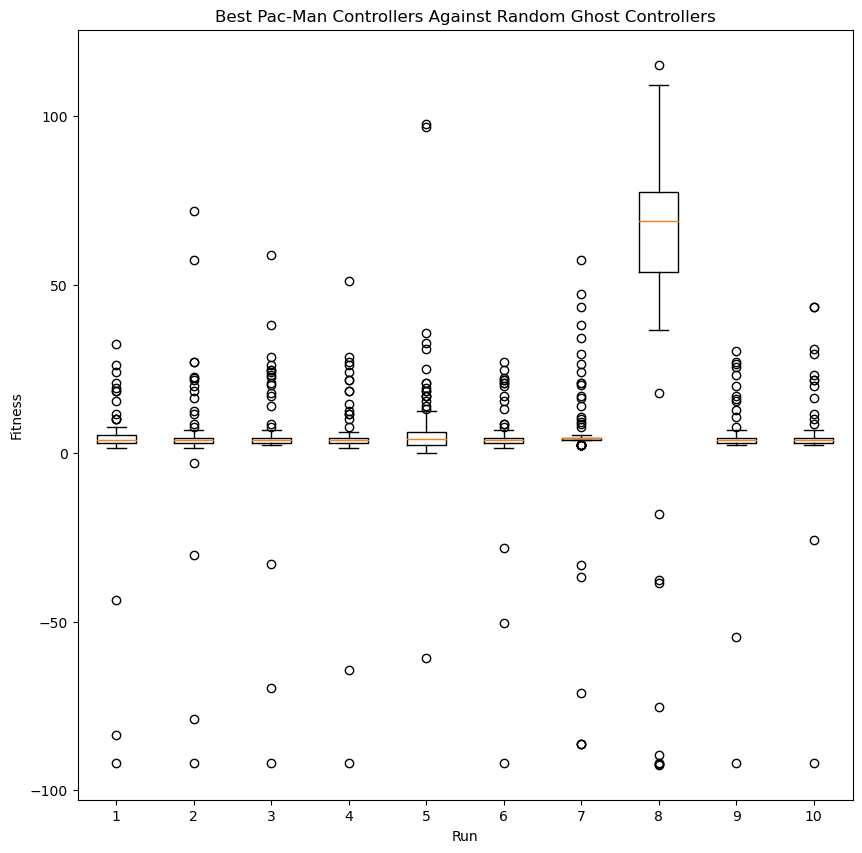

Exception ignored in: <Finalize object, dead>
Traceback (most recent call last):
  File "/home/jwh0100/anaconda3/envs/EC-env/lib/python3.11/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jwh0100/anaconda3/envs/EC-env/lib/python3.11/multiprocessing/pool.py", line 695, in _terminate_pool
    cls._help_stuff_finish(inqueue, task_handler, len(pool))
  File "/home/jwh0100/anaconda3/envs/EC-env/lib/python3.11/multiprocessing/pool.py", line 675, in _help_stuff_finish
    inqueue._rlock.acquire()
KeyboardInterrupt: 


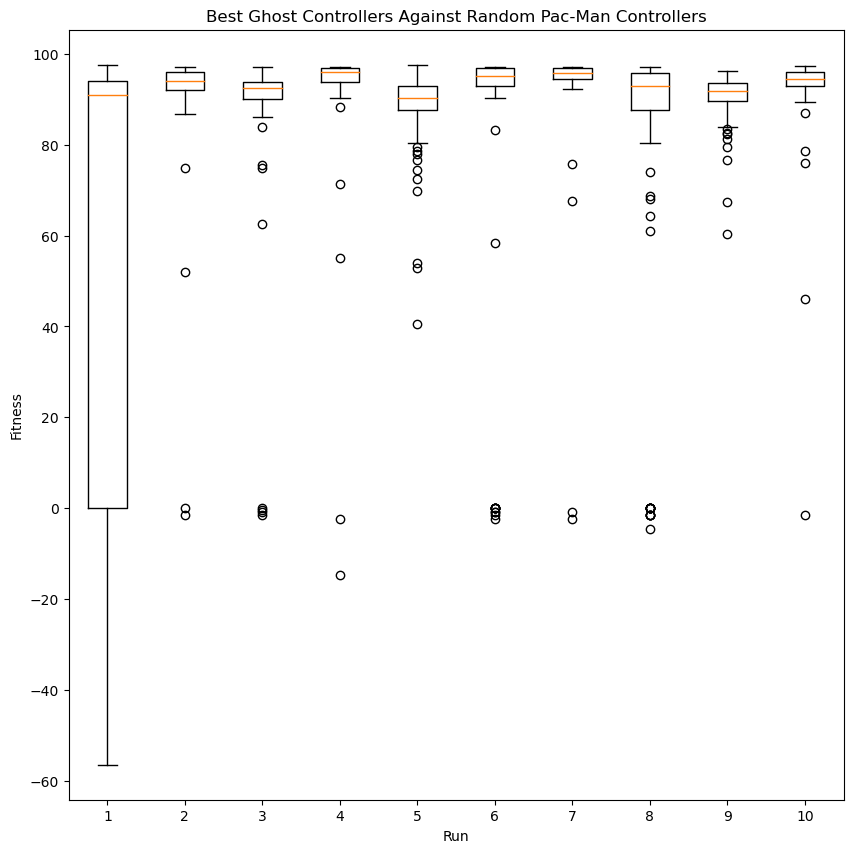

In [499]:
config = read_config('configs/2c_green_config.txt', globals(), locals())
pac_config, ghost_config = split_config(config)

# Assign your best Pac-Man controllers to this variable
# It should be a list of 10 controllers, each being the
# best Pac-Man from the last generation of one of the runs
best_pacs = reconstructed_pacman_trees

# Assign your best Ghost controllers to this variable, similar to the above
best_ghosts = reconstructed_ghost_trees

random_ghosts = TreeGenotype.initialization(100, **ghost_config['problem'])
pac_scores = []
i = 0
for pac in best_pacs:
    pac_scores.append([])
    for ghost in random_ghosts:
        print(i)
        i += 1
        # Note you may need to change this line, depending on how your
        # play_GPac implementation expects the controllers to be passed in.
        score, _ = play_GPac(pac.genes.root, ghost.genes.root, **config['game'])
        pac_scores[-1].append(score)
fig, ax = plt.subplots(figsize=(10, 10))
ax.boxplot(pac_scores)
ax.set(title='Best Pac-Man Controllers Against Random Ghost Controllers', xlabel='Run', ylabel='Fitness')
plt.show()

random_pacs = TreeGenotype.initialization(100, **pac_config['problem'])
ghost_scores = []
for ghost in best_ghosts:
    print(ghost)
    ghost_scores.append([])
    for pac in random_pacs:
        # Note you may need to change this line, depending on how your
        # play_GPac implementation expects the controllers to be passed in.
        score, _ = play_GPac(pac.genes.root, ghost.genes.root, **config['game'])
        ghost_scores[-1].append(-1 * score)
fig, ax = plt.subplots(figsize=(10, 10))
ax.boxplot(ghost_scores)
ax.set(title='Best Ghost Controllers Against Random Pac-Man Controllers', xlabel='Run', ylabel='Fitness')
plt.show()

In [503]:
pac = reconstructed_pacman_trees[7]
ghost = reconstructed_ghost_trees[6]
score, log = play_GPac(pac.genes.root, ghost.genes.root, **config['game'])
print(f'Pacman Parse Tree:\n {pac.genes.print()}')
print(f'Ghost Parse Tree:\n {ghost.genes.print()}')
print(score)
for value in log:
    print(value)

Pacman Parse Tree:
 /
|-
||RAND
|||*
||||G
||||G
|||W
||7.2570766001733205
|P
Ghost Parse Tree:
 -
|-
||P
||*
|||F
|||*
||||F
||||M
|F
-92.77740863787376
35
20
m 0 19
0 34 0
1 0 0
2 34 19
w 0 9
w 0 10
w 1 1
w 1 2
w 1 4
w 1 5
w 1 6
w 1 7
w 1 9
w 1 10
w 1 12
w 1 13
w 1 14
w 1 16
w 1 17
w 1 18
w 2 1
w 2 2
w 2 4
w 2 5
w 2 6
w 2 7
w 2 9
w 2 10
w 2 18
w 3 1
w 3 2
w 3 4
w 3 5
w 3 12
w 3 14
w 3 16
w 3 18
w 4 1
w 4 2
w 4 4
w 4 5
w 4 7
w 4 9
w 4 10
w 4 12
w 4 14
w 4 16
w 4 18
w 5 1
w 5 2
w 5 7
w 5 9
w 5 10
w 5 12
w 5 14
w 5 16
w 5 18
w 6 1
w 6 2
w 6 4
w 6 5
w 6 7
w 6 12
w 6 14
w 6 16
w 6 18
w 7 4
w 7 5
w 7 7
w 7 8
w 7 10
w 7 12
w 7 14
w 7 16
w 8 1
w 8 2
w 8 4
w 8 5
w 8 7
w 8 8
w 8 10
w 8 12
w 8 16
w 8 18
w 9 1
w 9 8
w 9 10
w 9 12
w 9 14
w 9 16
w 9 18
w 10 1
w 10 3
w 10 4
w 10 6
w 10 8
w 10 10
w 10 12
w 10 14
w 10 16
w 10 18
w 11 1
w 11 3
w 11 4
w 11 6
w 11 14
w 11 16
w 11 18
w 12 1
w 12 3
w 12 4
w 12 6
w 12 8
w 12 9
w 12 10
w 12 11
w 12 12
w 12 14
w 12 18
w 13 1
w 13 6
w 13 14
w 13 16
w 13 18
w 

# YELLOW Deliverable
Now that you've completed the GREEN deliverable and performed analysis against a reference set of randomly-generated opponents, experiment with another performance analysis technique. A potential shortcoming of the analysis method used in the GREEN deliverable is that the randomly-generated opponents don't represent the space of performant controllers very well. While performance against poor-performing agents may still be meaningful, it may not be very interesting if our focus is performing well against performant opponents (something addressed by the full analysis technique used in [1]). The 2009 publication *Why Coevolution Doesn't "Work": Superiority and Progress in Coevolution* [2] points out that many competitive coevolution studies suffer from analysis techniques that fail to separate a test set of opponents (those seen during co-evolution) from an evaluation set of opponents (not necessarily seen during co-evolution). 

As a means of circumventing playing against known "test set" opponents while evaluating against opponents found using co-evolution, split the controllers found in your runs in half and have them compete against each other. Specifically, have the Pac-Man controllers from the first 5 runs play the Ghost controllers from the last 5 runs, while the Pac-Man controllers from the last 5 runs should play the Ghost controllers from the first 5 runs. Each pair of controllers should play against each other 10 times, to get a better sample of their performance, and their final score in that pairing should be taken as the average score of these 10 games.

Store the scores as a 10x10 matrix, where `scores[i][j]` is the average score of run `i`'s Pac-Man controller against run `j`'s Ghost controller. Calculate the scores as Pac-Man's score (i.e., do *not* negate values for the Ghost controllers or apply a parsimony penalty). The half of these entries that will not be played (such as `scores[2][4]` or `scores[8][6]`) should be set to `None`.

In the following cell, conduct the pairing & score calculation as described above. When that's done, continue reading below the cell.

Now, load the scores you've calculated into the `scores` variable in the next cell. Then, execute the cell to get a visualization of your data. Make sure to read the paragraph below the next code cell; that's also part of this YELLOW deliverable! This cell contains some test code that will generate random values, so you can know what kind of output to expect.

In [ ]:
from math import inf
import random

# Load your score matrix here
scores = None

####################
#    TEST CODE     #
####################
scores = [[None for y in range(10)] for x in range(10)]
for x in range(10):
    for y in range(10):
        if (x < 5 and y >= 5) or (x >= 5 and y < 5):
            scores[x][y] = random.uniform(-100, 100)
        else:
            scores[x][y] = None
####################
# END OF TEST CODE #
####################

rgbs = [[[] for y in range(len(scores[x]))] for x in range(len(scores))]
text = [[None for y in range(len(scores[x]))] for x in range(len(scores))]
max_score = -inf
min_score = inf
for x in range(len(scores)):
    for y in range(len(scores[x])):
        # Deliberately inverted; imshow is weird, rasters are column-major
        score = scores[y][x]
        if score is None:
            rgbs[x][y] = [1.0, 1.0, 1.0]
        else:
            if max_score < score:
                max_score = score
                max_score_loc = (x, y)
            if min_score > score:
                min_score = score
                min_score_loc = (x, y)
            # Scale the scores from [-100, 100] to [0, 1] for coloring
            scalar = (score + 100) / 200
            # This is hopefully still legible for people with deuteranopia
            # Feel free to modify the RGB calculations if you want
            rgbs[x][y] = [1 - scalar, scalar, (1 - scalar) / 2]
            text[x][y] = f'{score:.2f}'

# Highlight the min and max scores with a unique color
rgbs[max_score_loc[0]][max_score_loc[1]] = [0.5, 0.5, 1.0]
rgbs[min_score_loc[0]][min_score_loc[1]] = [0.5, 0.5, 1.0]

fig, ax = plt.subplots(figsize=(9, 9))
ax.imshow(rgbs, origin='lower')
for x in range(len(text)):
    for y in range(len(text[x])):
        if not text is None:
            ax.text(y, x, text[x][y], ha='center', va='center', fontsize='large')
ax.set(title='Exhibition Game Matrix (Pac-Man score)', xlabel='Pac-Man', ylabel='Ghost')
plt.show()

Are you able to see any signs of intransitivity in this visualization? Do the results differ meaningfully from those obtained using the GREEN analysis method? Place the visualization and the answers to these prompts in your report. For information about the shortcomings of this approach, see the appendix of this notebook.

# RED Deliverables
Feel free to create more notebook cells for RED deliverables as necessary. Here are some comments on those deliverables.

### Config Files
For the RED deliverables in this assignment, you are tasked with creating your own config files. For many of the RED deliverables, you can use the provided config files and code as inspiration for new config files and the parsing of those files, respectively.

### Modified Fitness Function
The RED deliverables require a modified version of the `play_GPac` function. See the last cell of `2b_notebook.ipynb` for more information.

## References
[1] Wojciech Jaśkowski, Paweł Liskowski, Marcin Szubert, and Krzysztof Krawiec. 2013. Improving coevolution by random sampling. In Proceedings of the 15th annual conference on Genetic and evolutionary computation (GECCO '13). Association for Computing Machinery, New York, NY, USA, 1141–1148. https://doi.org/10.1145/2463372.2463512

[2] Thomas Miconi. 2009. Why Coevolution Doesn't "Work": Superiority and Progress in Coevolution. In Proceedings of the 12th European Conference on Genetic Programming (EuroGP '09). Springer-Verlag, Berlin, Heidelberg, 49–60. https://doi.org/10.1007/978-3-642-01181-8_5

## Appendix

### GREEN Analysis Method Shortcomings
As mentioned previously in the notebook, our analysis method in GREEN is lacking rigor compared to the methods used in [1]. In [1], the methodology employed uses much larger populations of randomly-generated opponents that play against a still larger population of random opponents and are sorted based on performance. This seemingly worked well in [1] because the strategy representation is essentially a linear sequence of actions. For more complicated controllers with stochasticity (e.g., the `RAND` primitive), the idea of playing against randomly generated opponents at all has meaningful issues. First, random search has no guarantee of exploring performant strategy space. In other words, the agents you want to assess may only play against poor-performing and uninteresting opponents (compared to performant strategies discovered through other optimization approaches). Second, a single game between two given controllers may not be representative of the performance of either controller against one another. Depending on the amount of stochasticity in the controllers and the problem itself, it may take an intractable number of games to determine an accurate mean score for all pairs of agents used in analysis. As such, this method was not originally intended for use on competitions with stochasticity. Third, the representative strategy was selected as the highest-fitness individual from each population at the last generation of co-evolution and that fitness may have been approximated through competition with as few as one opponent. As a result, there's a very good chance the representative agent of each run is not the best agent discovered throughout the entire run, but rather an agent that was just paired against a poorly-performing agent in the final generation. Solving these issues requires being able to meaningfully assess global performance against all possible strategies [2], which is an open area of research.

### YELLOW Analysis Method Shortcomings
As was the case with the GREEN analysis method, the YELLOW analysis method also suffers from issues pertaining to stochasticity during competition between two strategies and difficulties in selecting the strategy found during each run that has the best global performance against all possible opponents [2]. The latter issue (using representatives that may not have the best global performance in the run) is somewhat exacerbated in this technique, since the primary improvement over the GREEN analysis method is competition against performant opponents. Additionally, since such few opponents are being used, issues with intransitivity can arise. Namely, if a strategy is well-suited for competition against a particular type of high-performing strategy that happens to not be well-represented in the evaluation set of opponents, then the performance of that strategy may appear deceptively low.